In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from DataTransformation import LowPassFilter
from scipy.signal import argrelextrema
from sklearn.metrics import mean_absolute_error
import math
pd.options.mode.chained_assignment=None
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"]=(20,5)
plt.rcParams["figure.dpi"]=100
plt.rcParams["lines.linewidth"]=2

In [18]:
df=pd.read_pickle("../../data/interim/01_Data_Processed.pkl")
df

Accelerometer_x  Accelerometer_y  Accelerometer_z  \
epoch (ms)                                                                   
2019-01-11 15:08:05.200         0.013500         0.977000        -0.071000   
2019-01-11 15:08:05.400        -0.001500         0.970500        -0.079500   
2019-01-11 15:08:05.600         0.001333         0.971667        -0.064333   
2019-01-11 15:08:05.800        -0.024000         0.957000        -0.073500   
2019-01-11 15:08:06.000        -0.028000         0.957667        -0.115000   
...                                  ...              ...              ...   
2019-01-20 17:33:27.000        -0.048000        -1.041500        -0.076500   
2019-01-20 17:33:27.200        -0.037000        -1.030333        -0.053333   
2019-01-20 17:33:27.400        -0.060000        -1.031000        -0.082000   
2019-01-20 17:33:27.600        -0.038667        -1.025667        -0.044667   
2019-01-20 17:33:27.800        -0.044000        -1.034000        -0.059000   

                         Gyroscope_x  Gyroscope_y  Gyroscope_z Participants  \
epoch (ms)                                                                    
2019-01-11 15:08:05.200      -1.8904       2.4392       0.9388            B   
2019-01-11 15:08:05.400      -1.6826      -0.8904       2.1708            B   
2019-01-11 15:08:05.600       2.5608      -0.2560      -1.4146            B   
2019-01-11 15:08:05.800       8.0610      -4.5244      -2.0730            B   
2019-01-11 15:08:06.000       2.4390      -1.5486      -3.6098            B   
...                              ...          ...          ...          ...   
2019-01-20 17:33:27.000       1.4146      -5.6218       0.2926            E   
2019-01-20 17:33:27.200      -2.7684      -0.5854       2.2440            E   
2019-01-20 17:33:27.400       2.8416      -5.1342      -0.1220            E   
2019-01-20 17:33:27.600      -0.2318       0.2562       1.1220            E   
2019-01-20 17:33:27.800       1.0980      -4.0240       0.9760            E   

                         Label Category  Set  
epoch (ms)                                    
2019-01-11 15:08:05.200  bench    heavy   30  
2019-01-11 15:08:05.400  bench    heavy   30  
2019-01-11 15:08:05.600  bench    heavy   30  
2019-01-11 15:08:05.800  bench    heavy   30  
2019-01-11 15:08:06.000  bench    heavy   30  
...                        ...      ...  ...  
2019-01-20 17:33:27.000    row   medium   40  
2019-01-20 17:33:27.200    row   medium   40  
2019-01-20 17:33:27.400    row   medium   40  
2019-01-20 17:33:27.600    row   medium   40  
2019-01-20 17:33:27.800    row   medium   40  

[9009 rows x 10 columns]

In [19]:
df=df[df["Label"]!="rest"]
acc_r=df["Accelerometer_x"]**2+df["Accelerometer_y"]**2+df["Accelerometer_z"]**2
gyro_r=df["Gyroscope_x"]**2+df["Gyroscope_y"]**2+df["Gyroscope_z"]**2
df["Accelerometer_r"]=np.sqrt(acc_r)
df["Gyroscope_r"]=np.sqrt(gyro_r)


In [20]:
bench_df=df[df["Label"]=="bench"]
squat_df=df[df["Label"]=="squat"]
row_df=df[df["Label"]=="row"]
ohp_df=df[df["Label"]=="ohp"]
dead_df=df[df["Label"]=="dead"]


In [21]:
fs=1000/200
LowPass=LowPassFilter()

bench_set=bench_df[bench_df["Set"]==bench_df["Set"].unique()[0]]
squat_set=squat_df[squat_df["Set"]==squat_df["Set"].unique()[0]]
row_set=row_df[row_df["Set"]==row_df["Set"].unique()[0]]
ohp_set=ohp_df[ohp_df["Set"]==ohp_df["Set"].unique()[0]]
dead_set=dead_df[dead_df["Set"]==dead_df["Set"].unique()[0]]

<Axes: xlabel='epoch (ms)'>

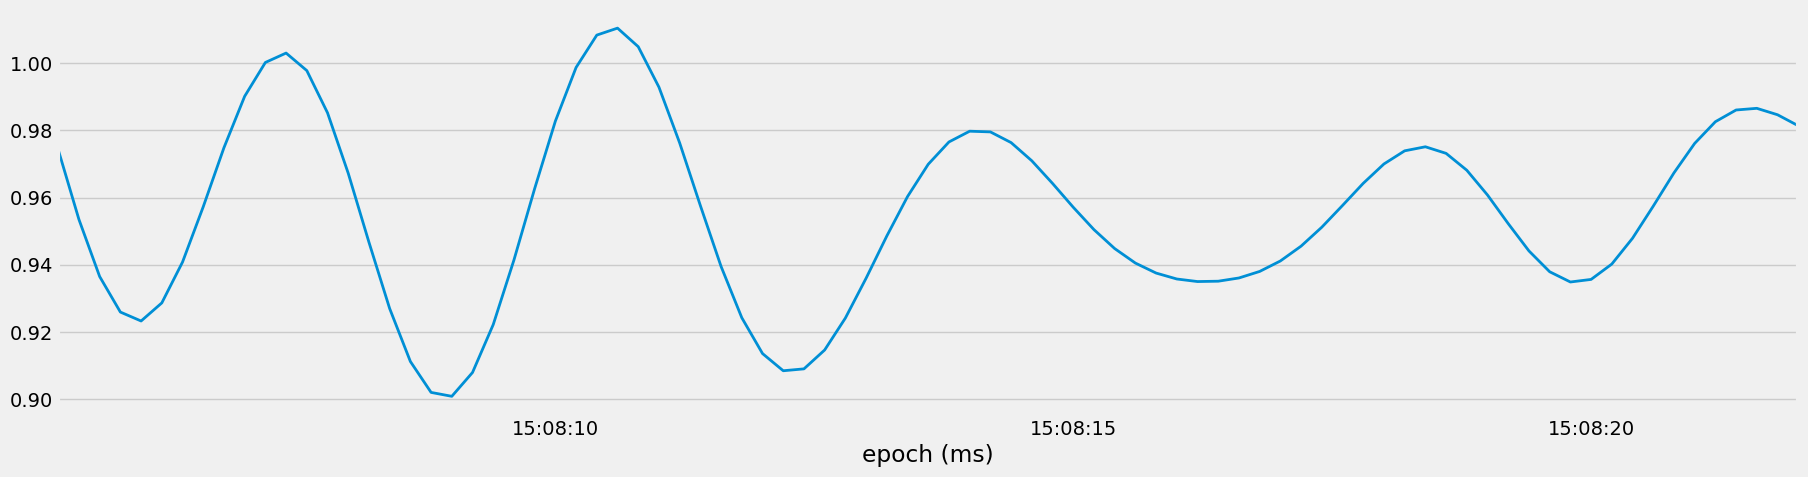

In [22]:
column="Accelerometer_y"
LowPass.low_pass_filter(bench_set,column,fs,0.4,10)[column+"_lowpass"].plot()

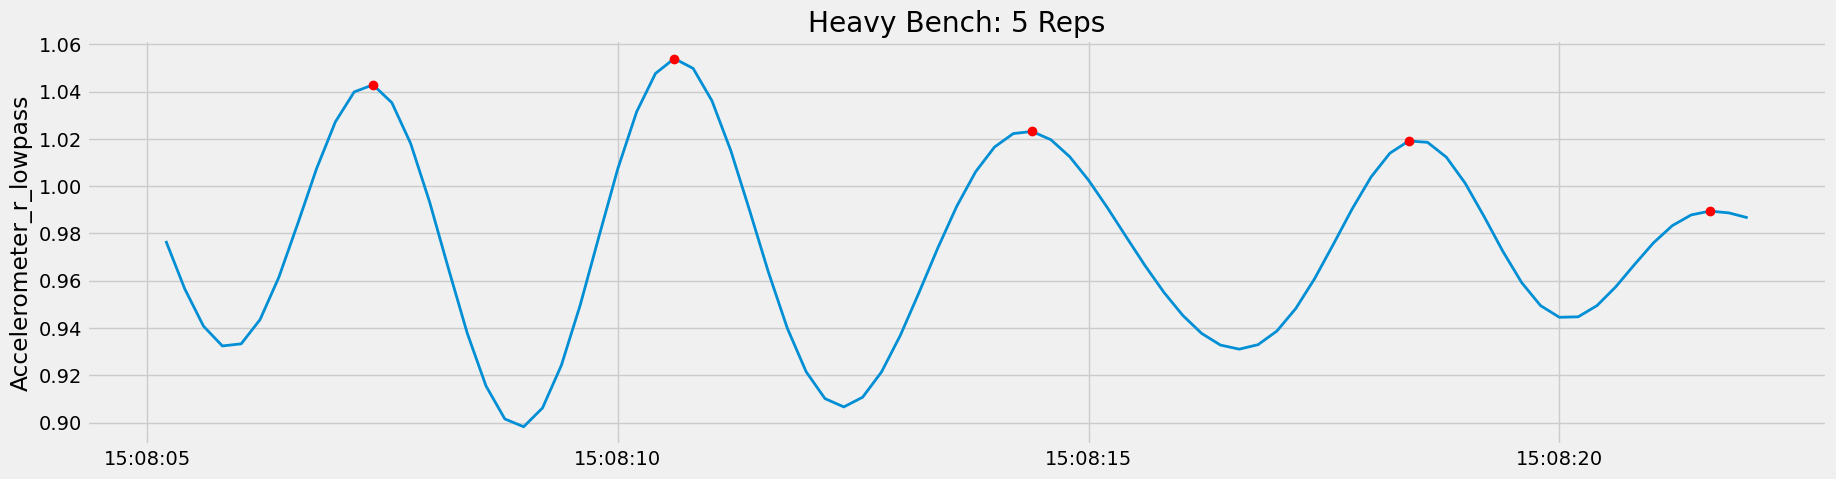

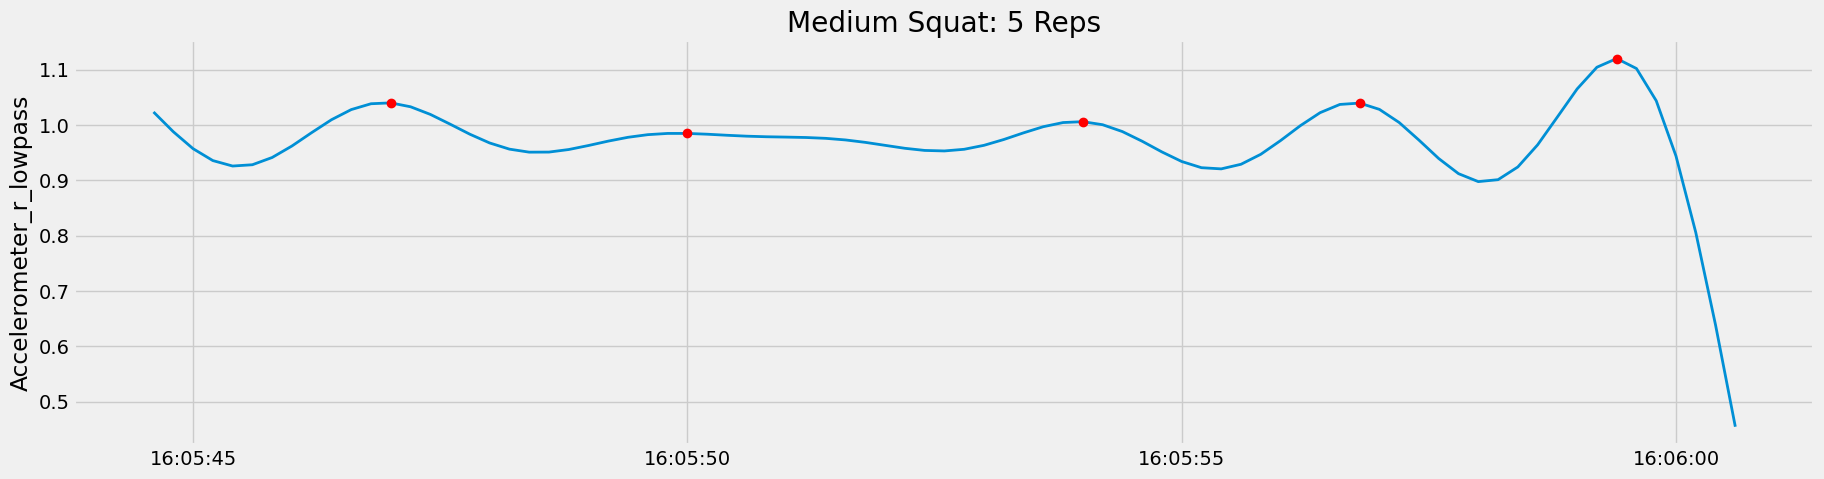

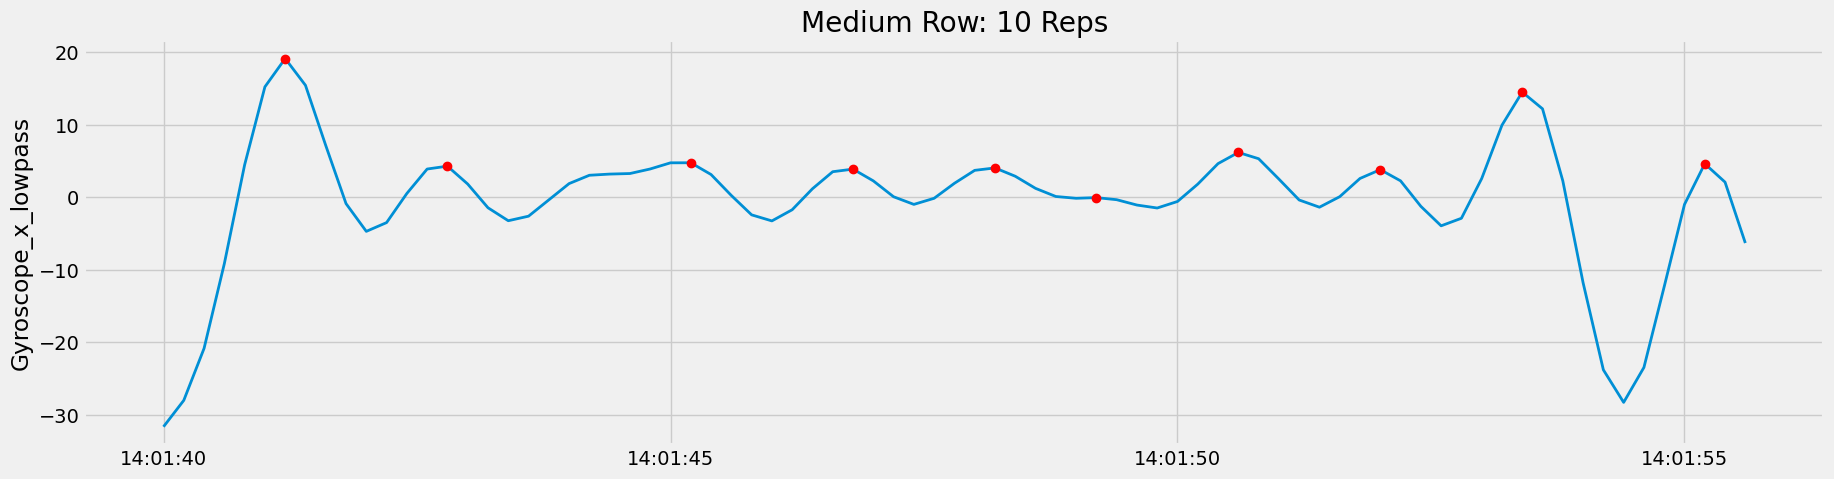

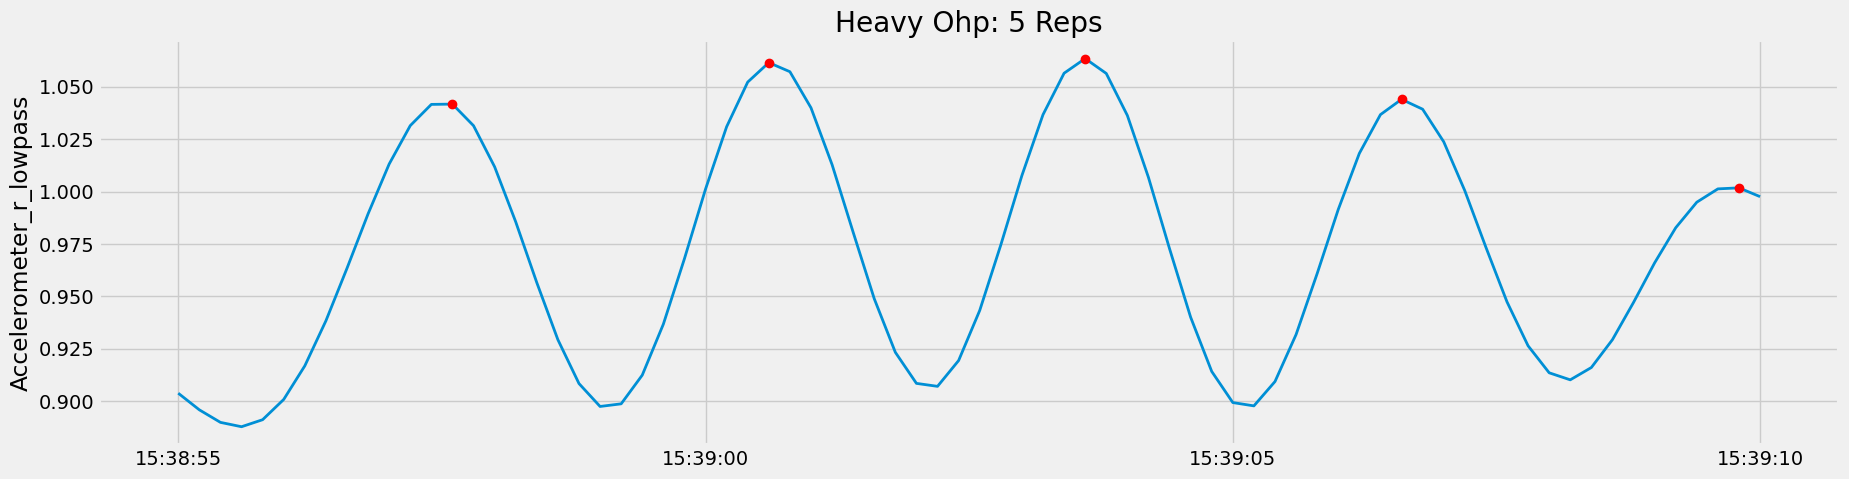

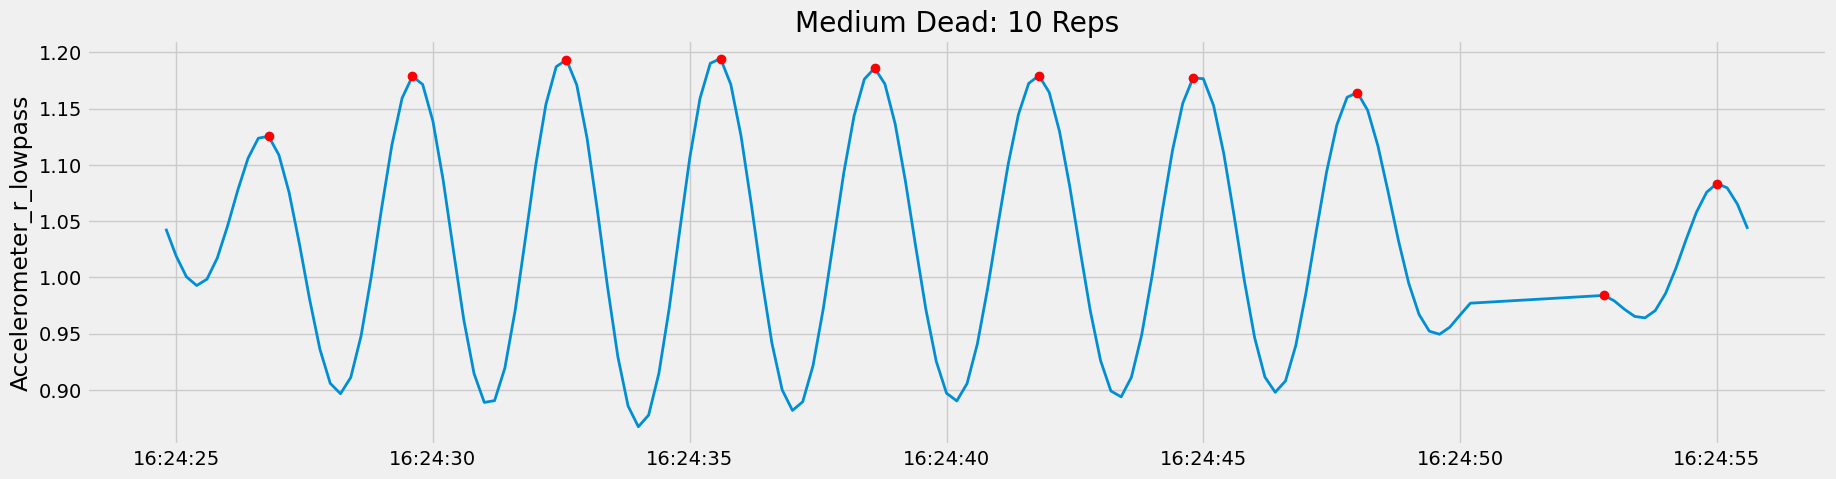

10

In [23]:
def count(df,cutoff=0.4,order=10,column="Accelerometer_r"):
    data=LowPass.low_pass_filter(df,column,fs,cutoff,order)
    indexes=argrelextrema(data[column+"_lowpass"].values,np.greater)
    peeks=data.iloc[indexes]
    fig,ax=plt.subplots()
    plt.plot(df[f"{column}_lowpass"])
    plt.plot(peeks[f"{column}_lowpass"],"o",color="red")
    ax.set_ylabel(f"{column}_lowpass")
    exercise=df["Label"].iloc[0].title()
    category=df["Category"].iloc[0].title()
    plt.title(f"{category} {exercise}: {len(peeks)} Reps")
    plt.show()
    return len(peeks)


count(bench_set,cutoff=0.4)
count(squat_set,cutoff=0.35)
count(row_set,cutoff=0.65,column="Gyroscope_x")
count(ohp_set,cutoff=0.35)
count(dead_set,cutoff=0.4)

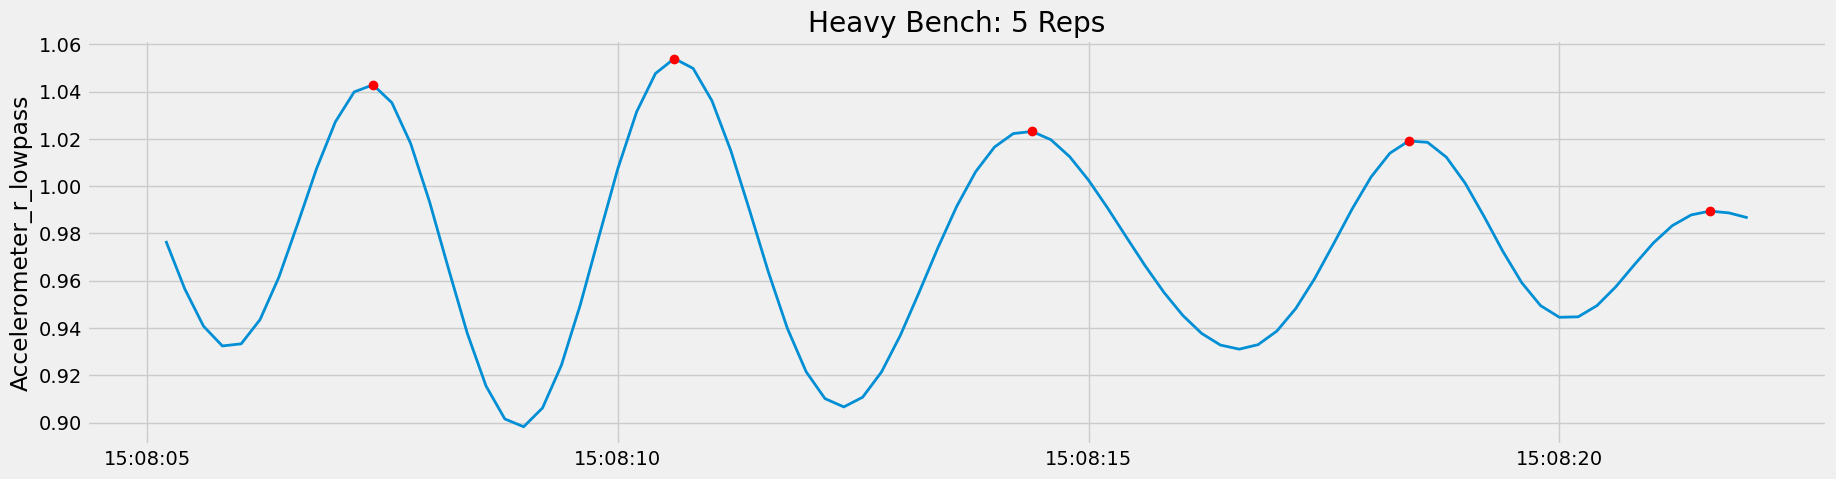

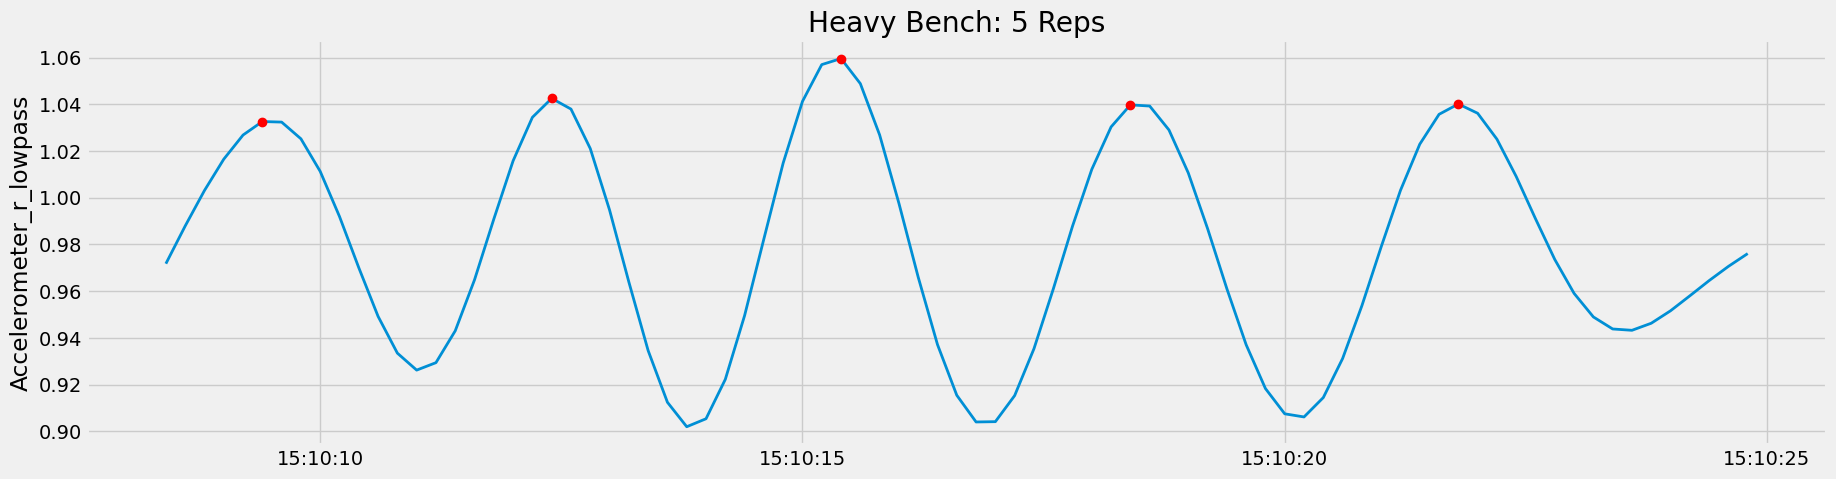

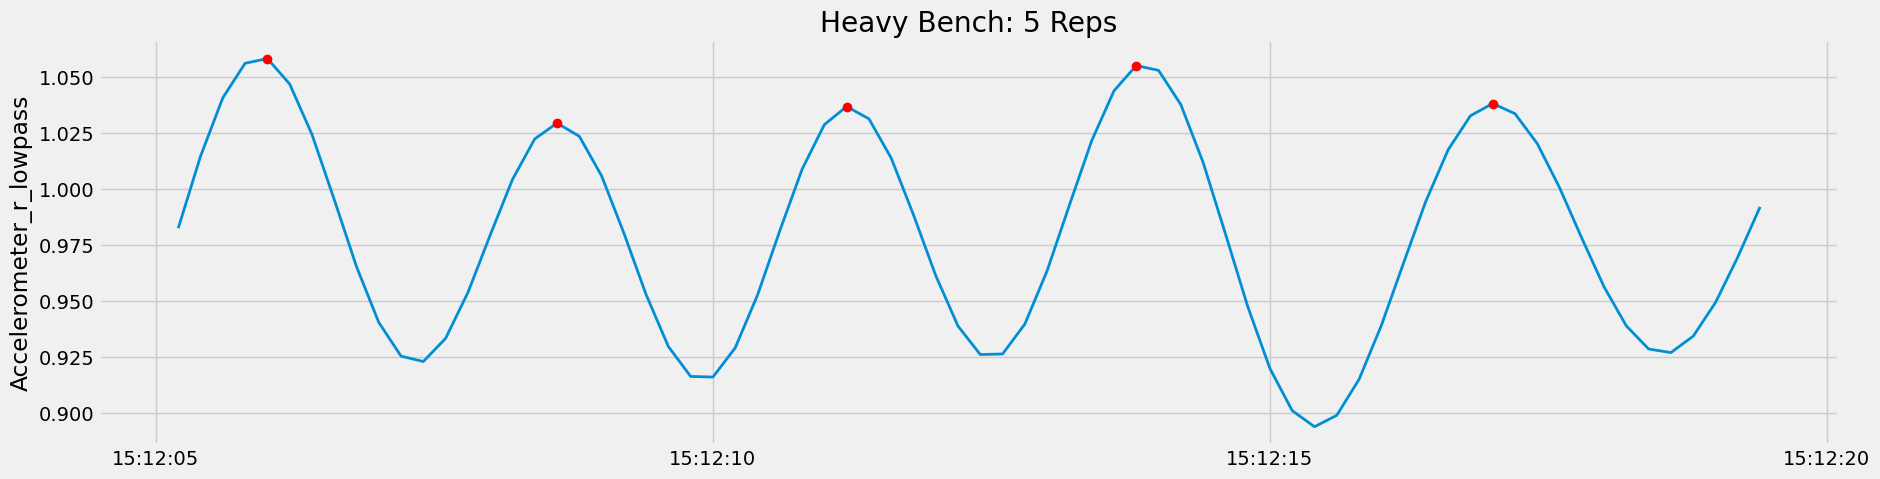

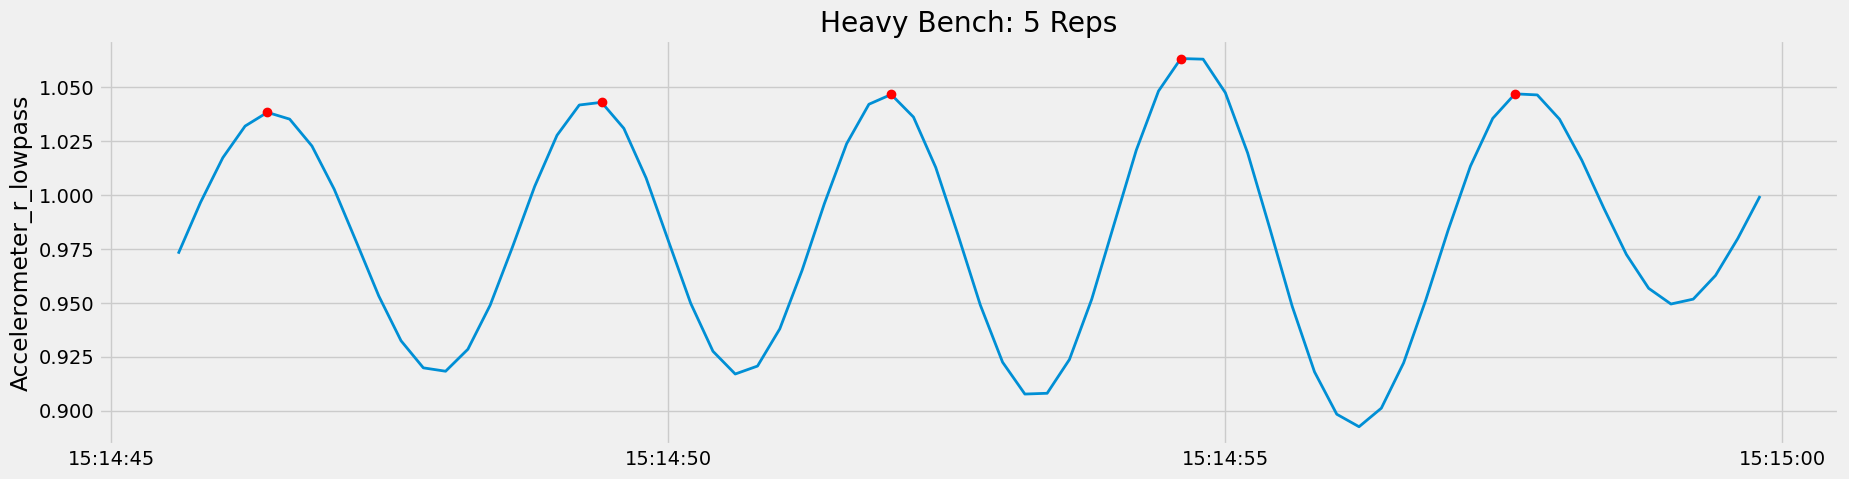

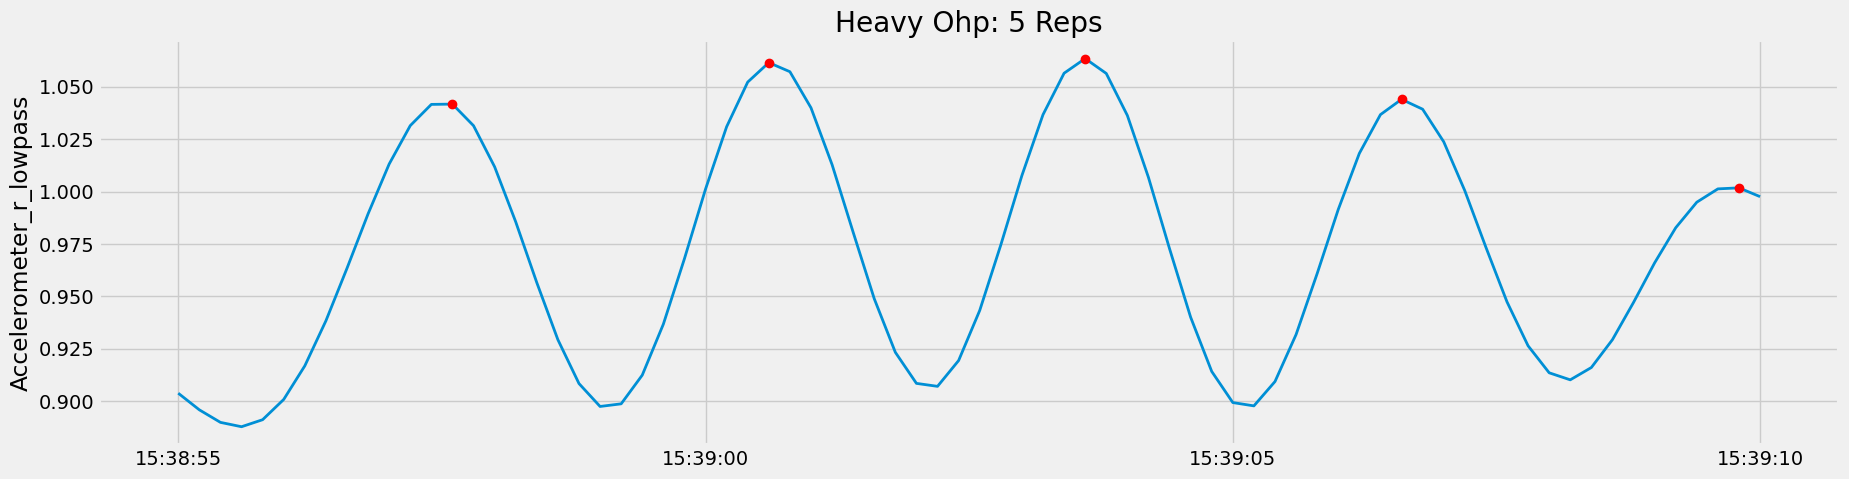

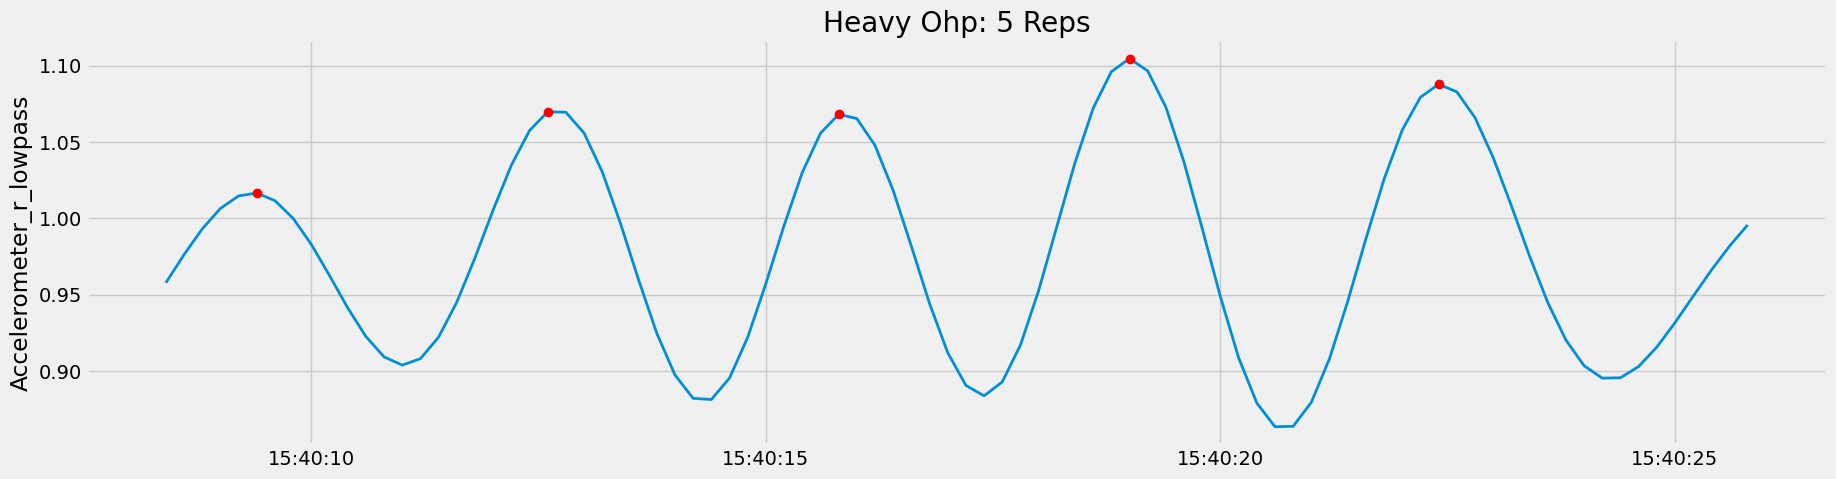

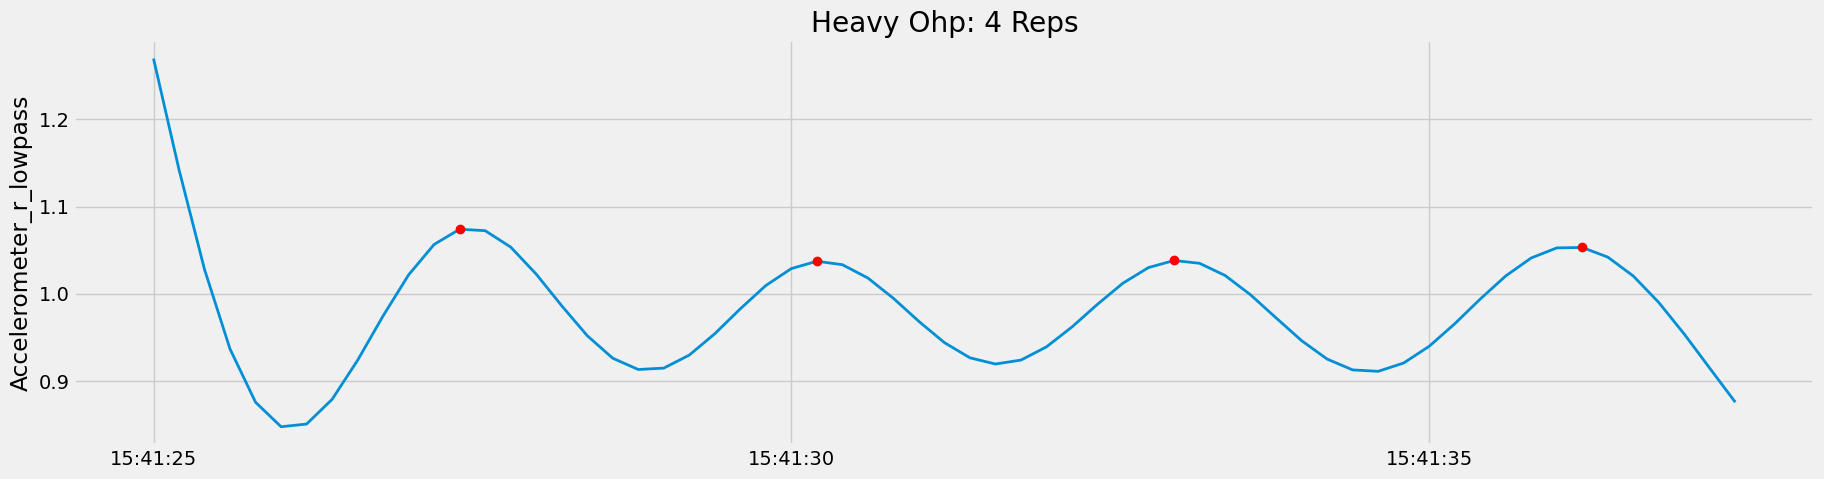

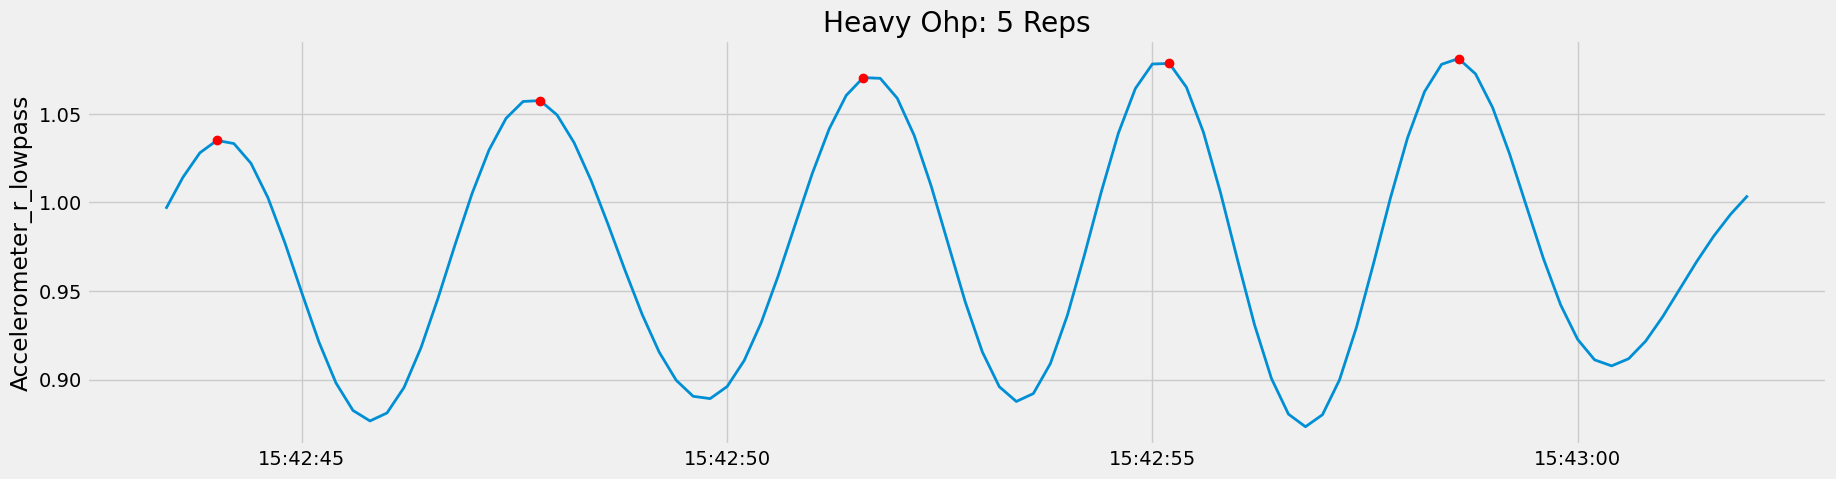

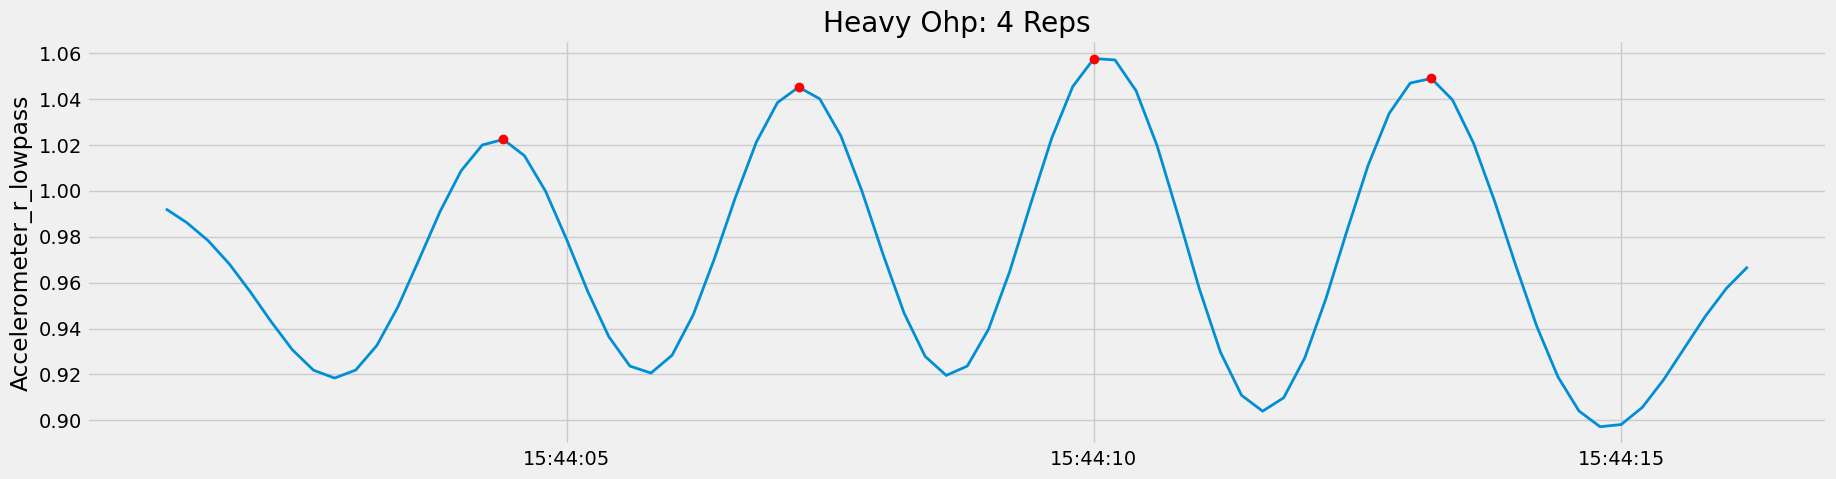

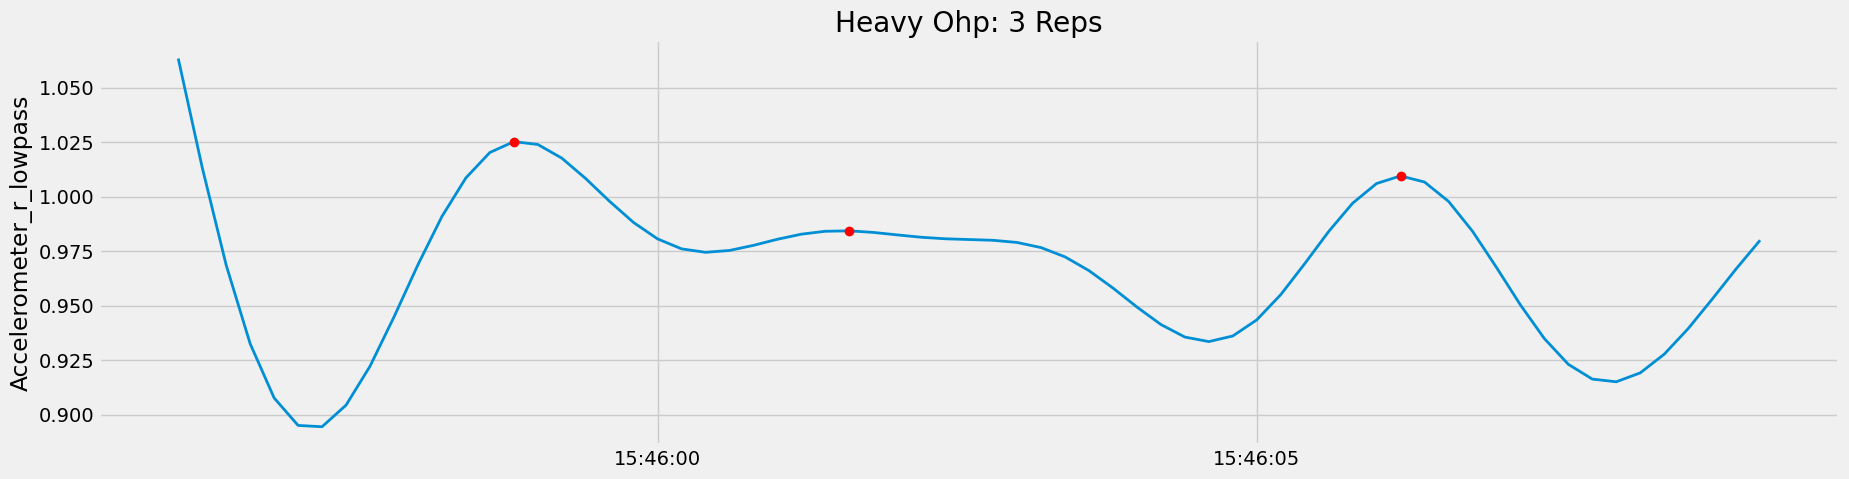

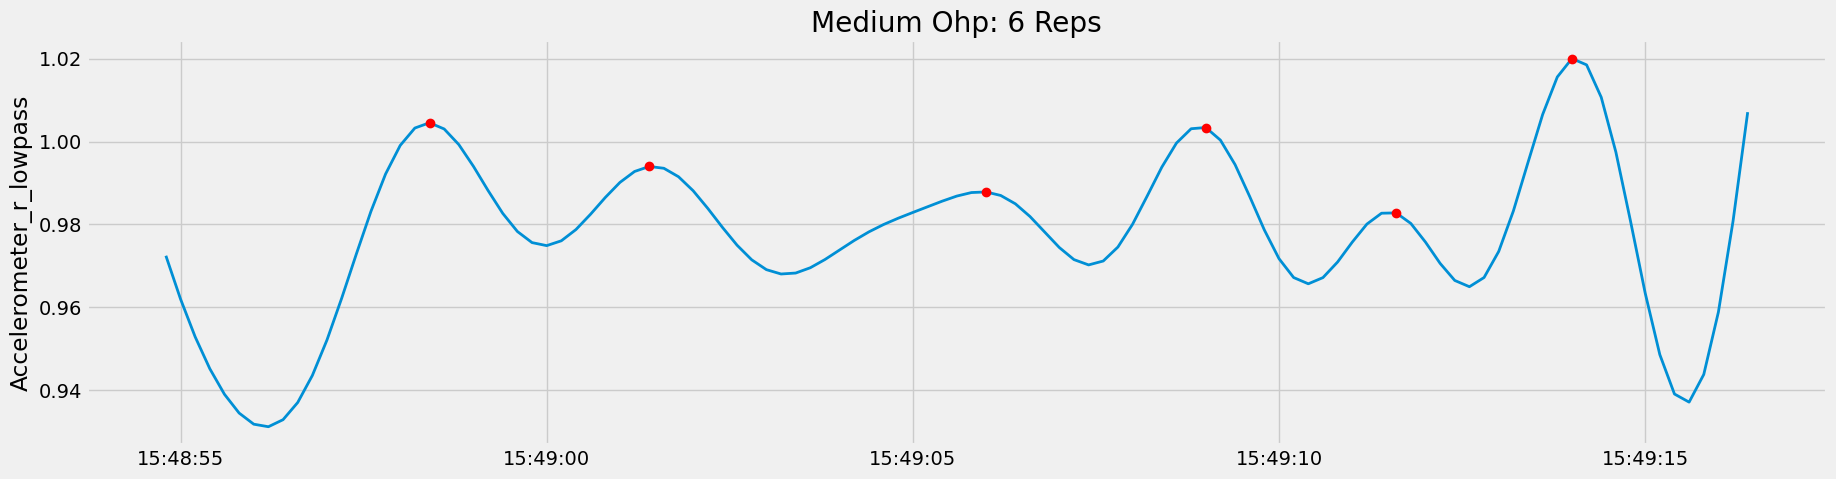

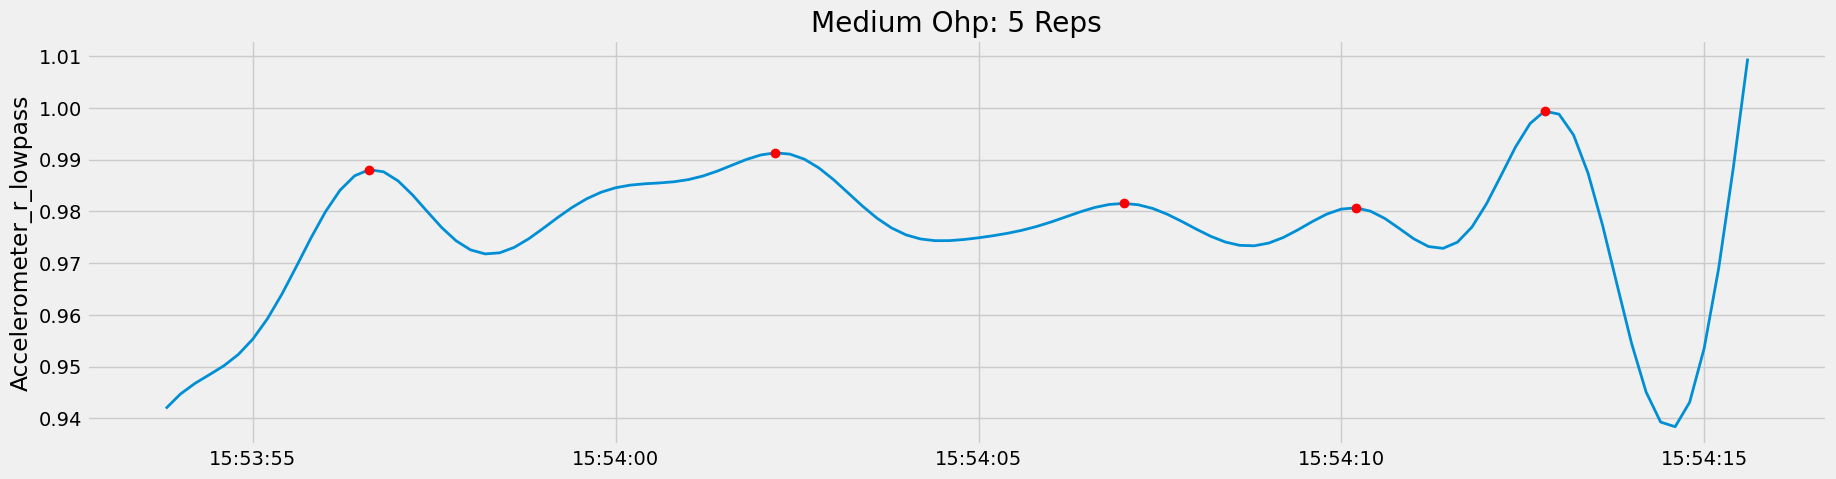

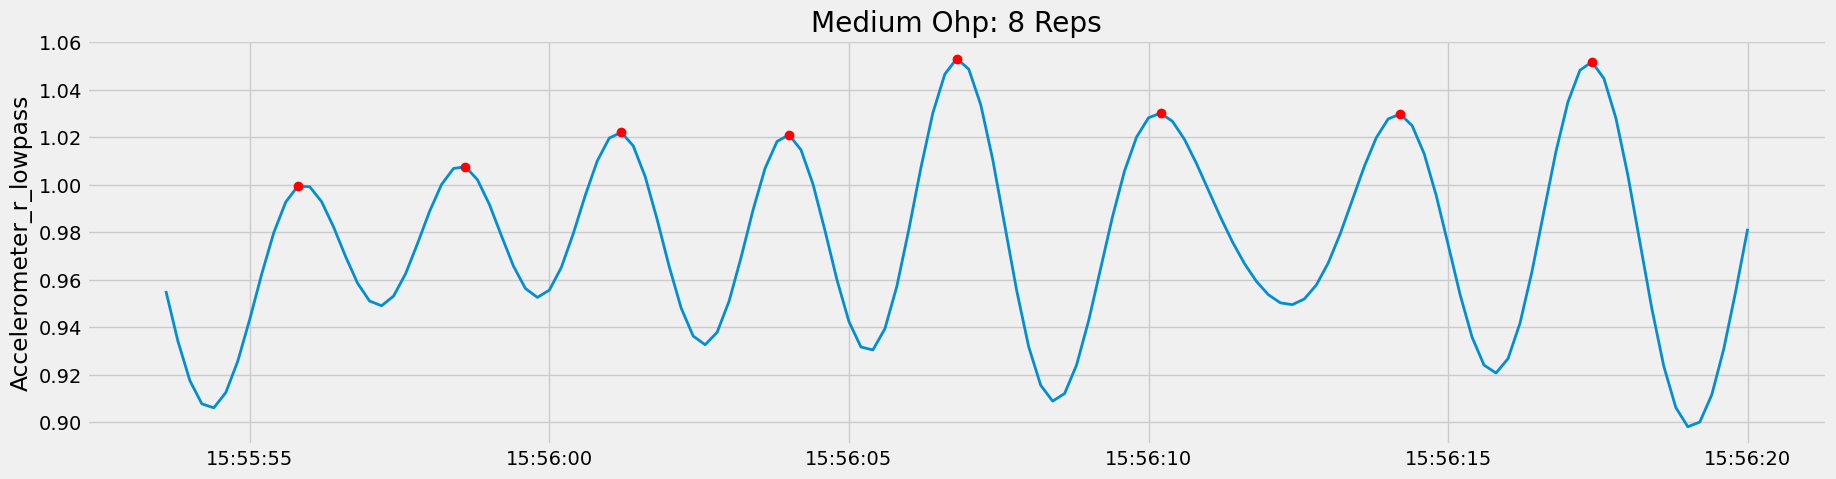

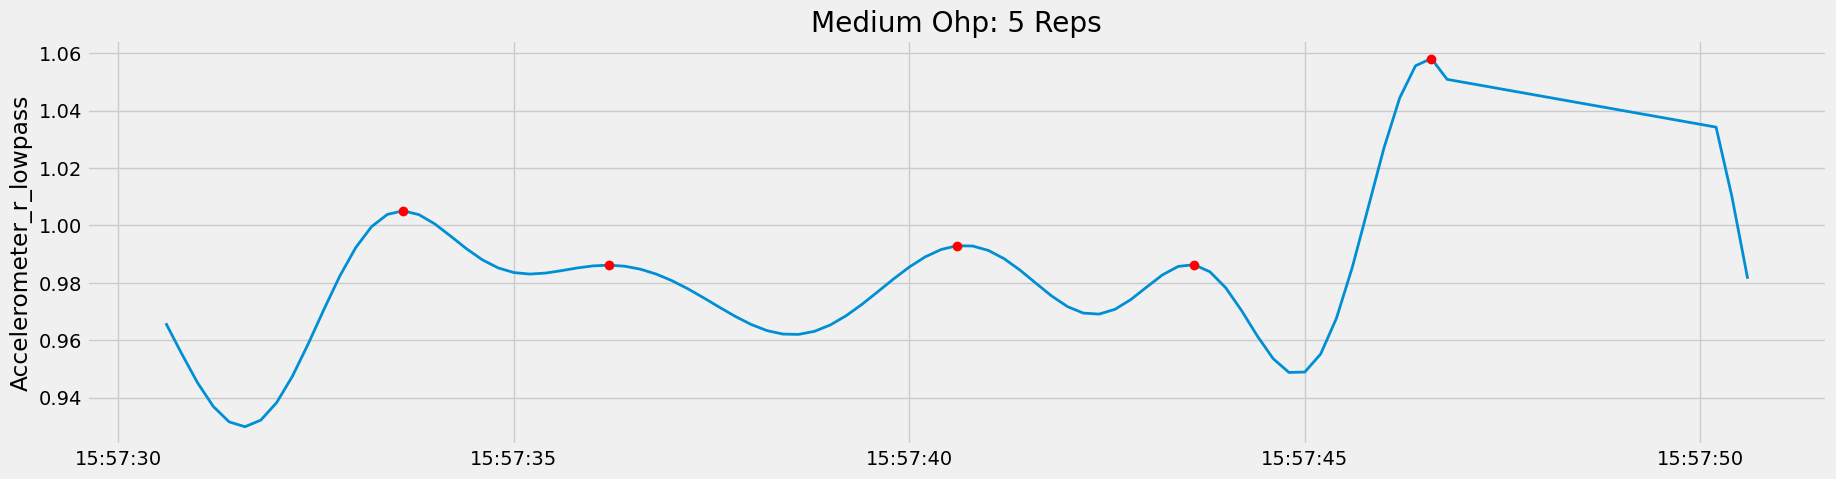

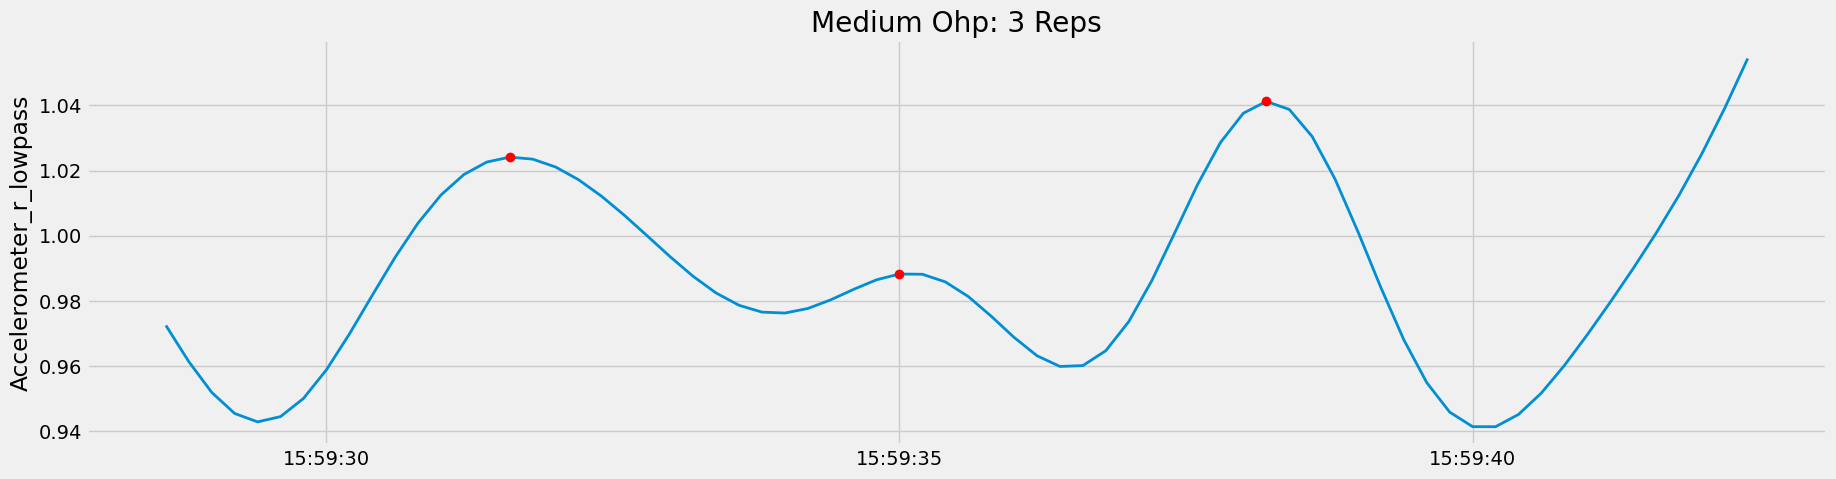

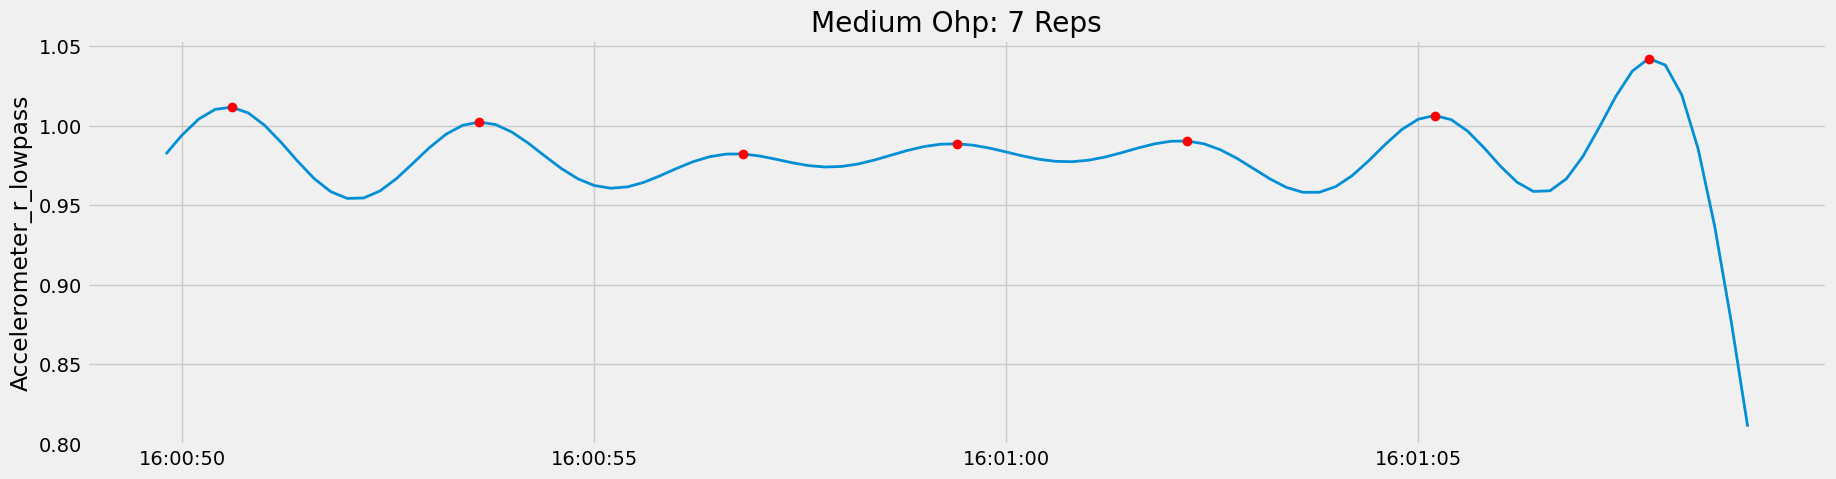

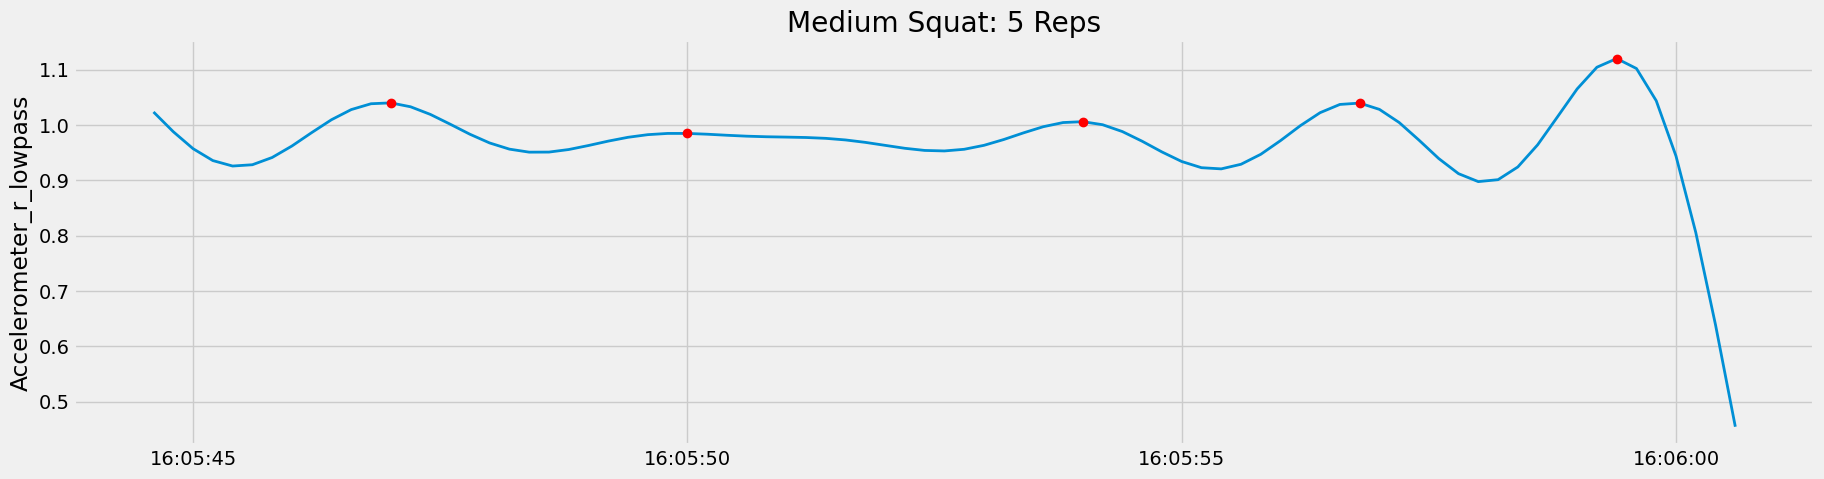

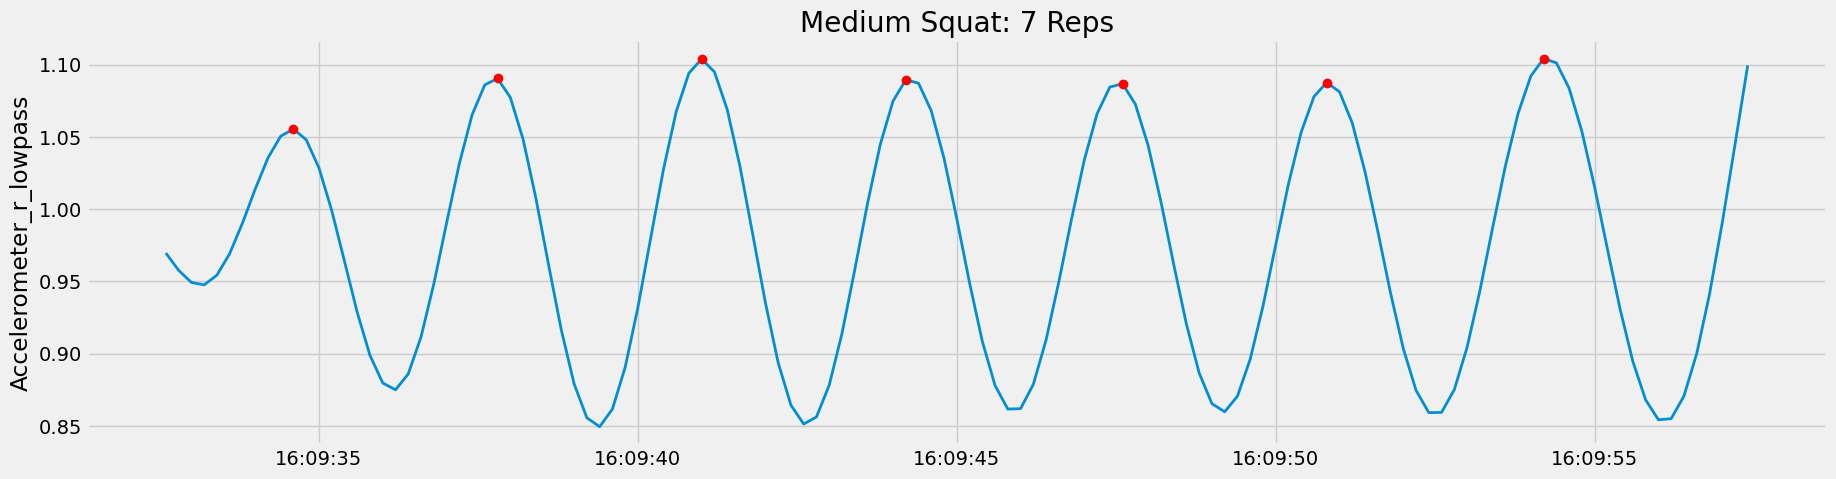

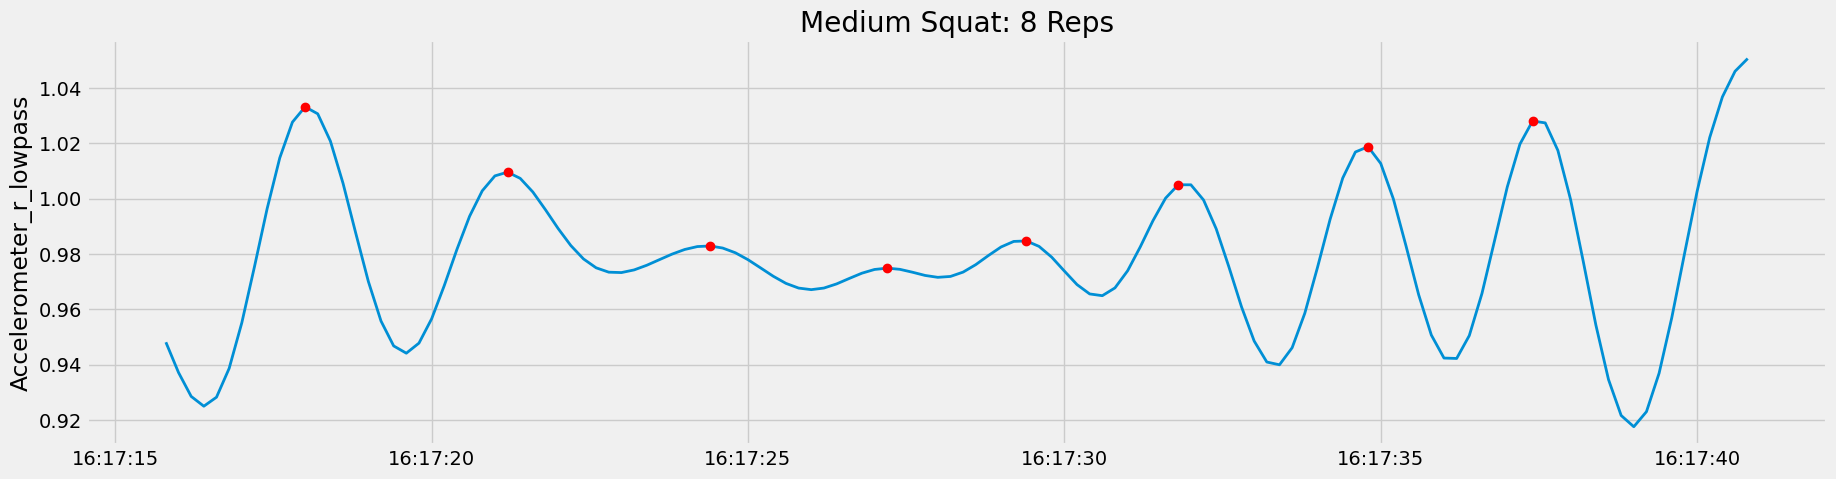

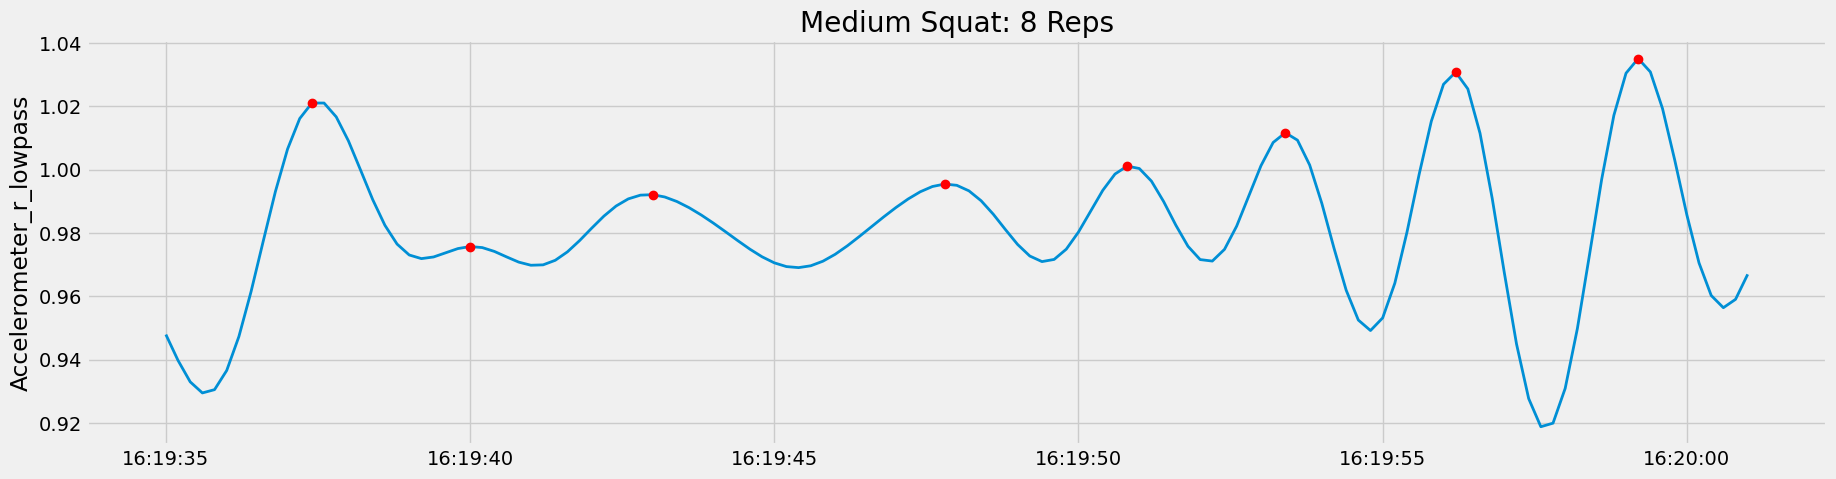

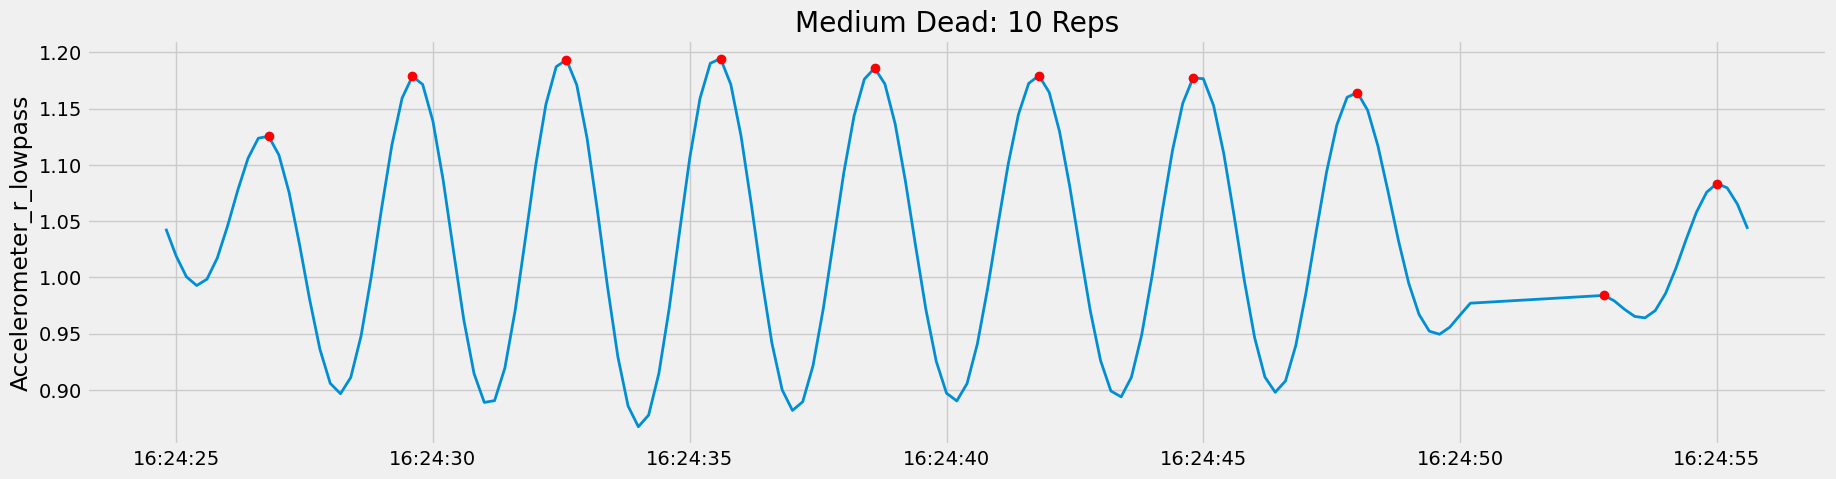

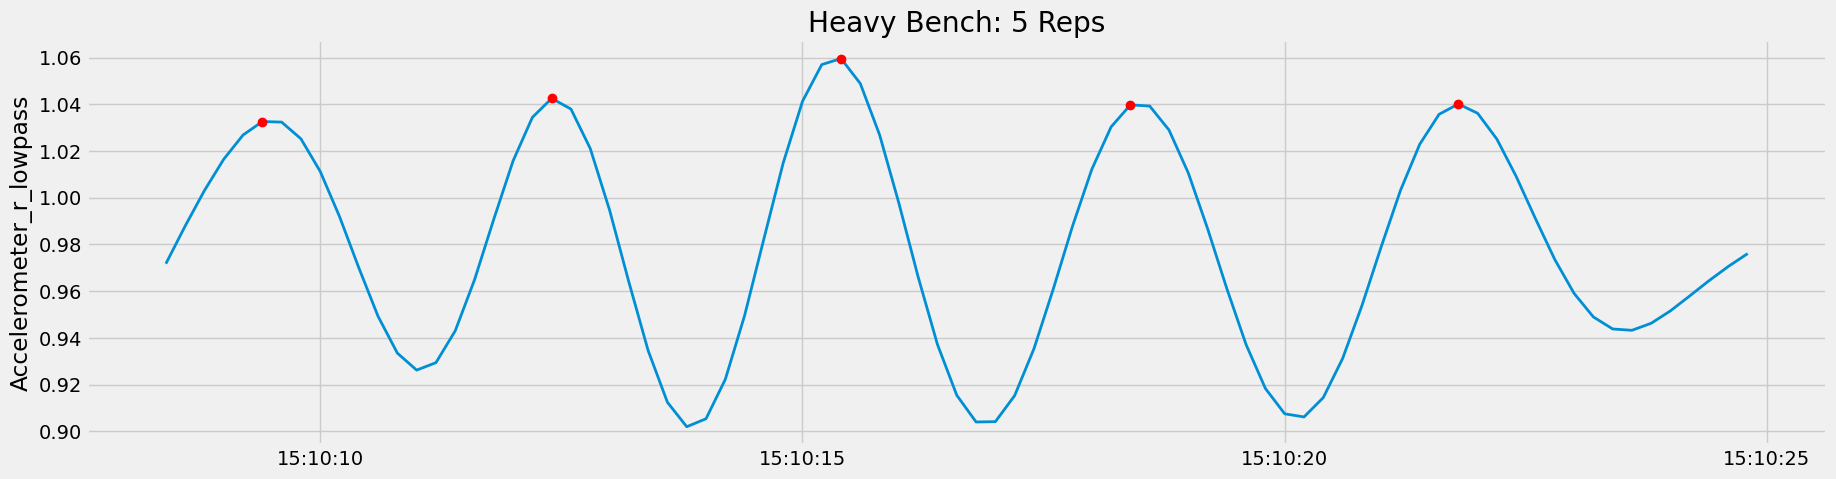

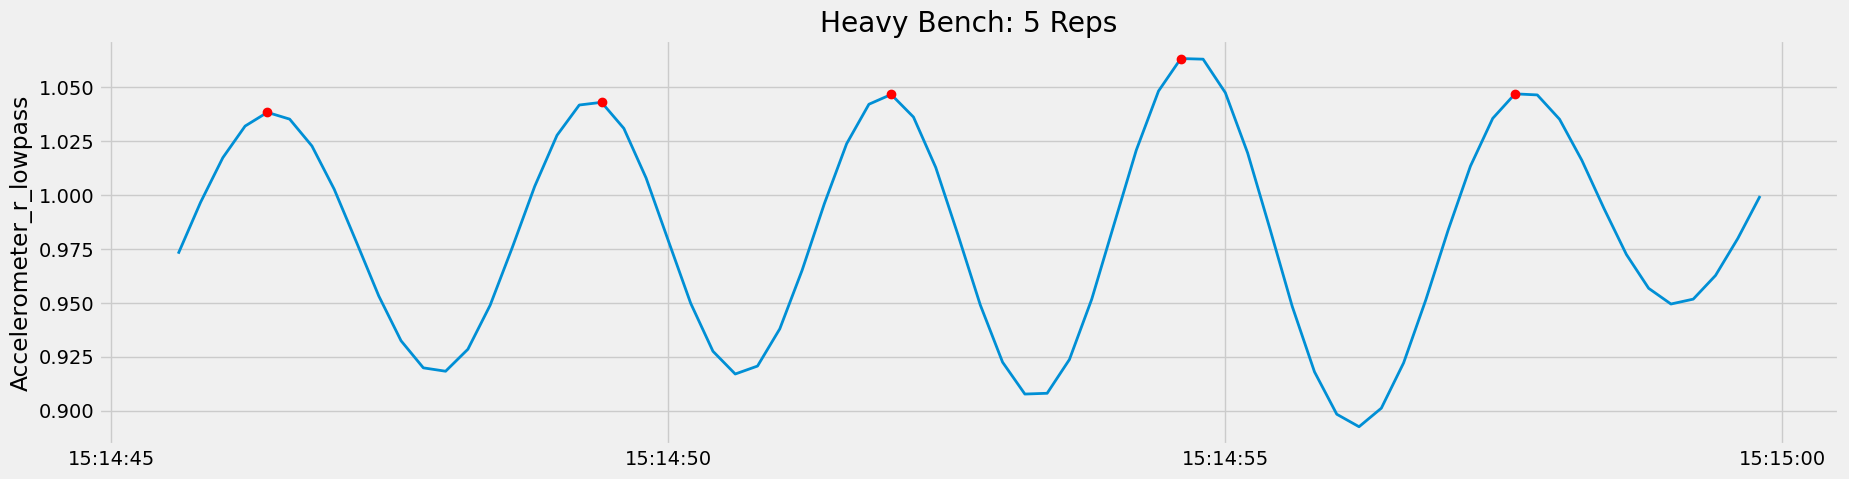

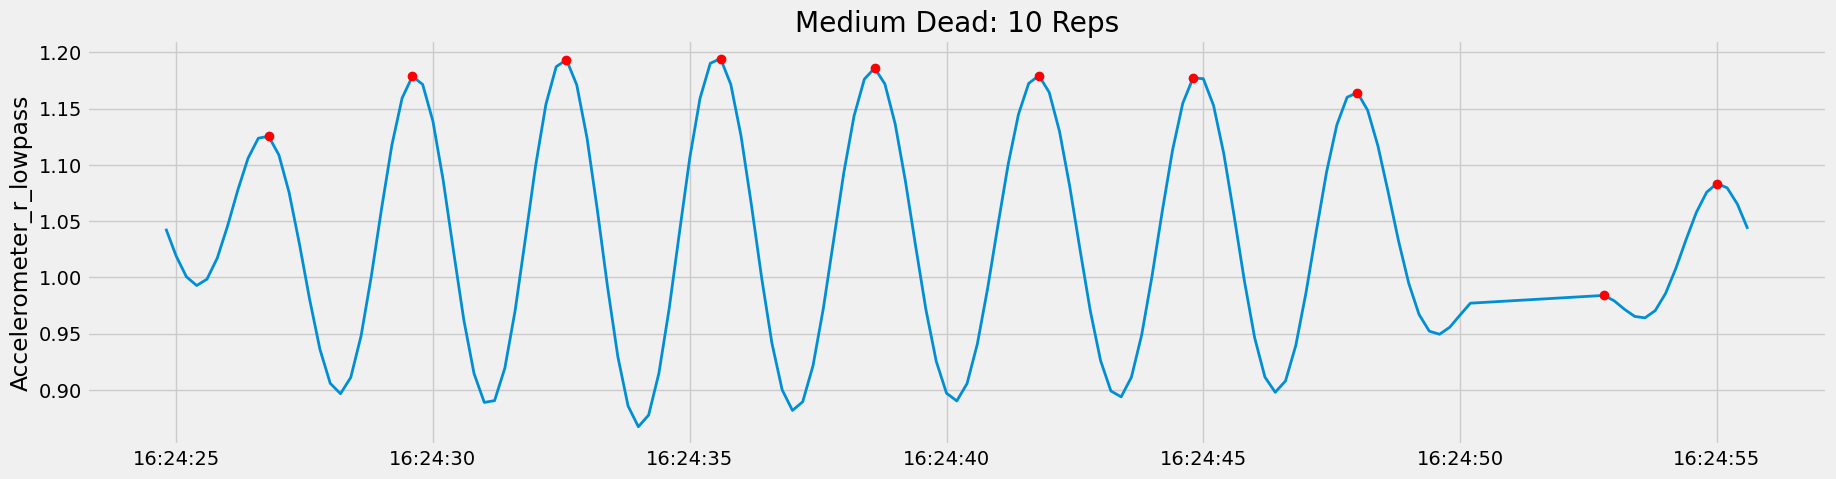

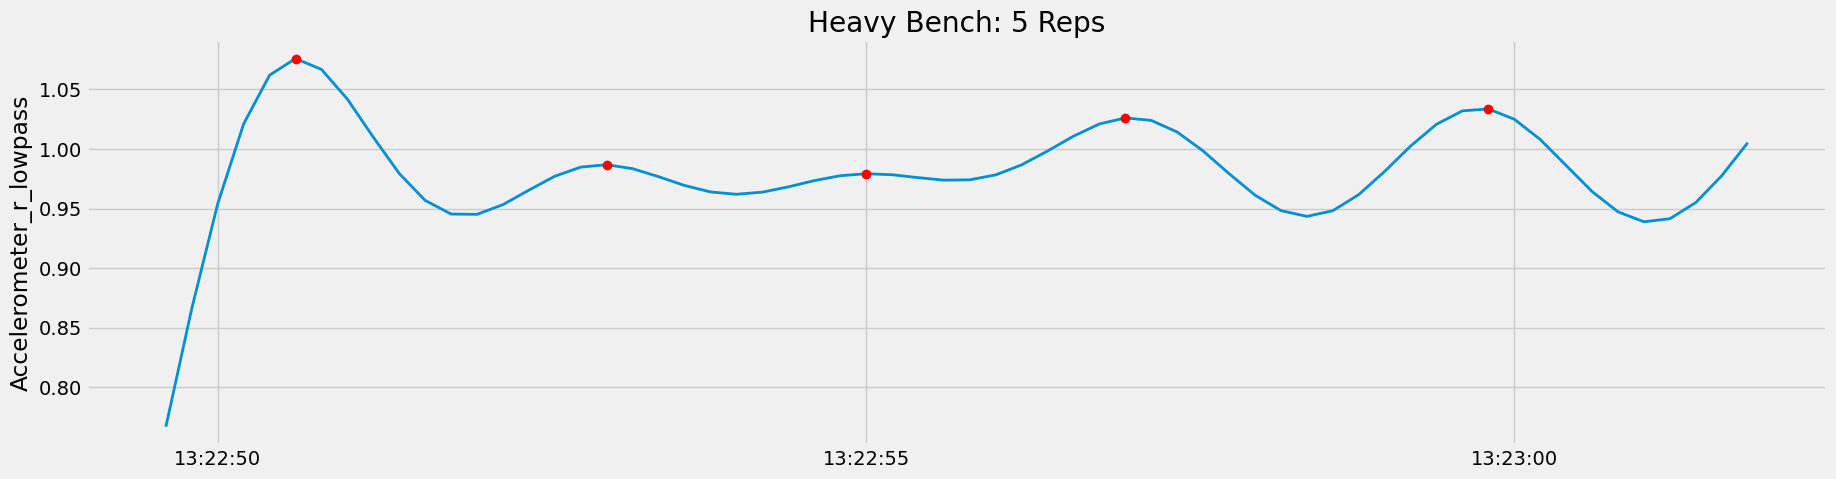

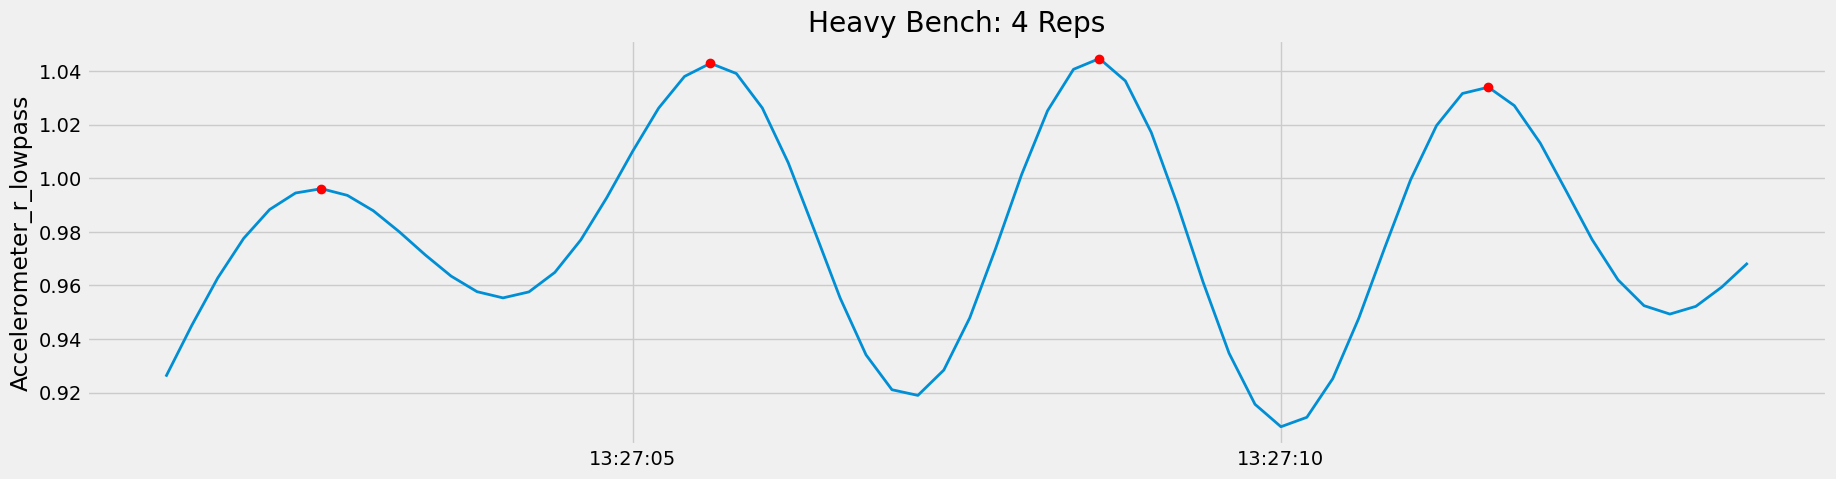

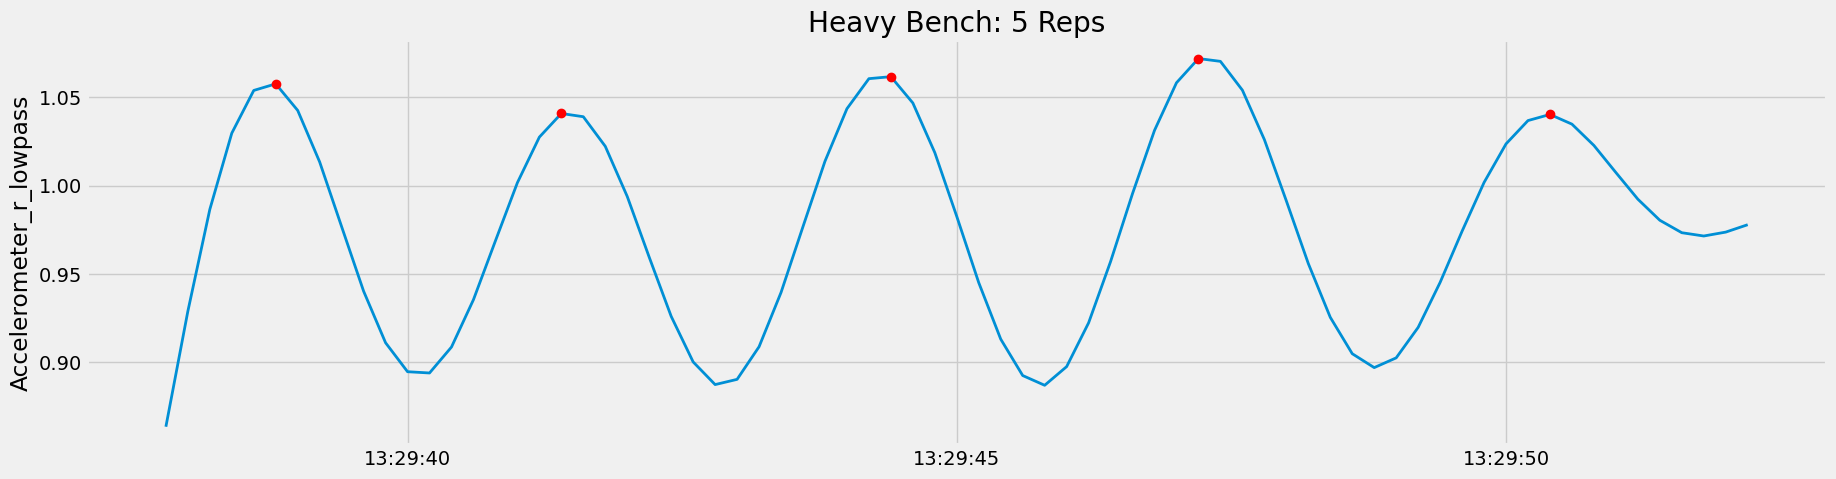

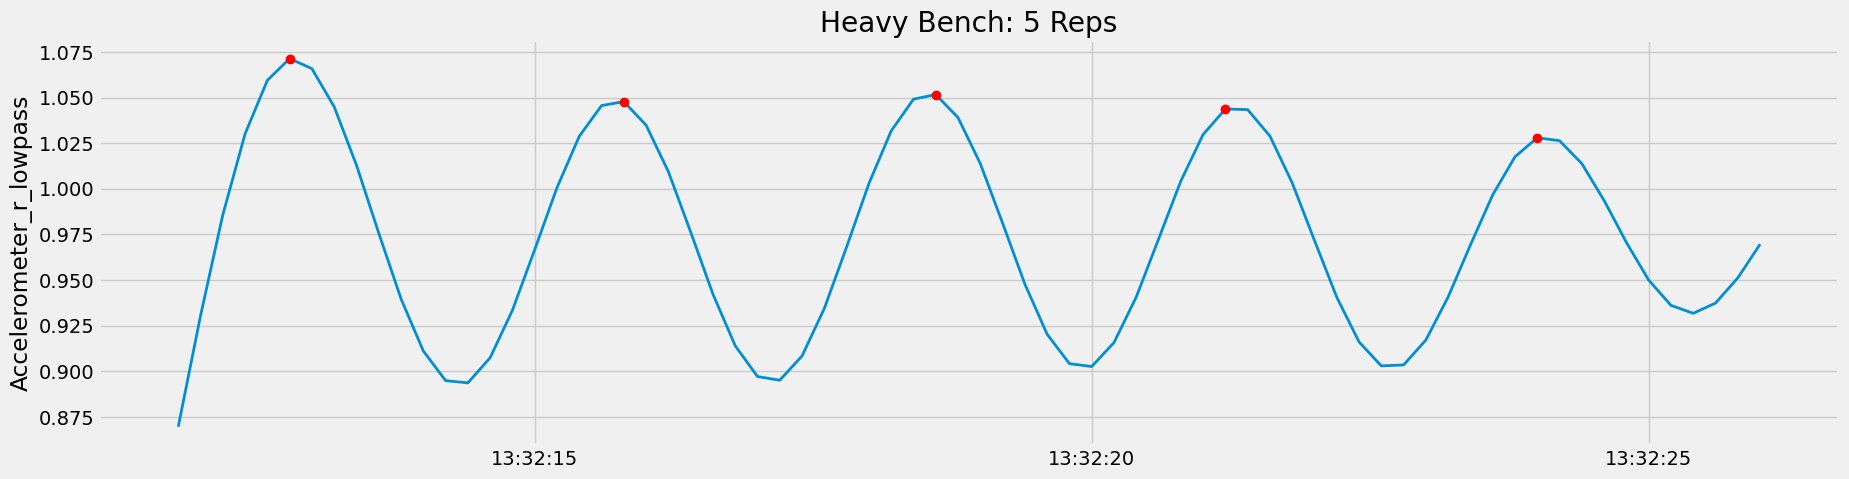

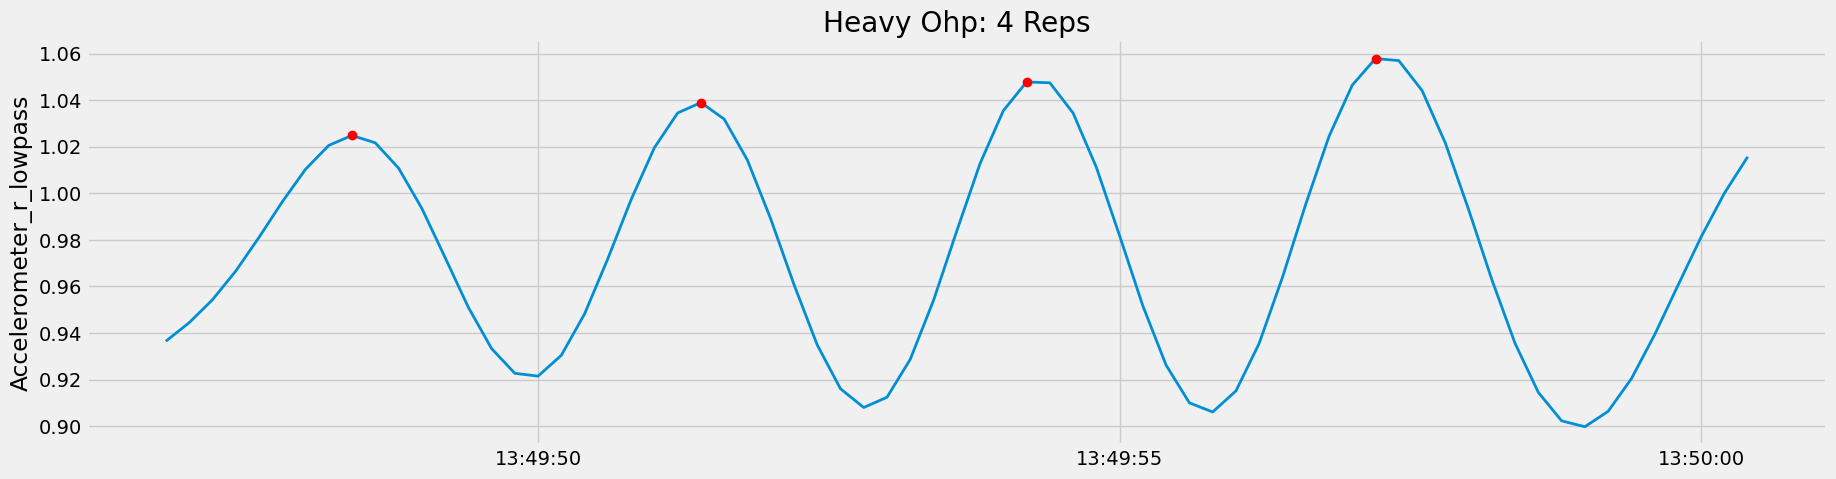

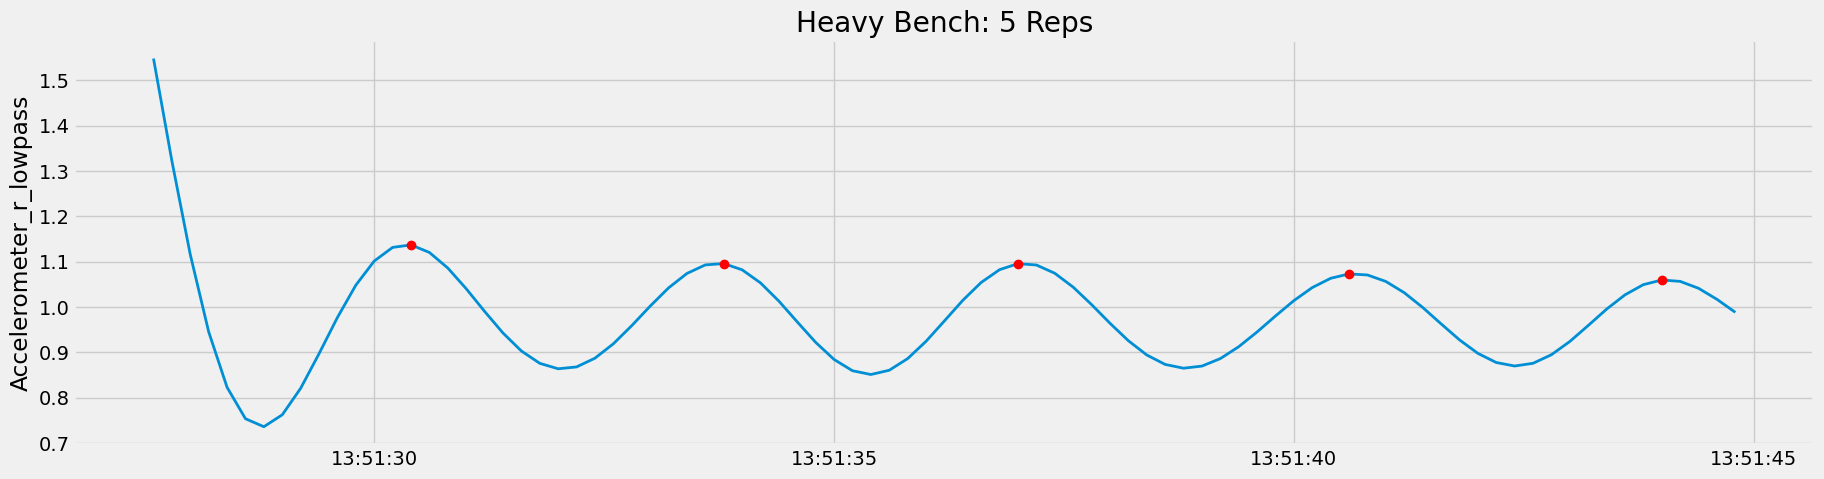

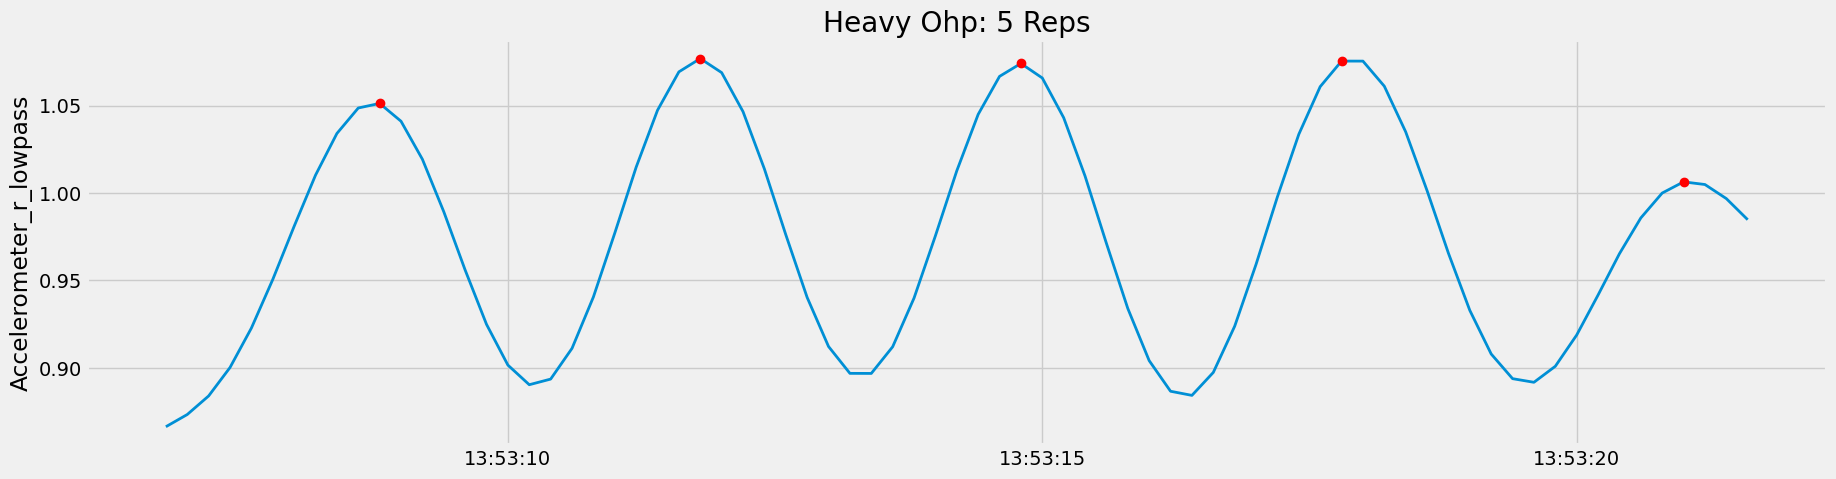

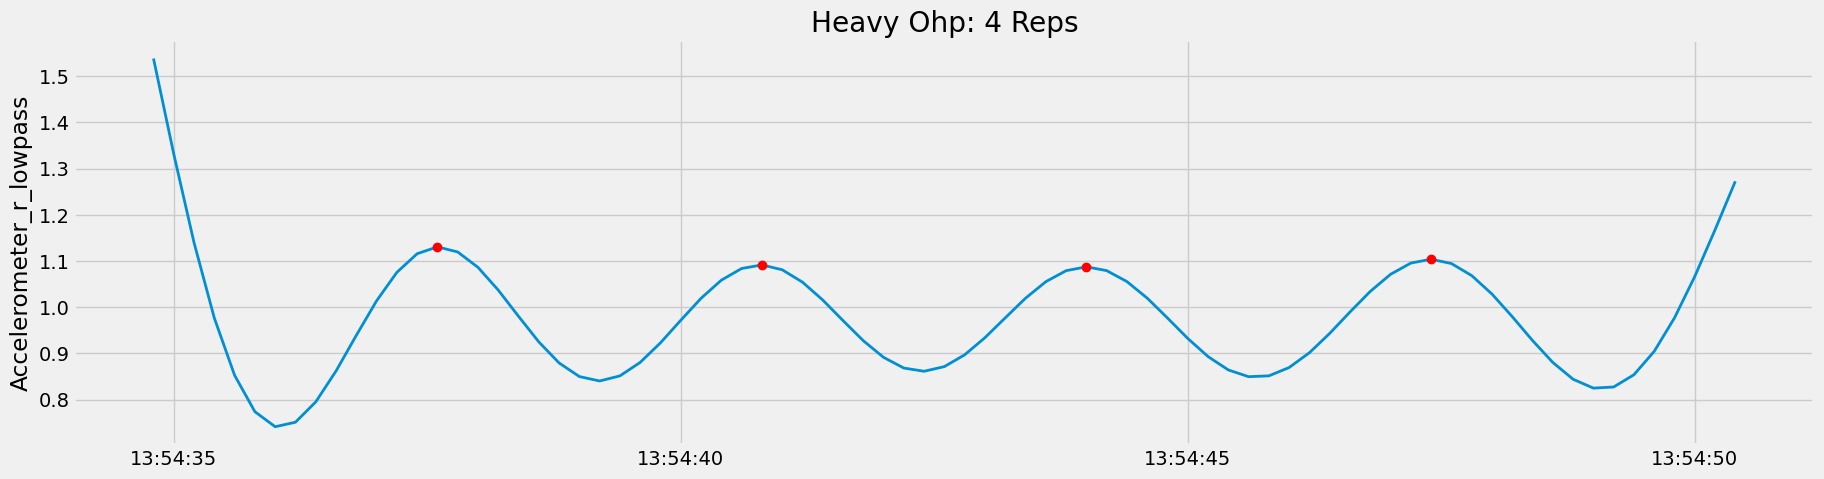

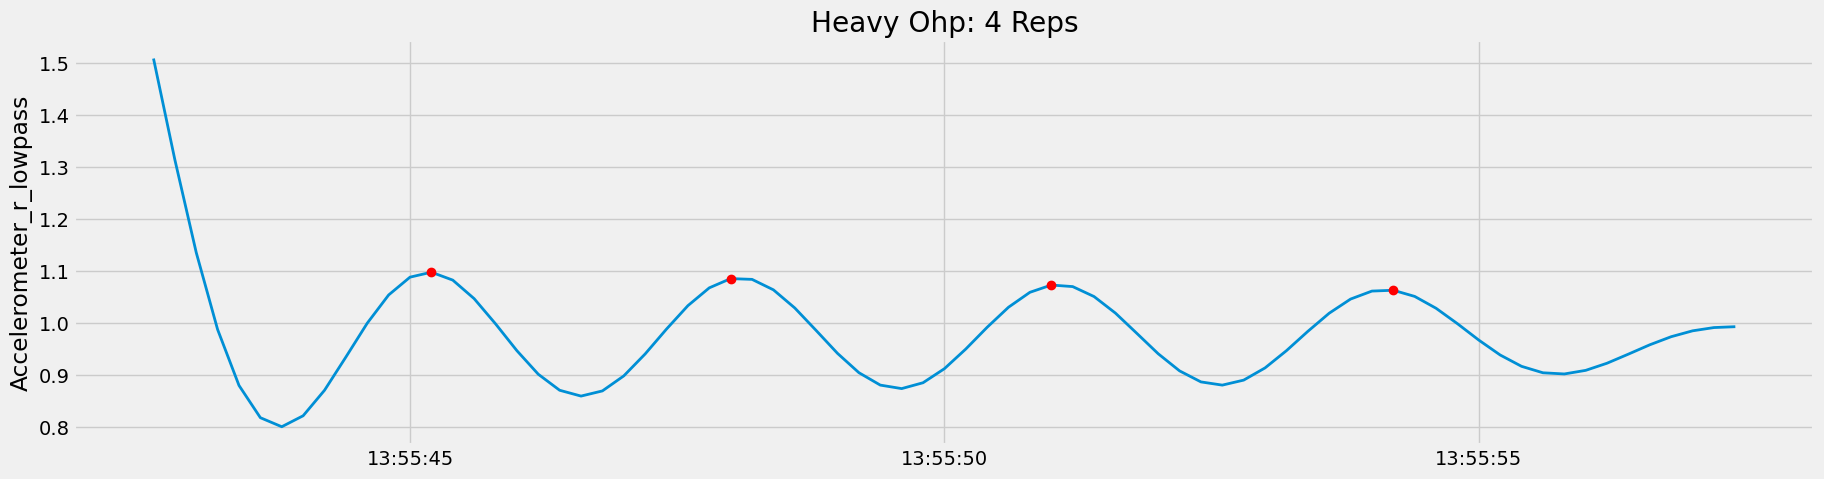

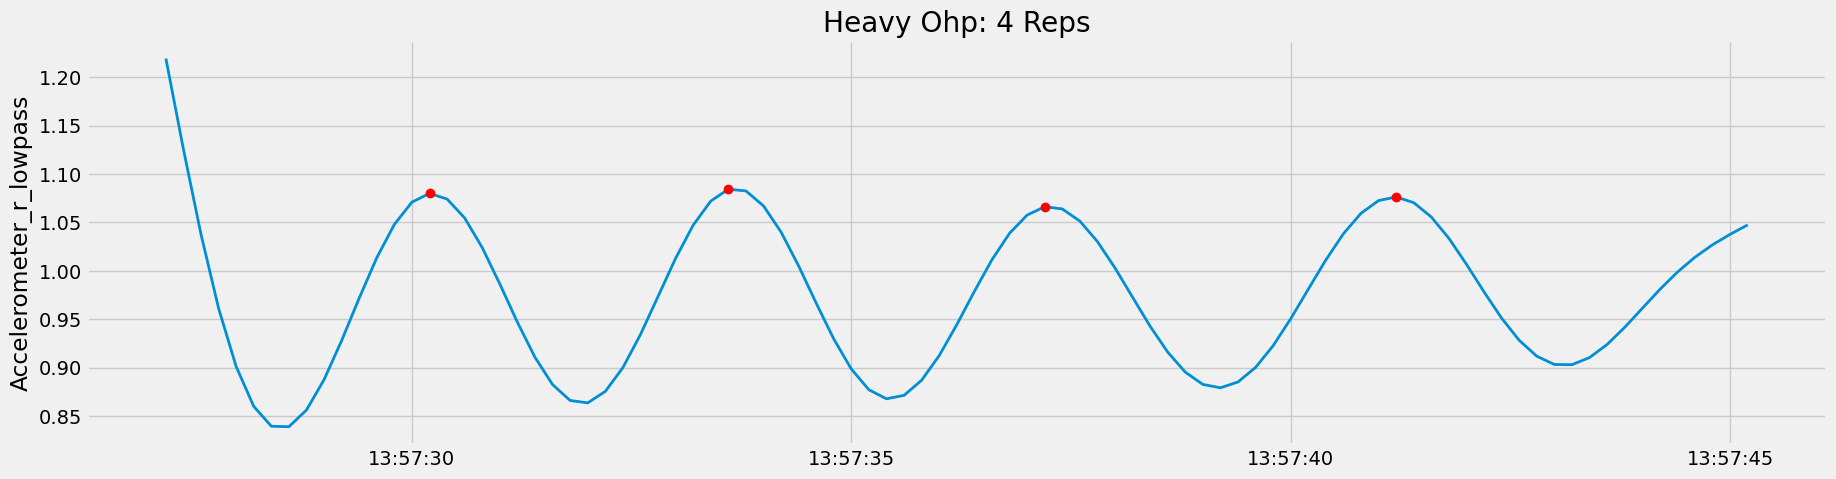

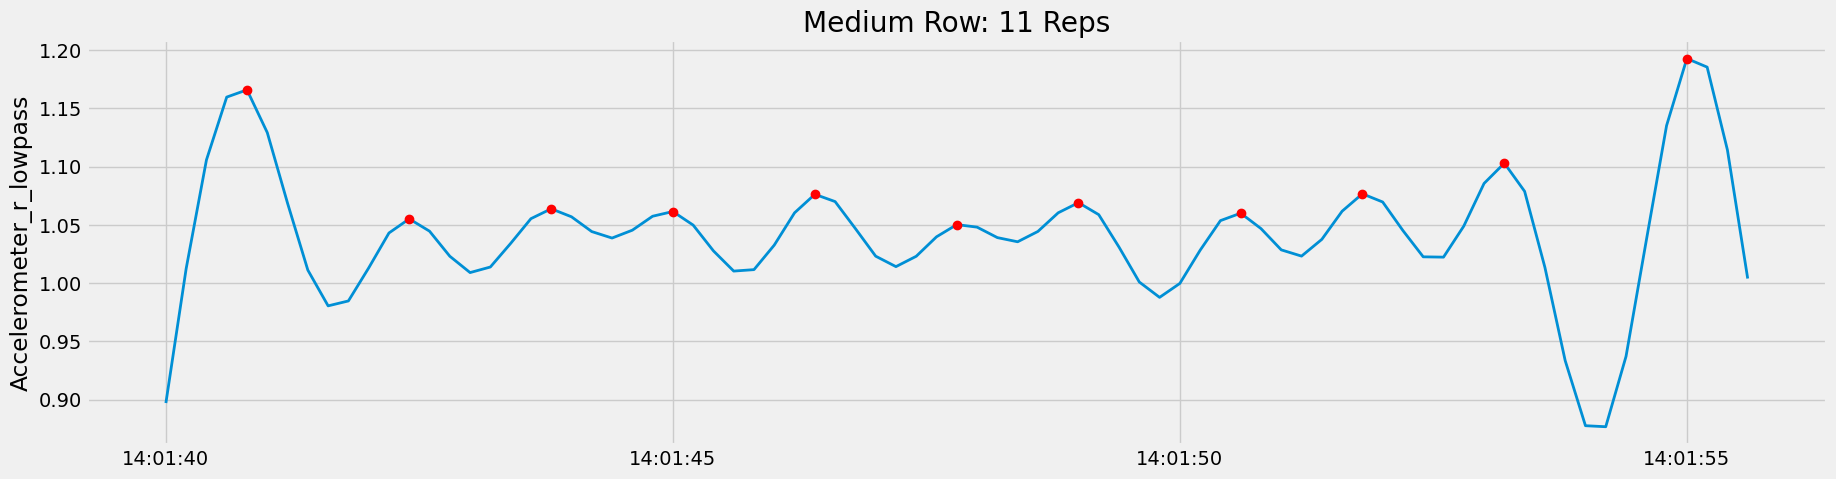

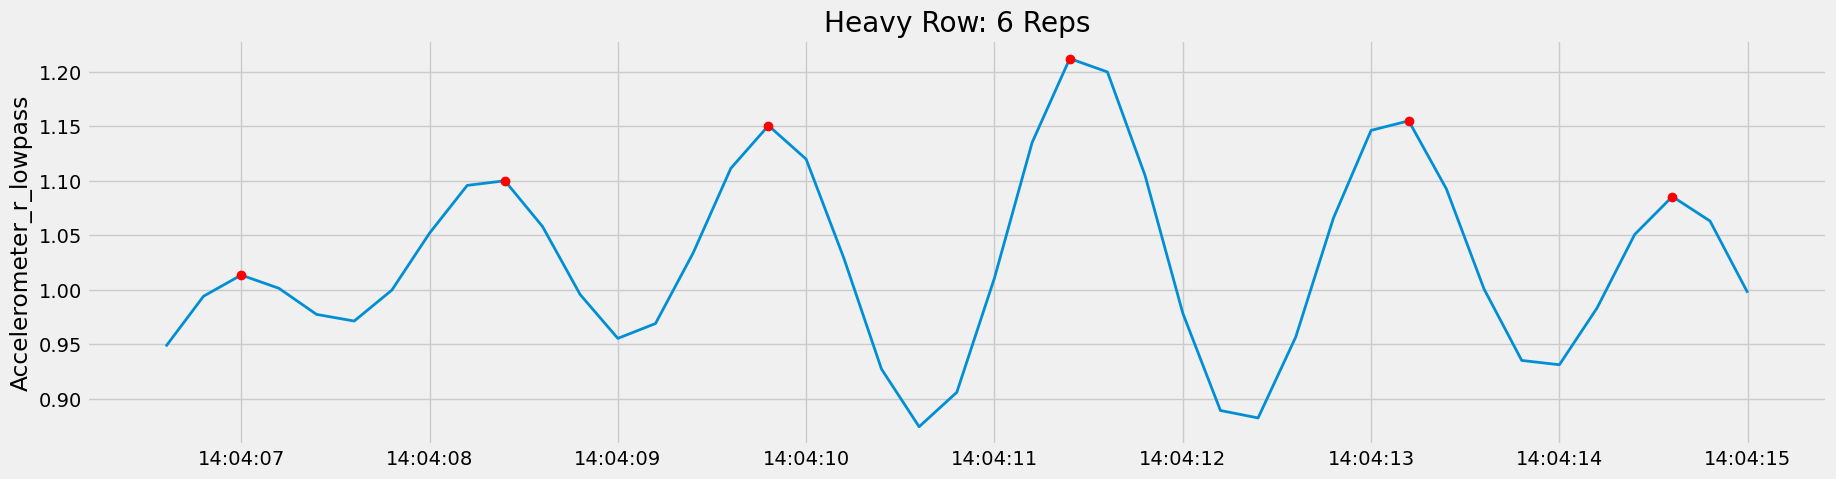

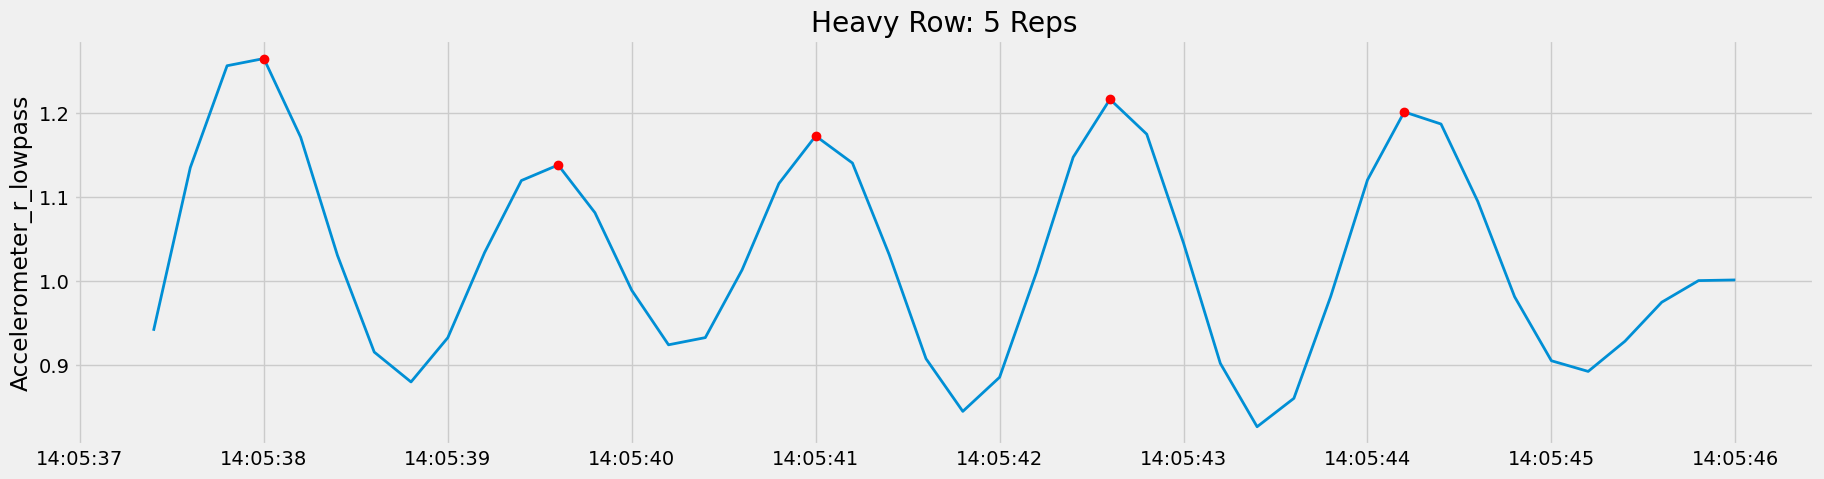

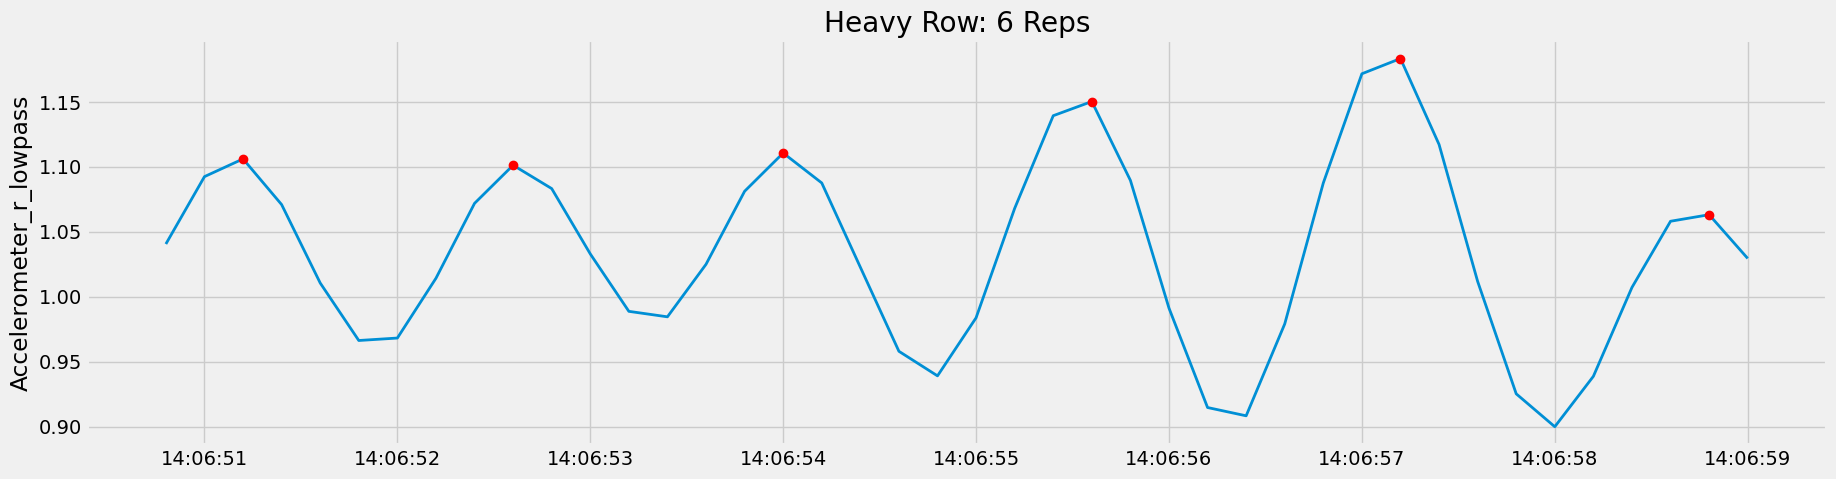

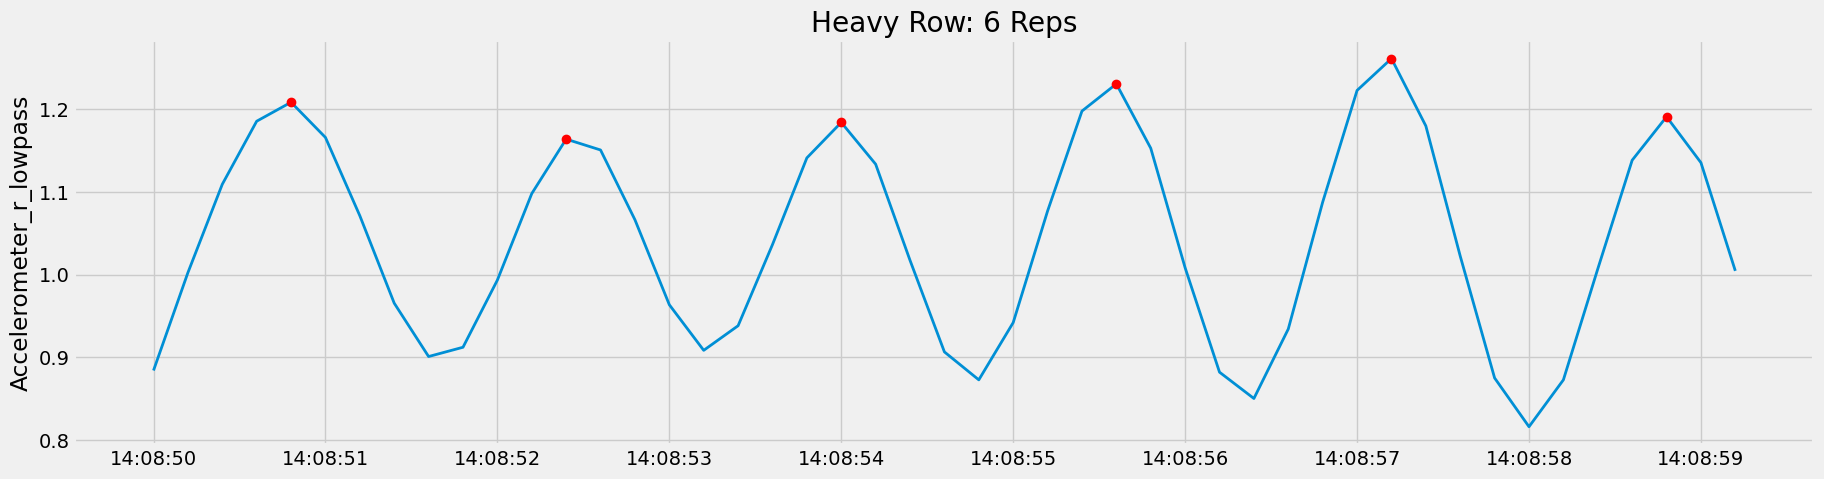

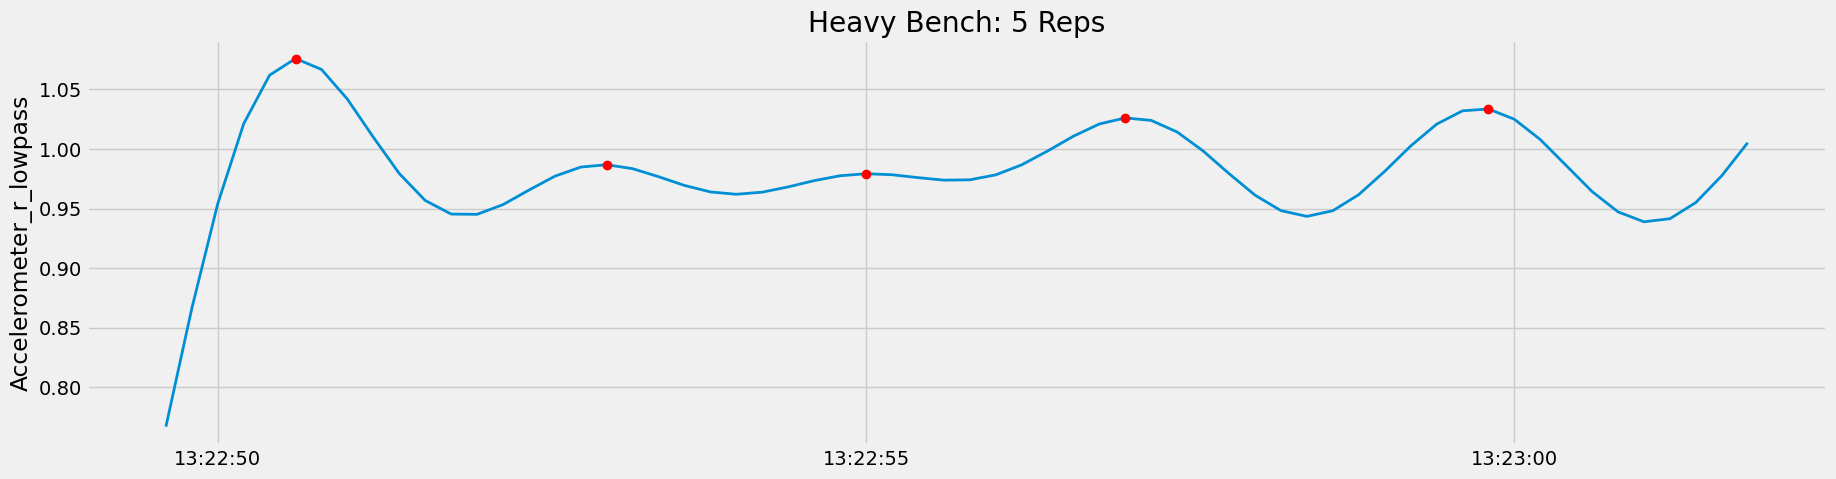

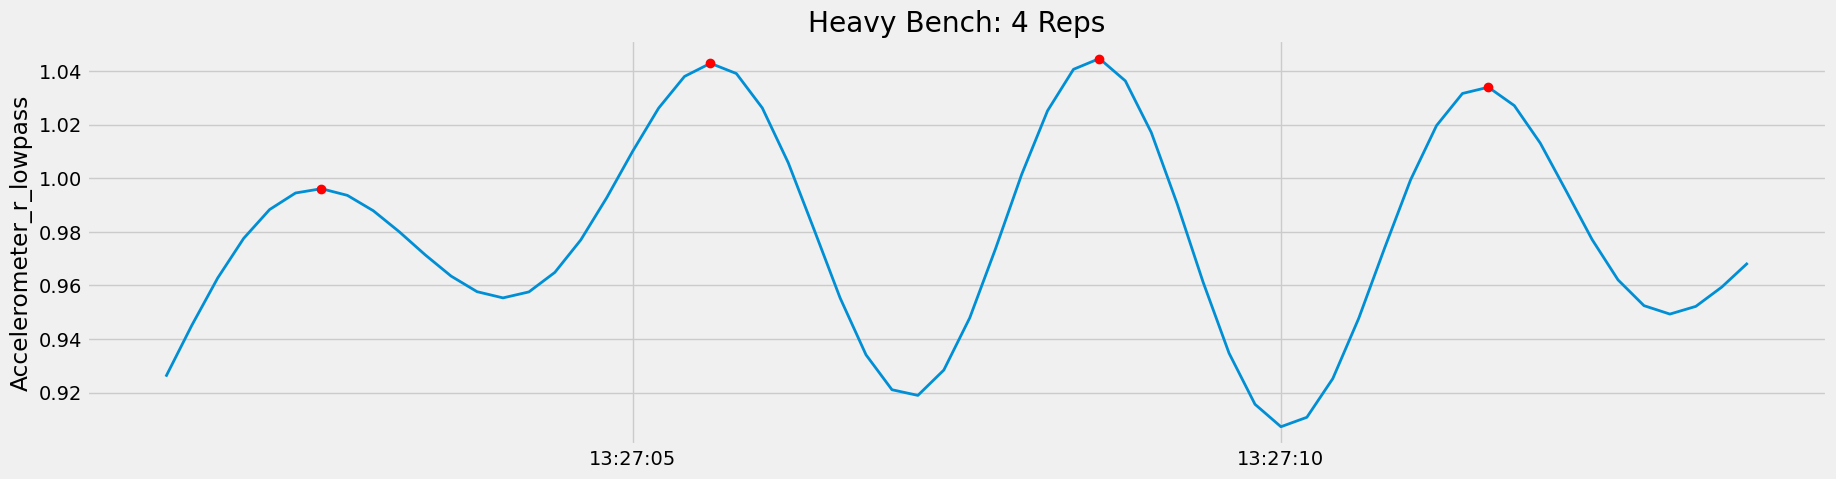

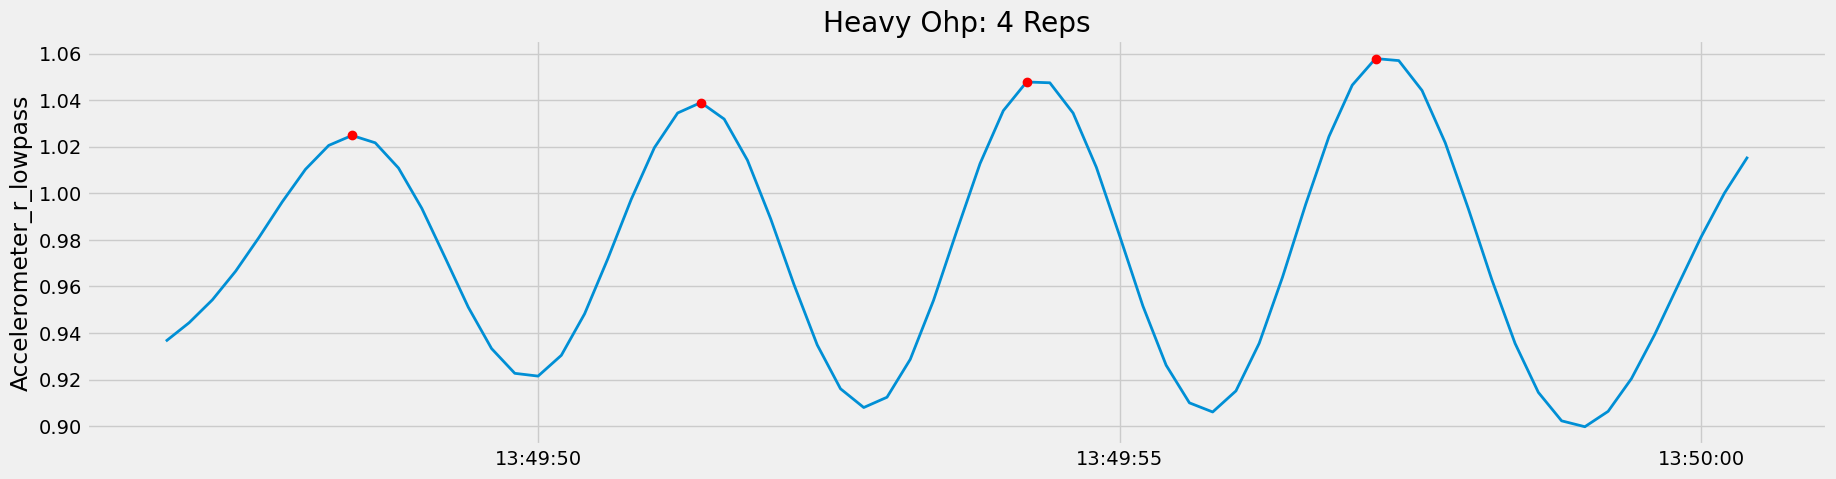

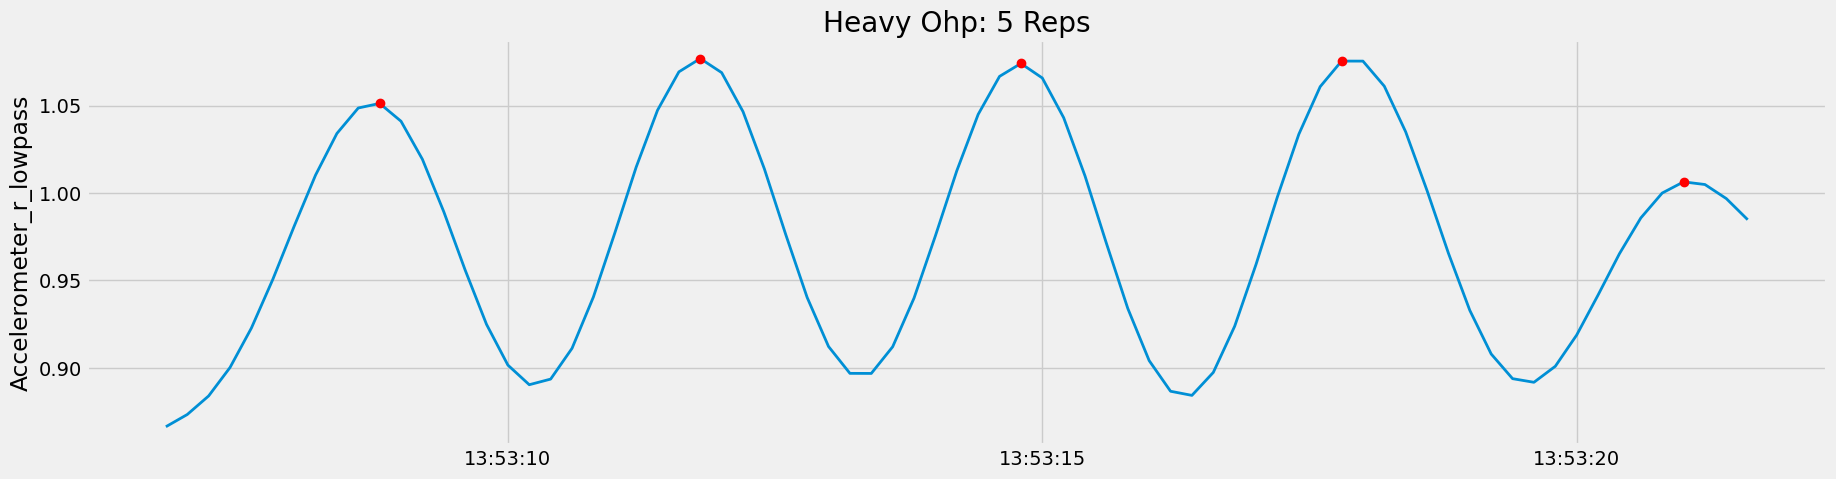

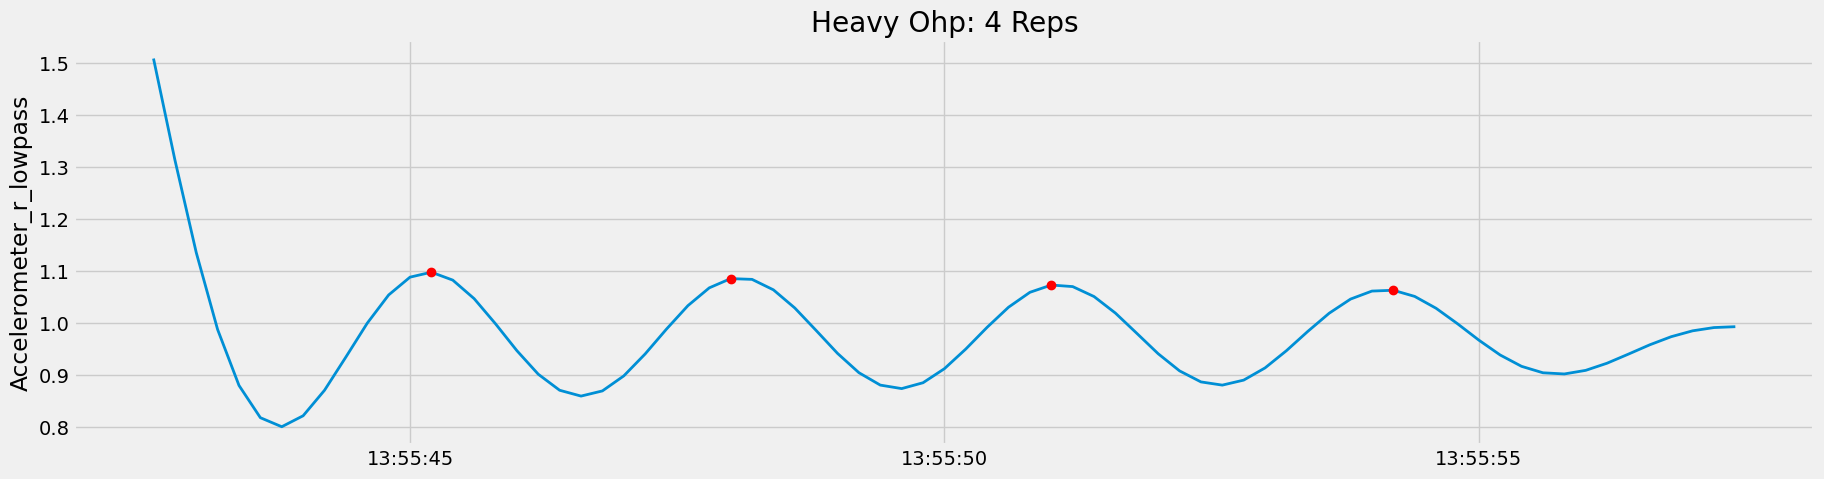

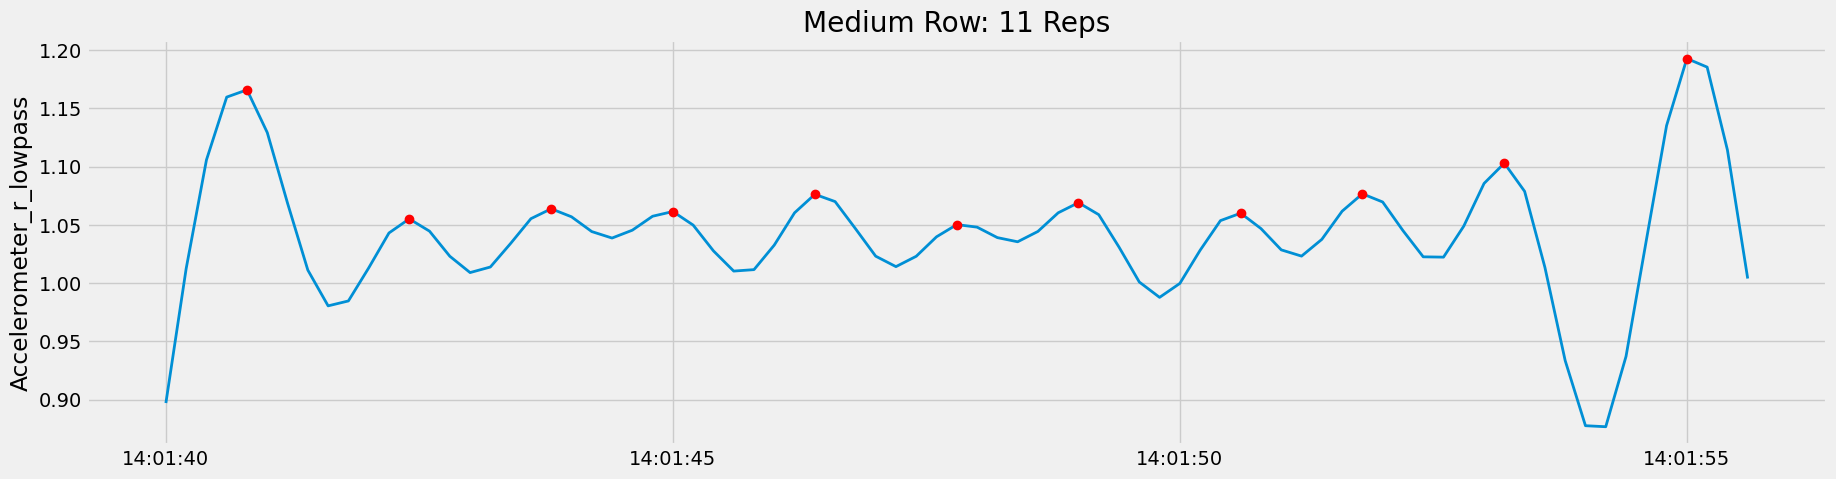

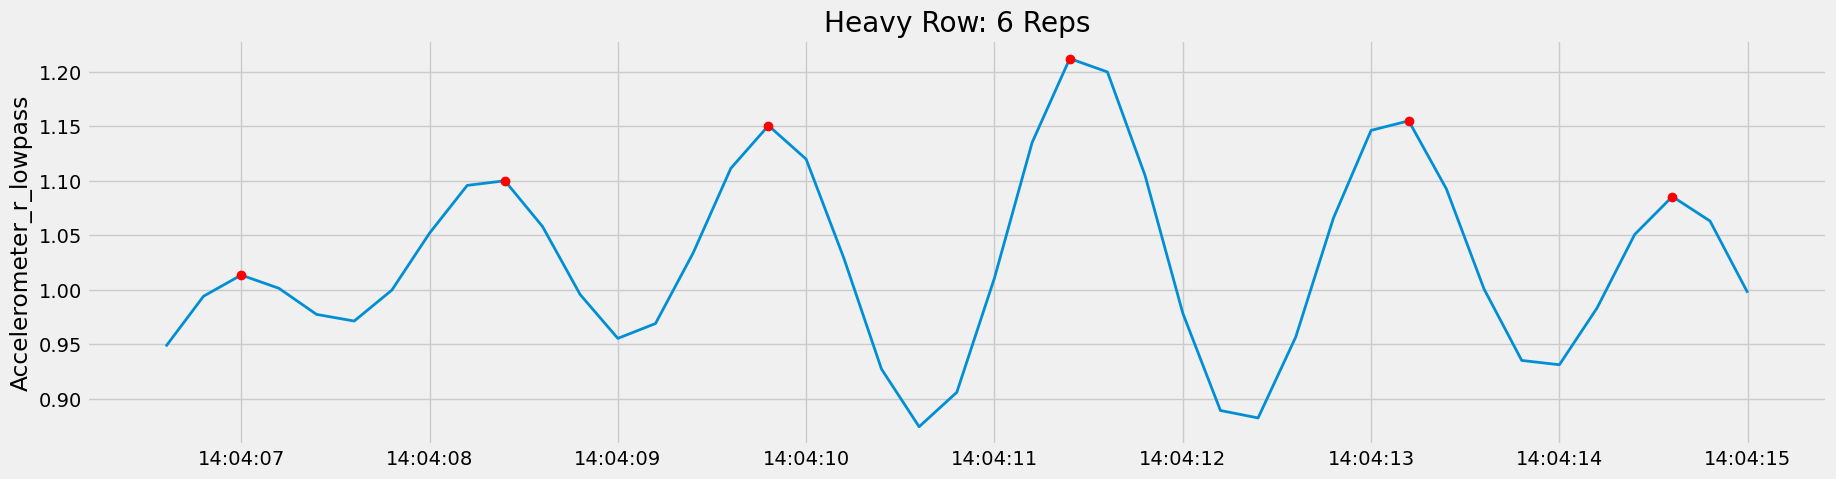

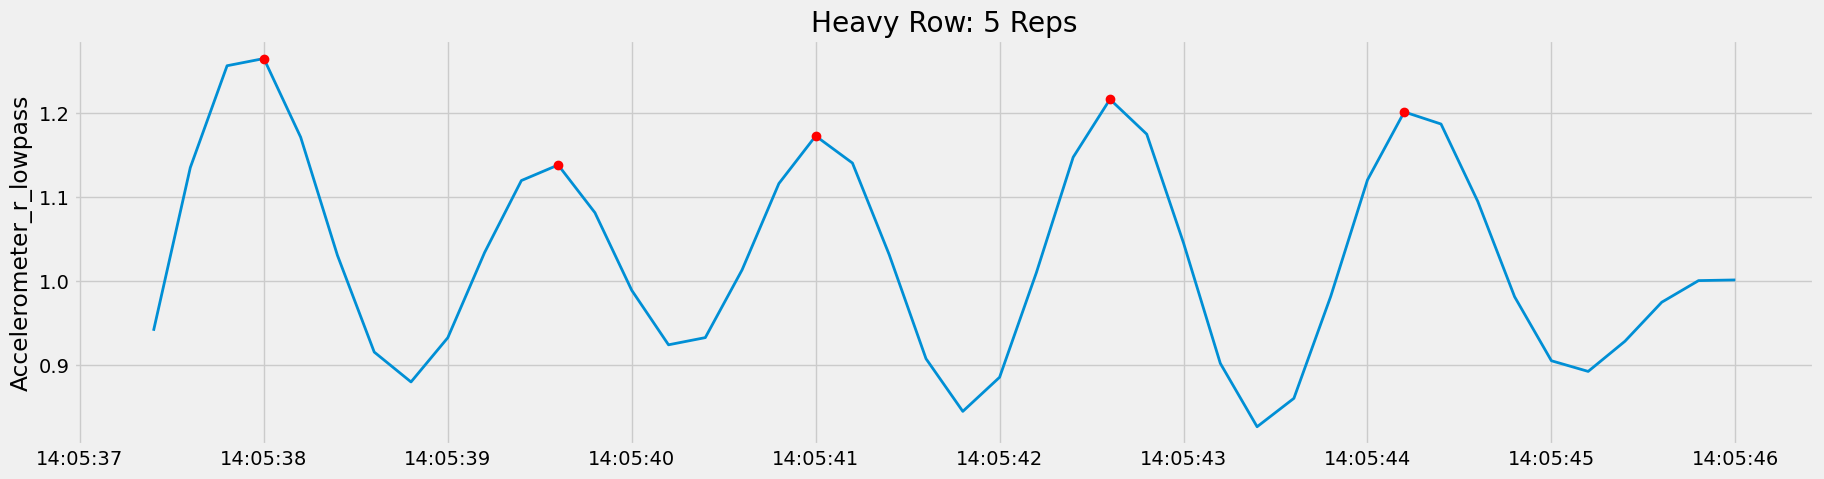

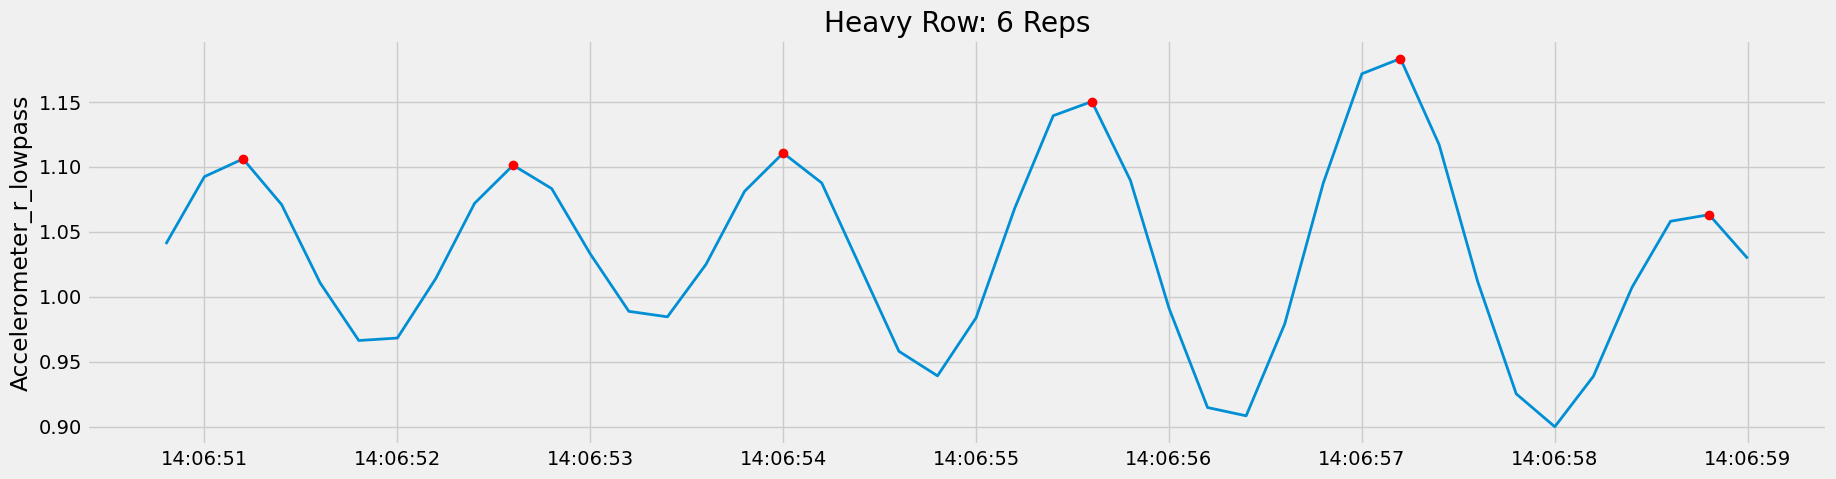

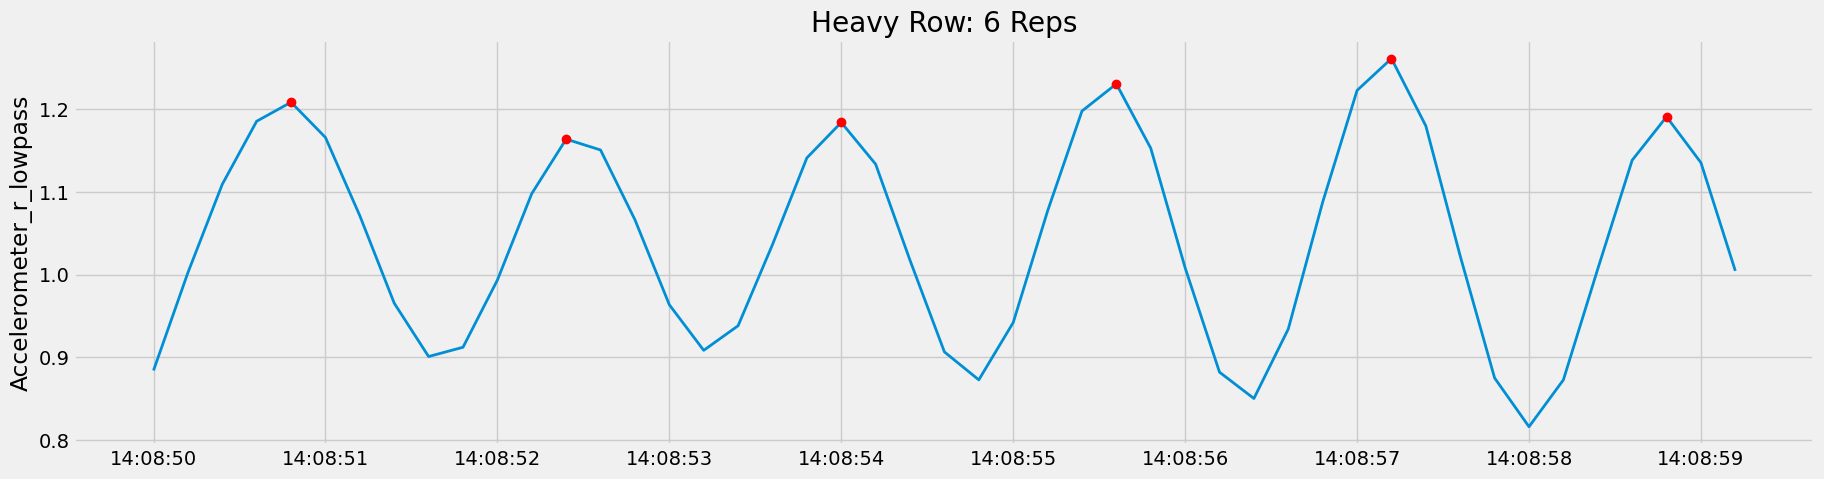

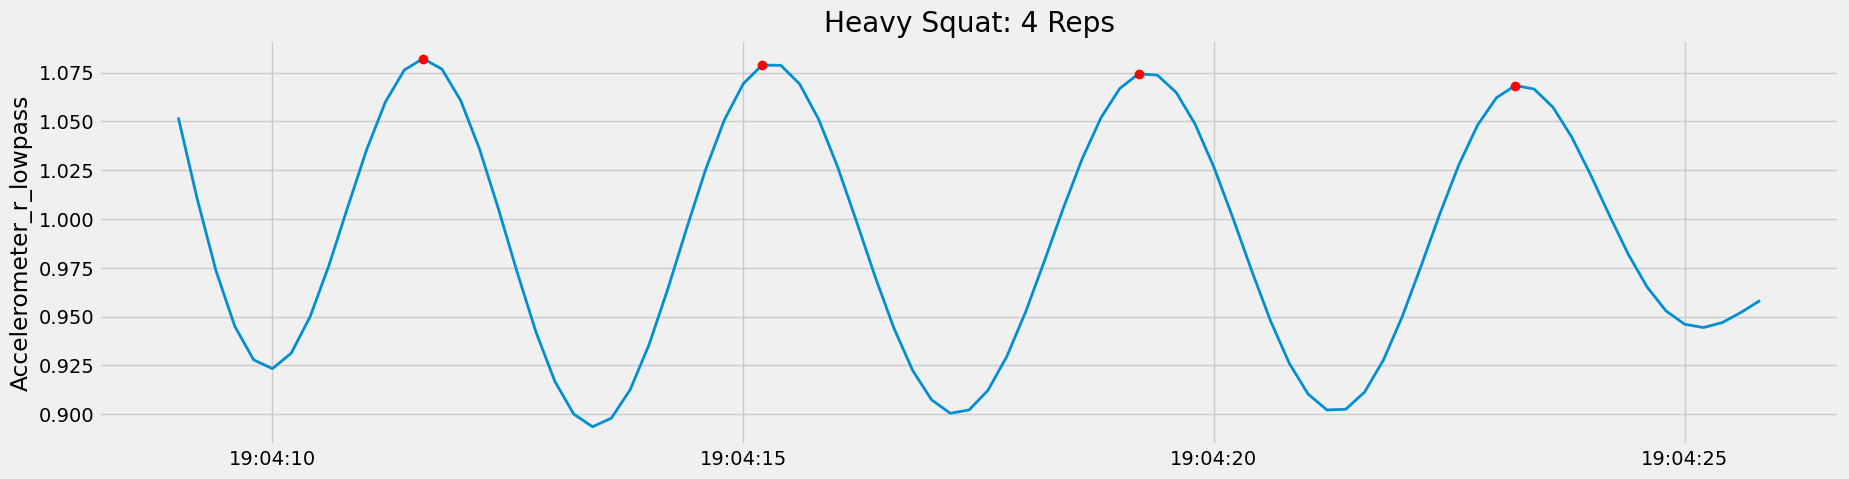

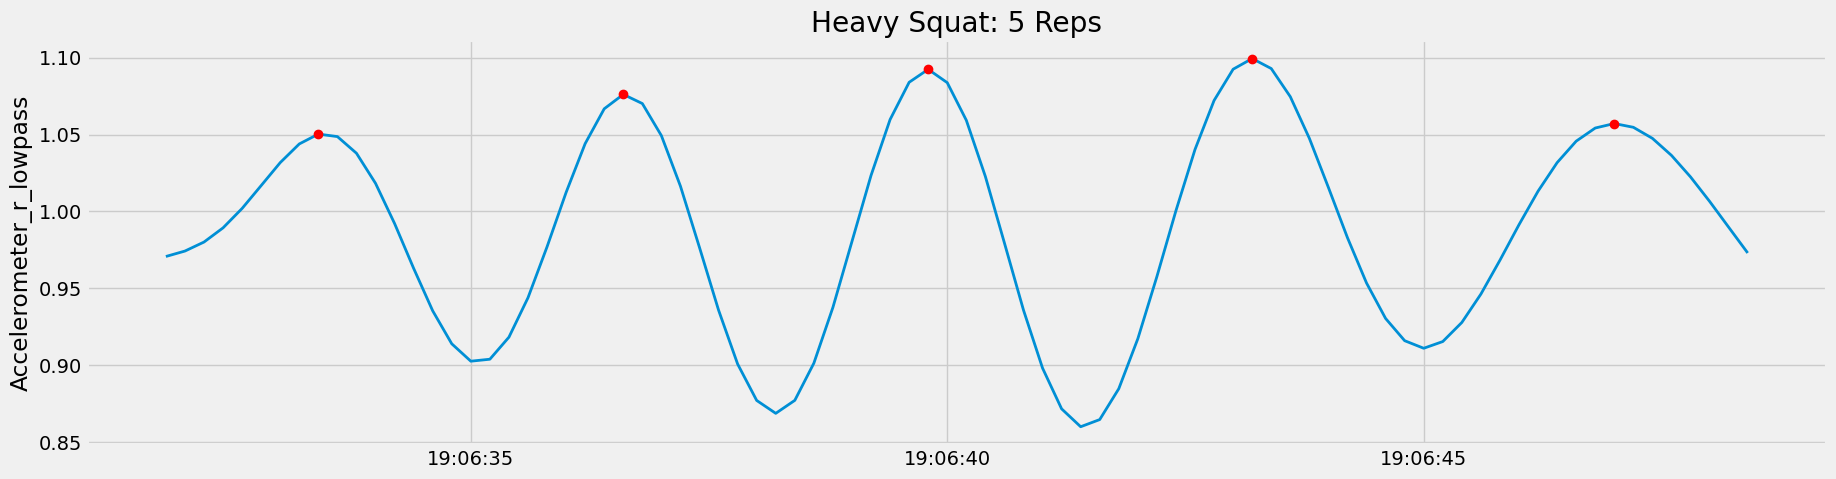

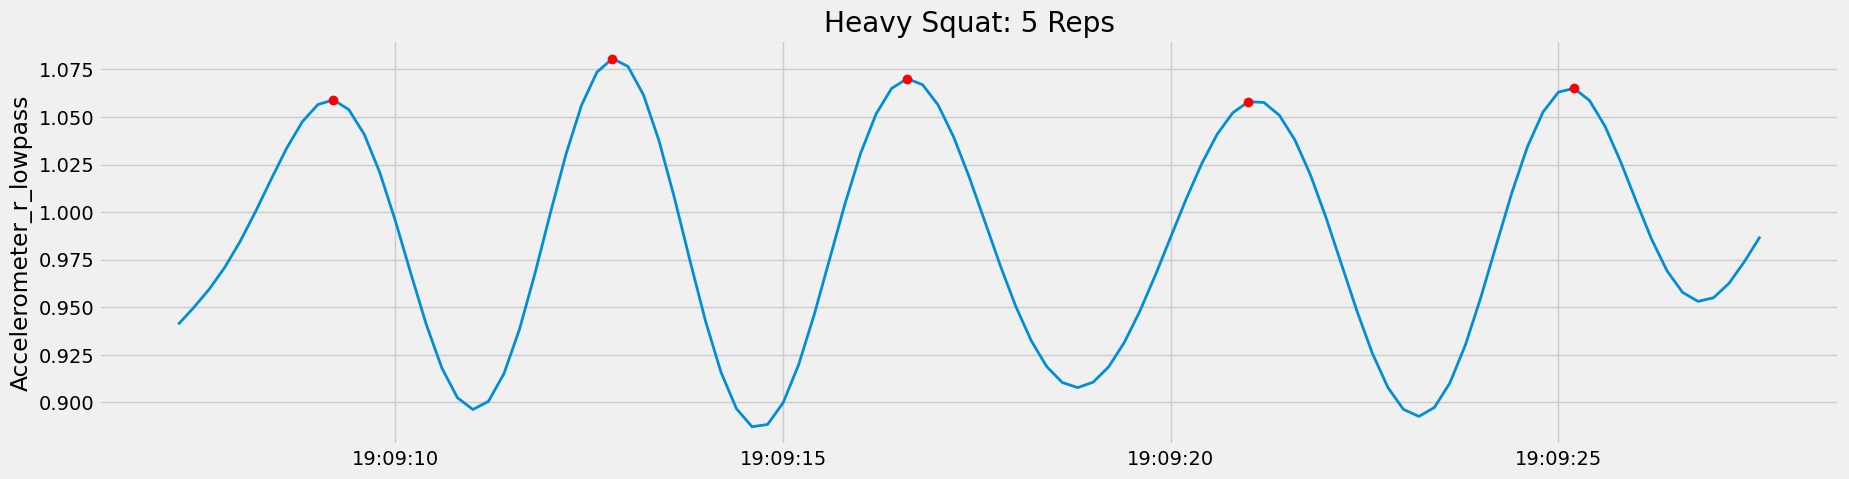

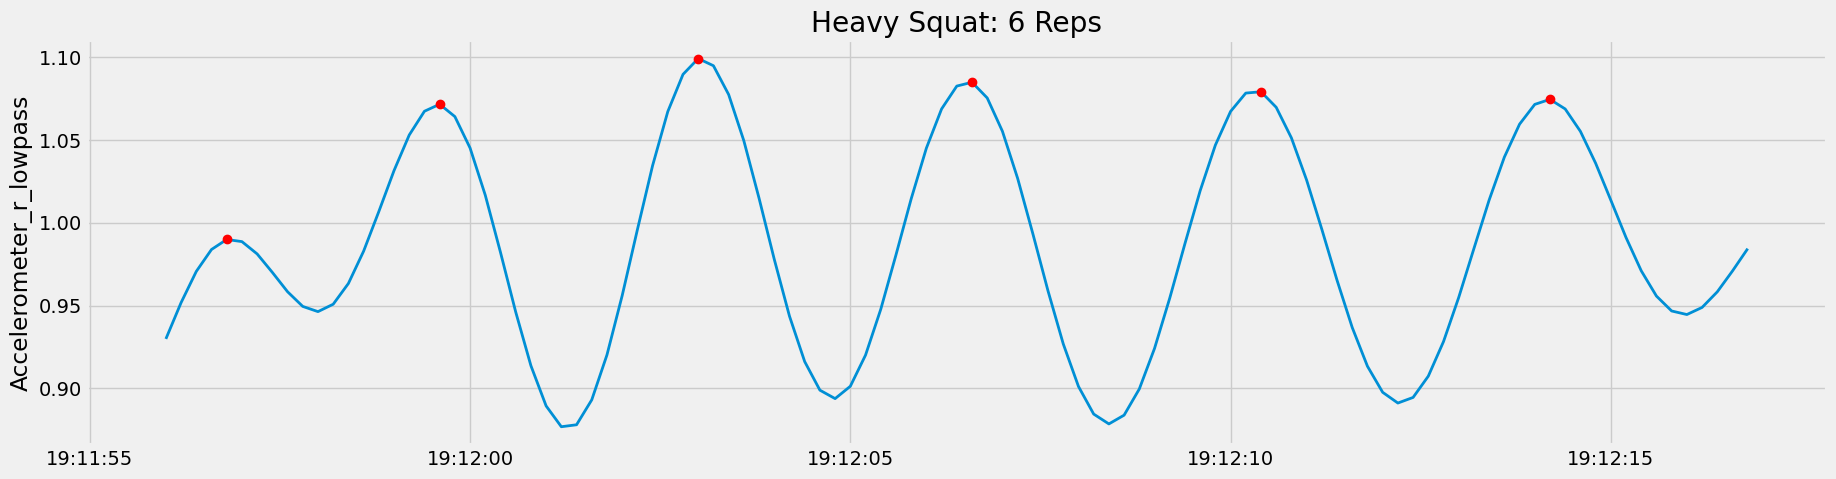

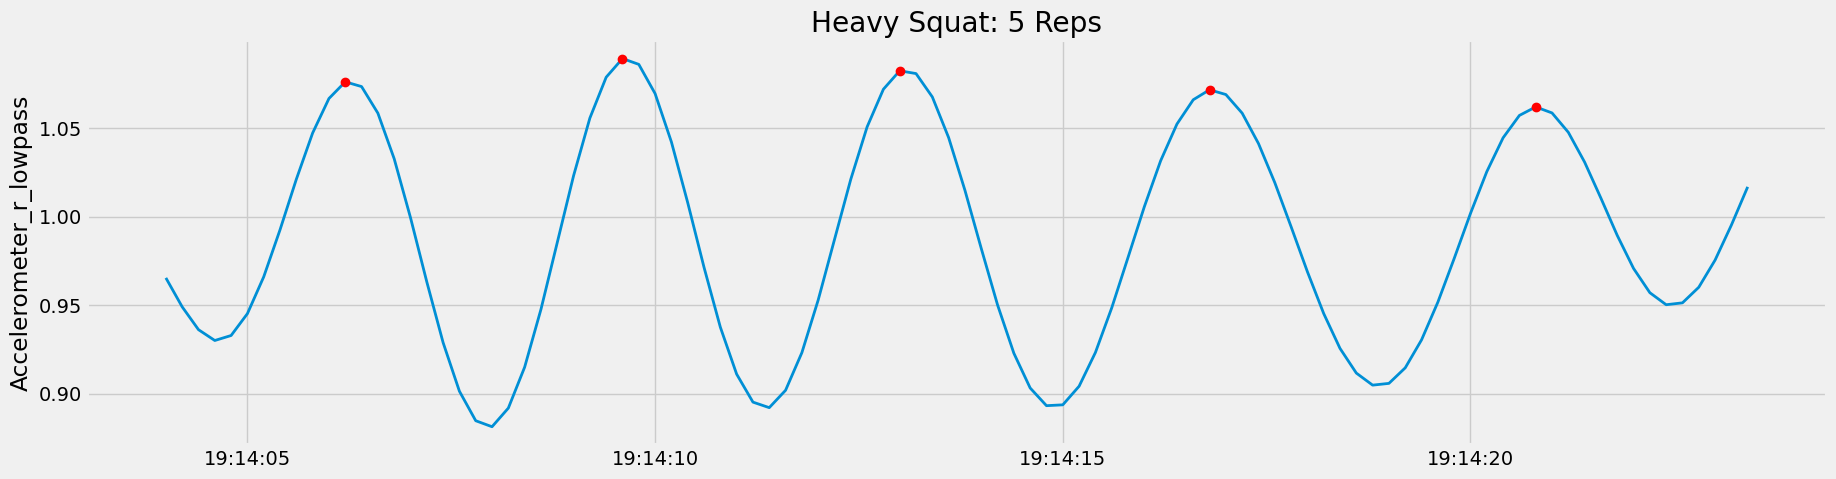

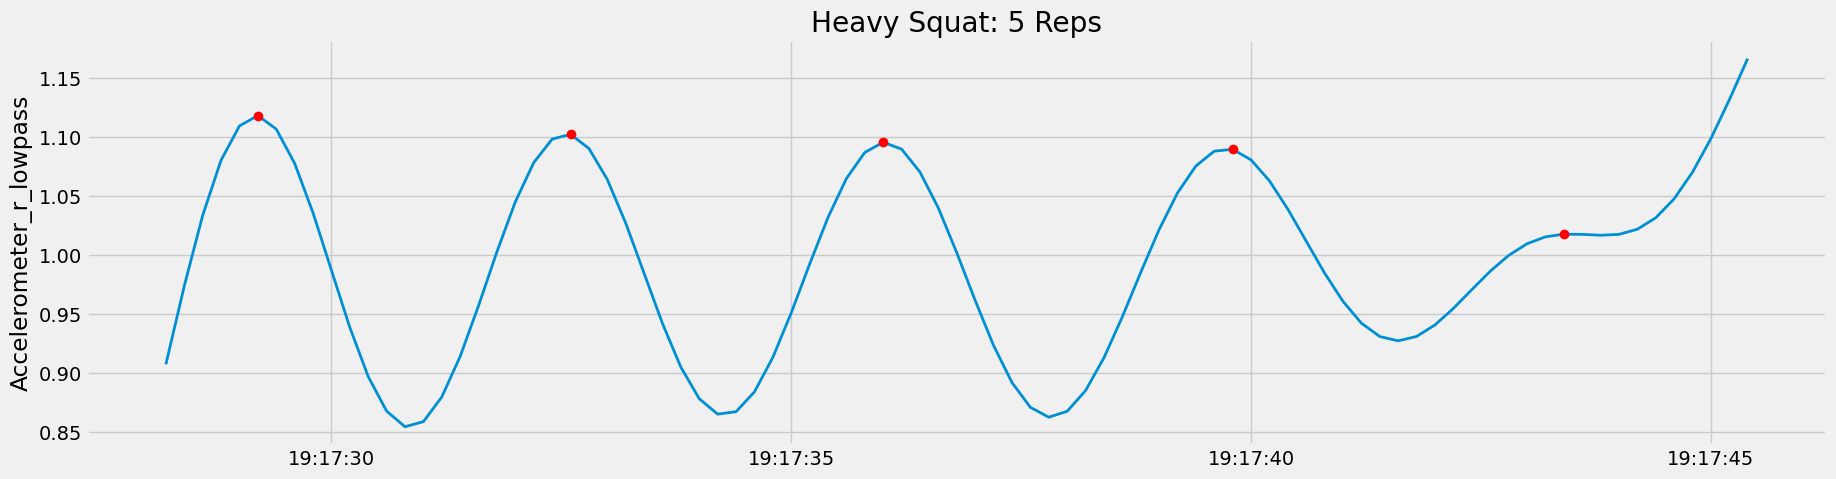

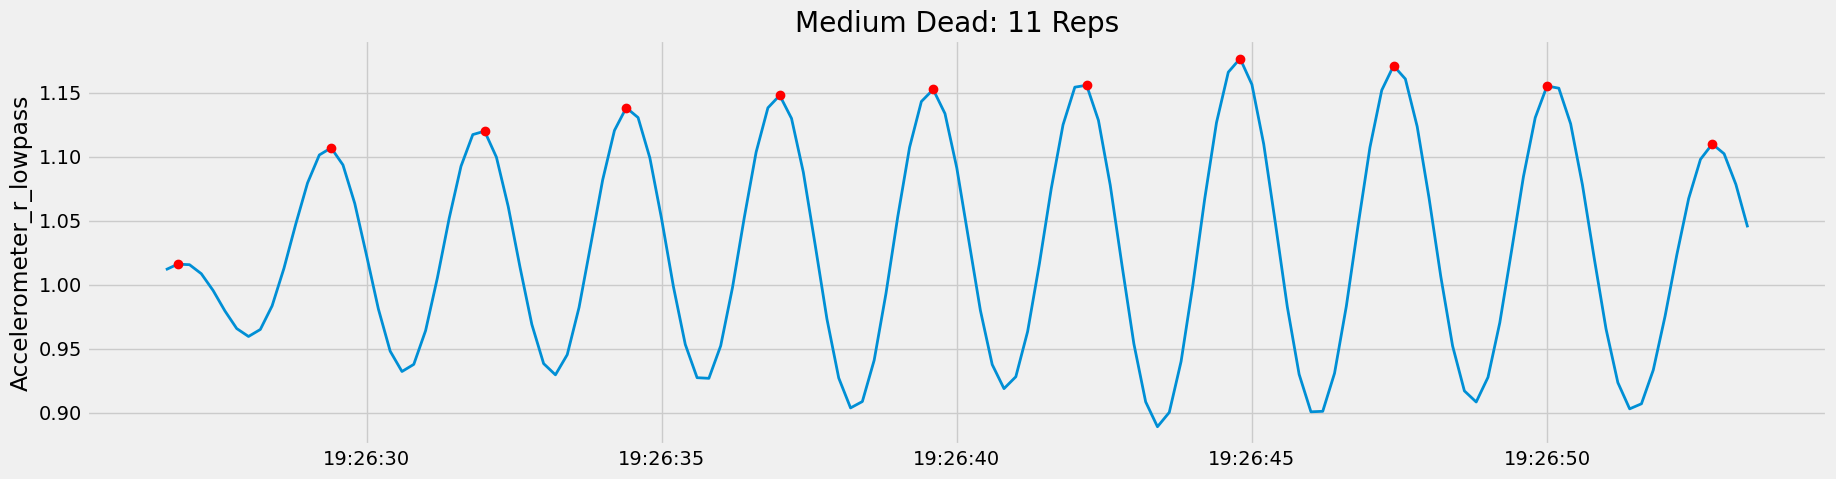

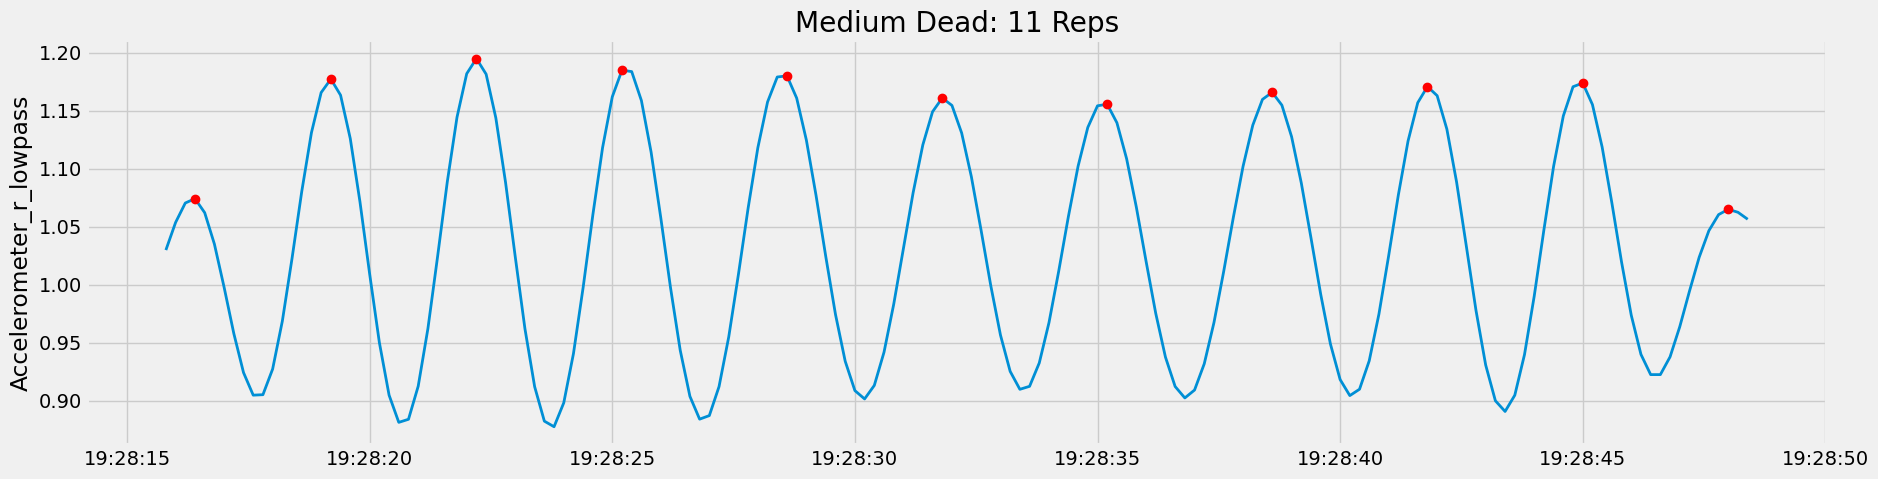

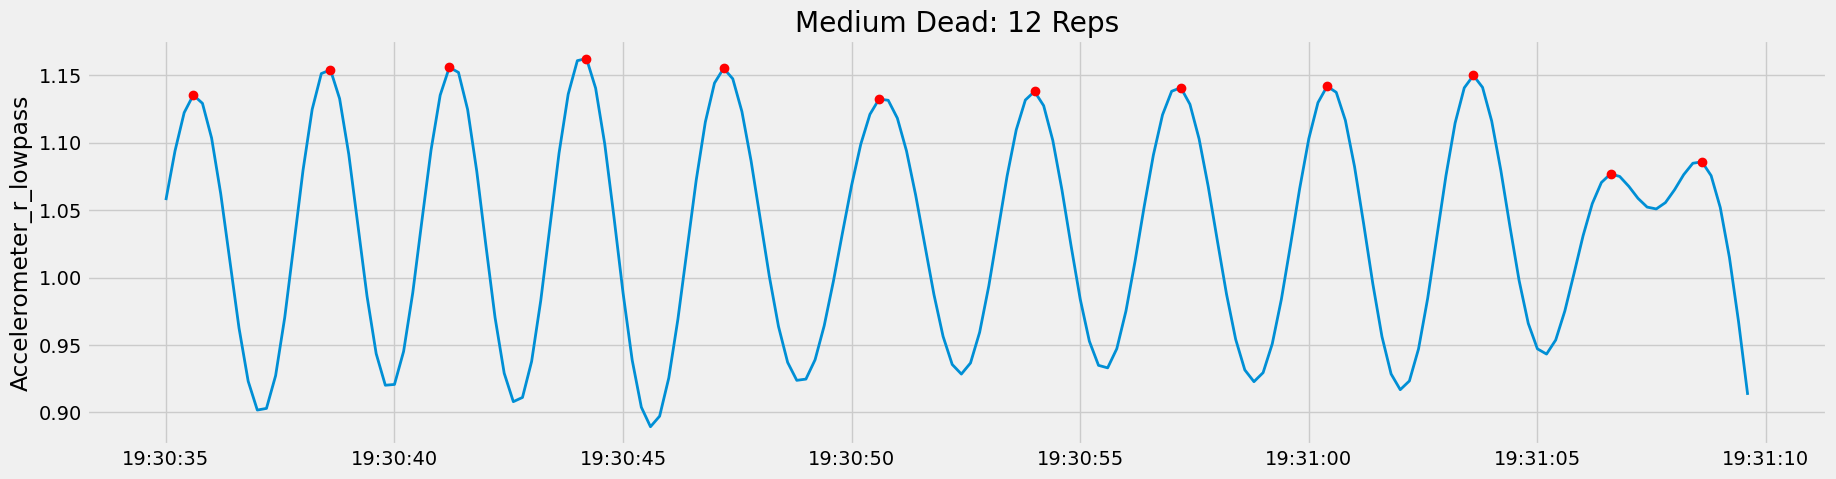

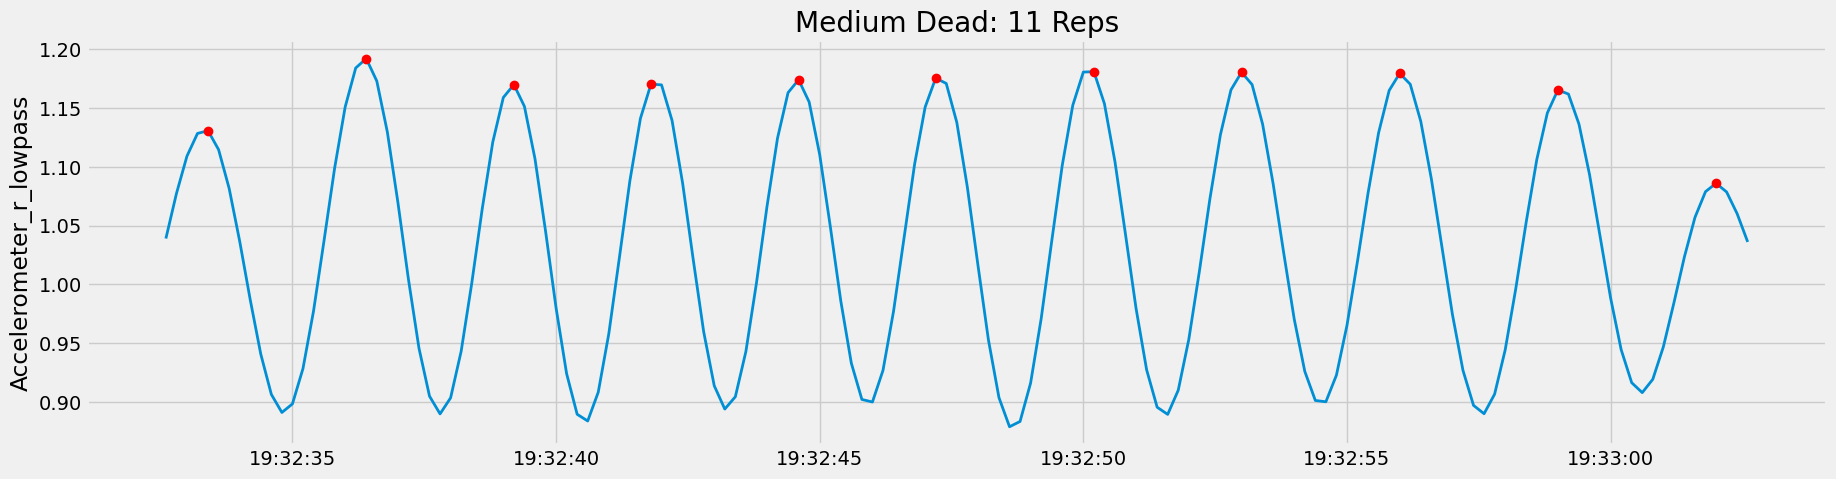

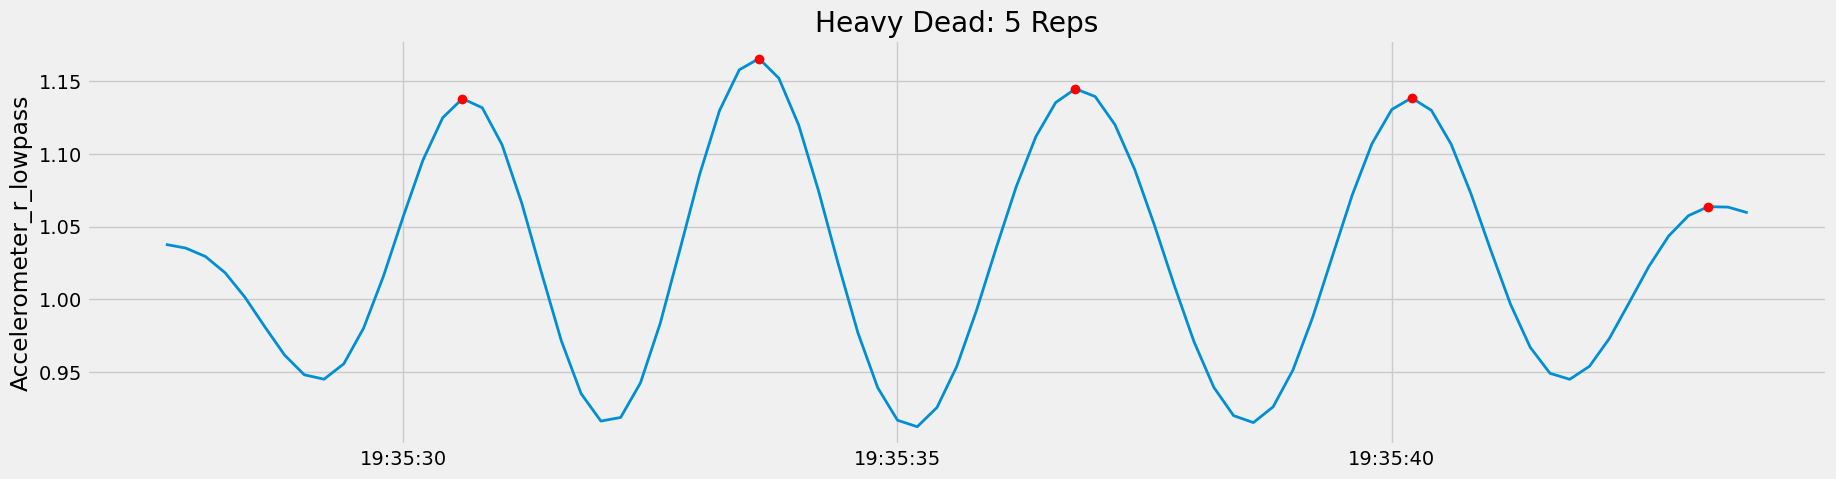

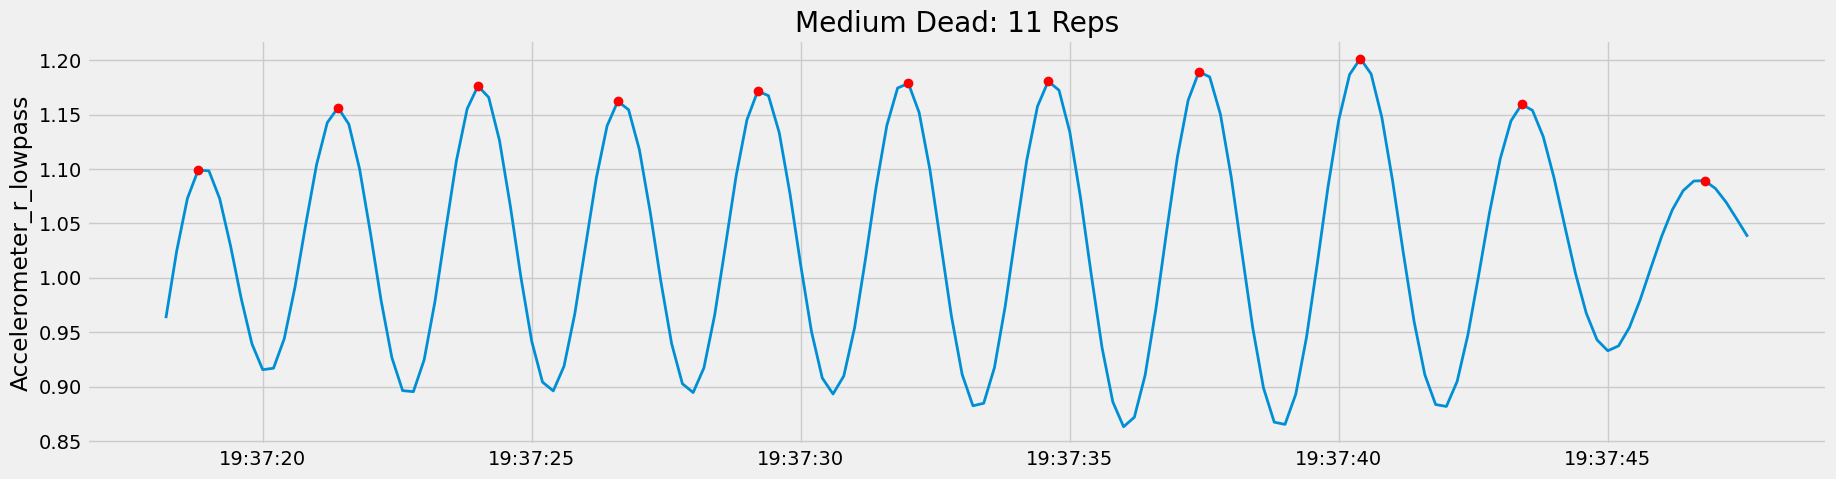

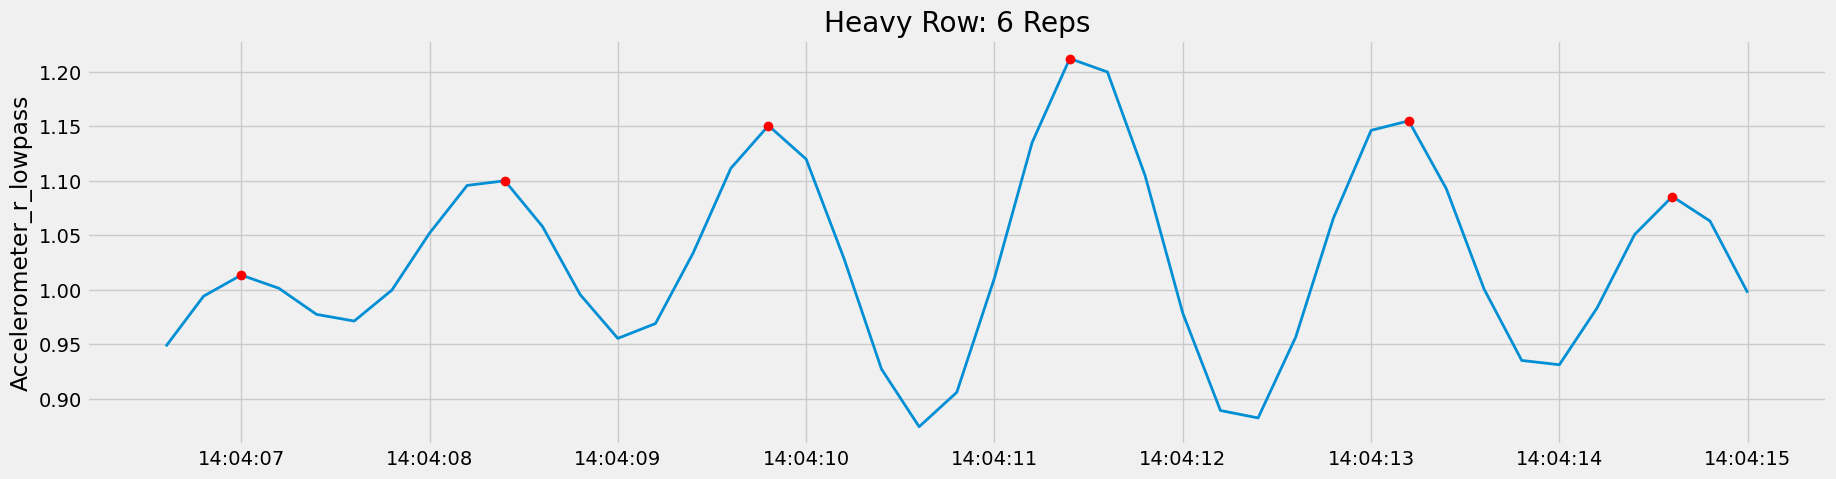

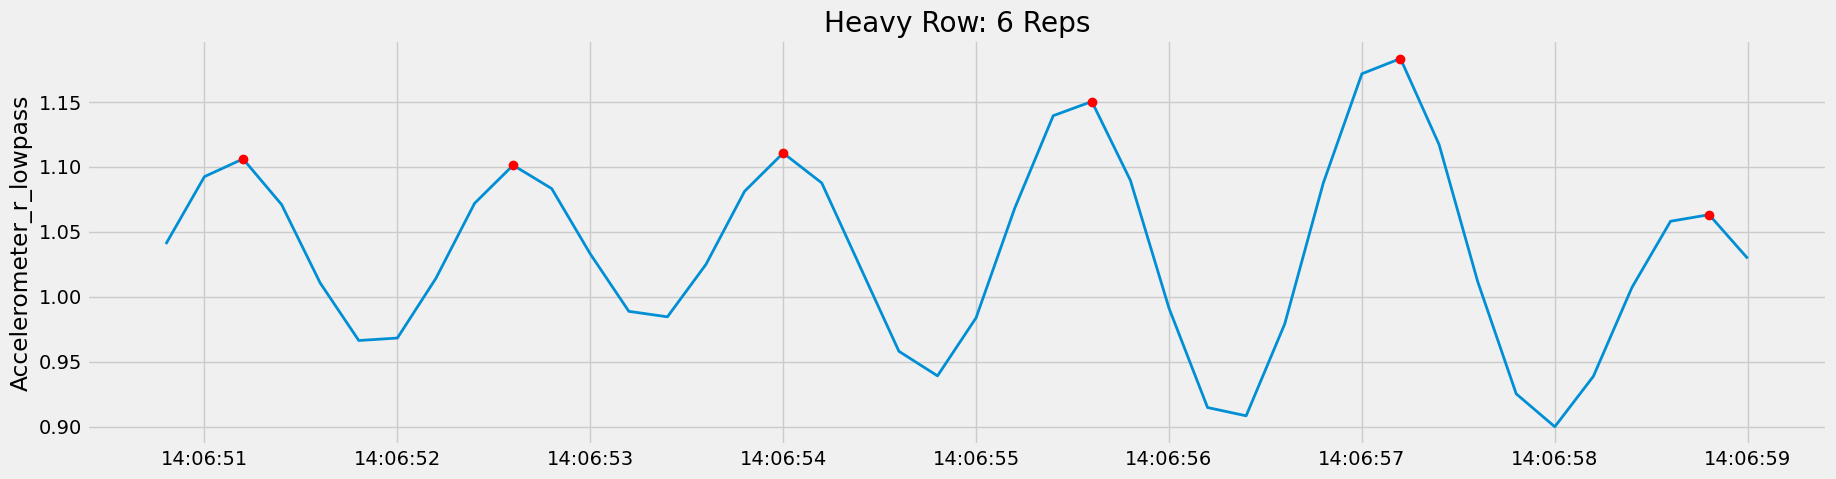

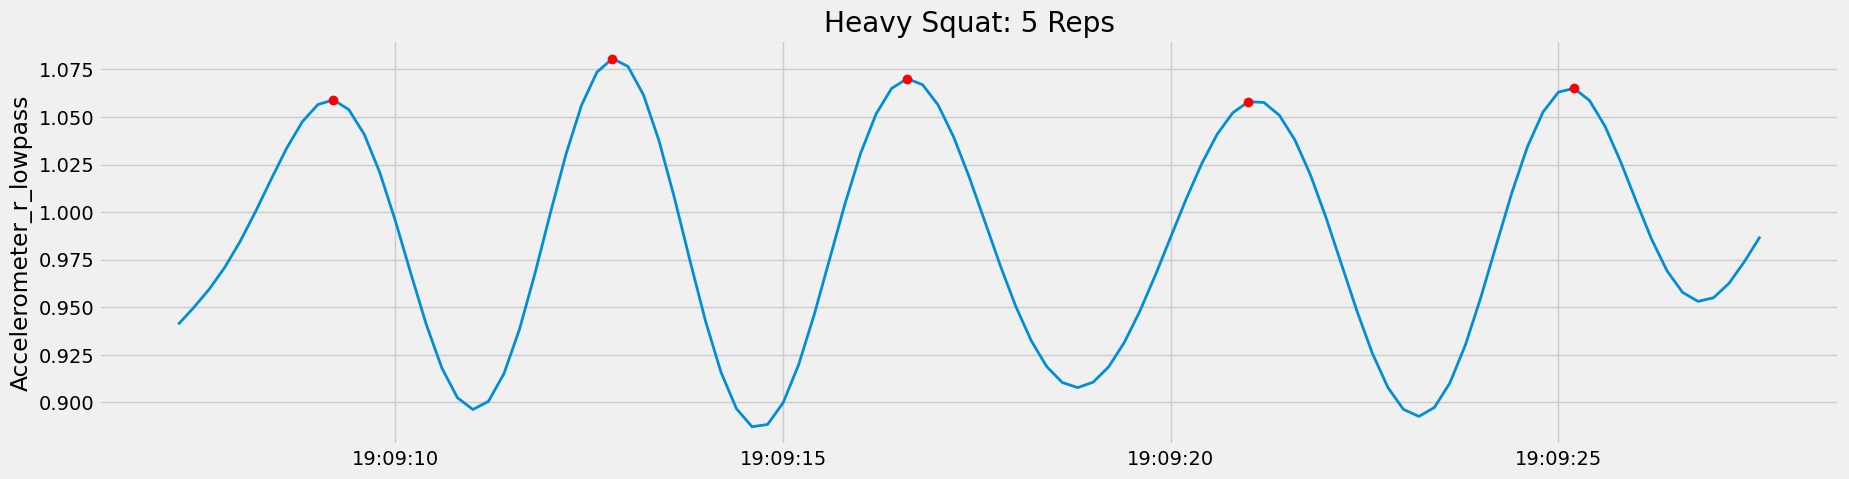

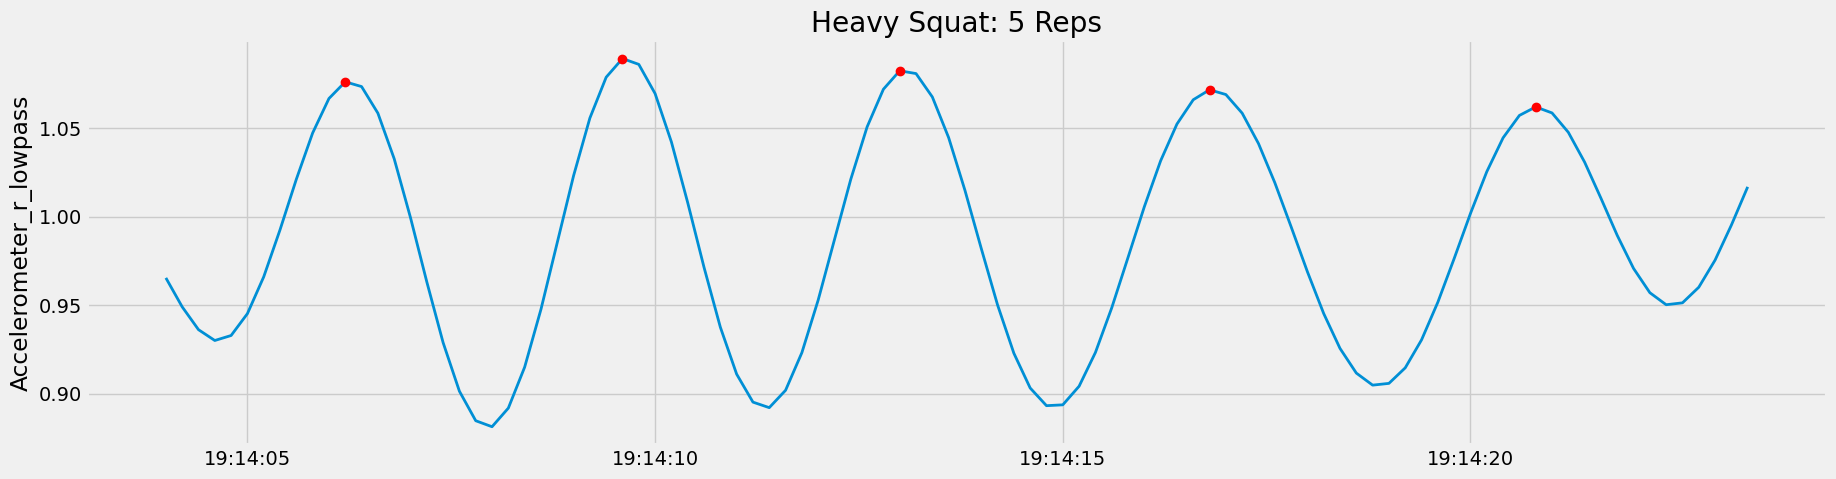

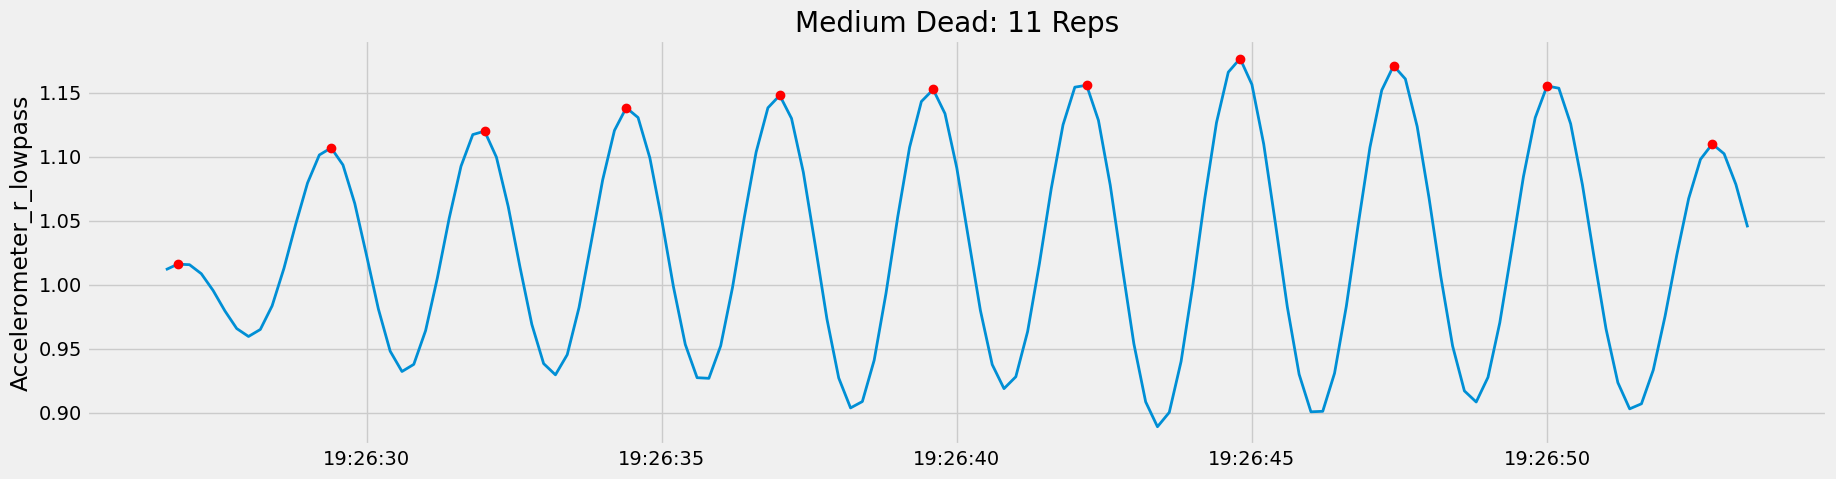

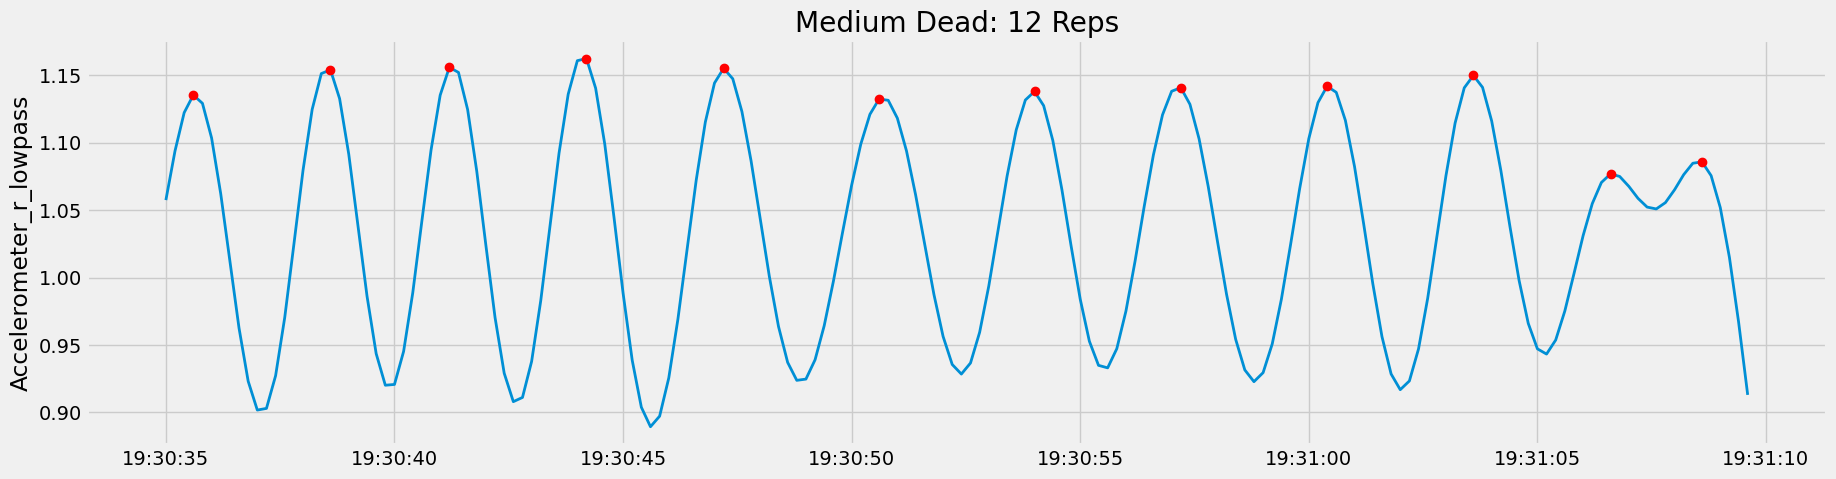

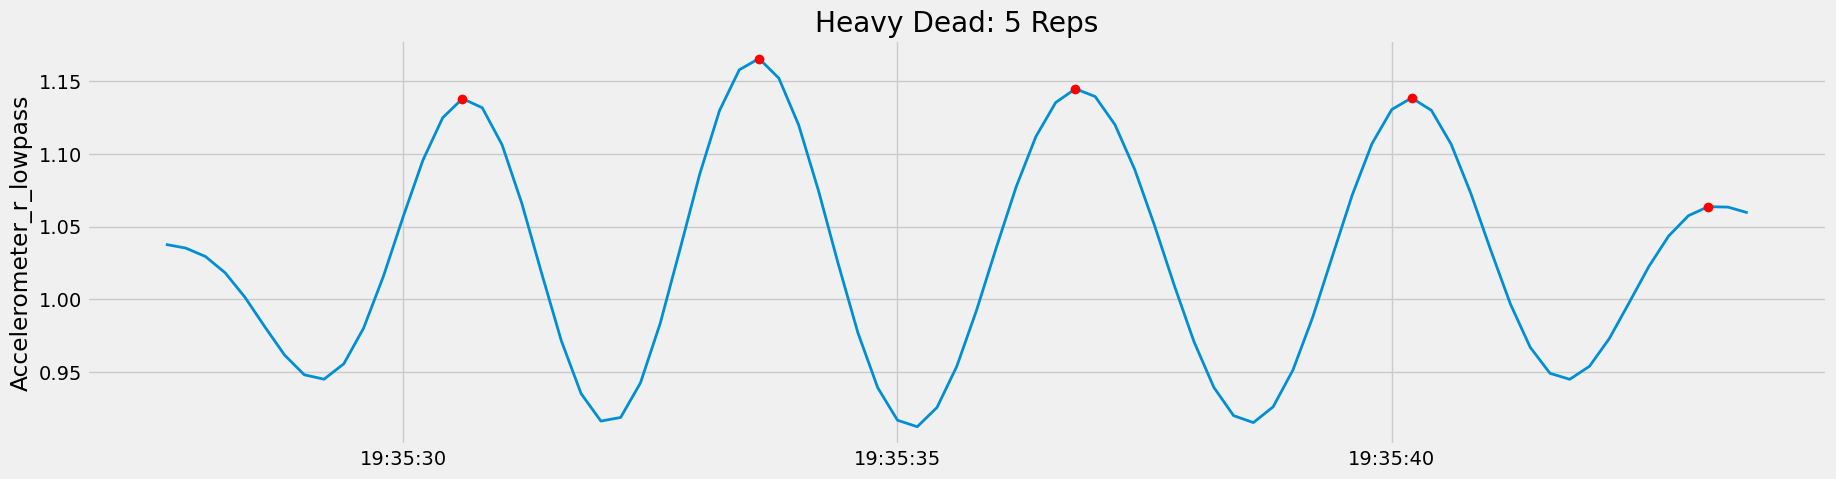

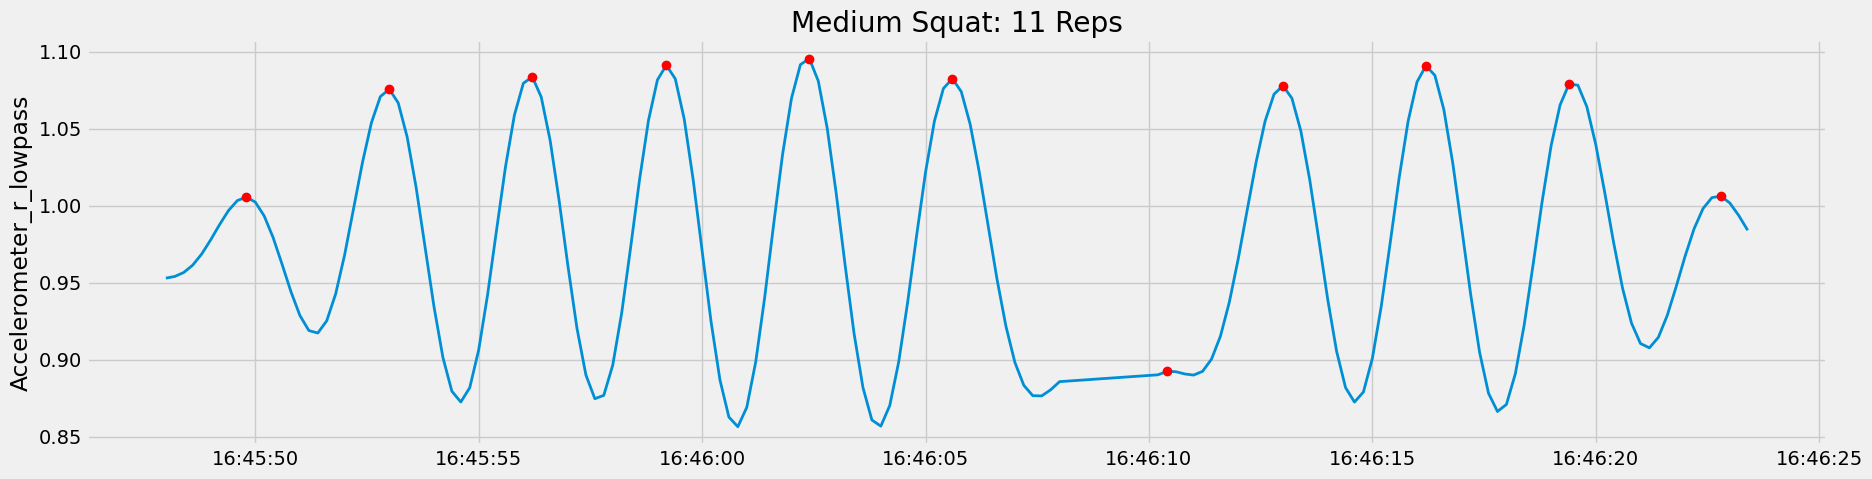

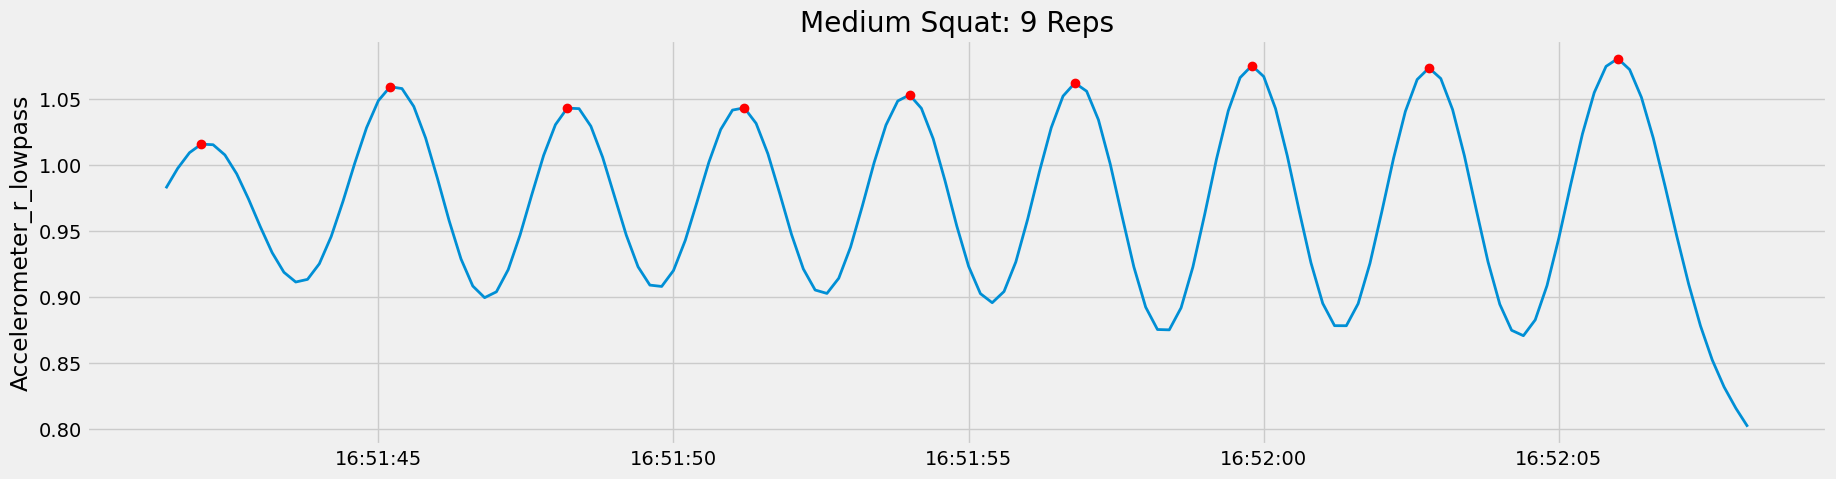

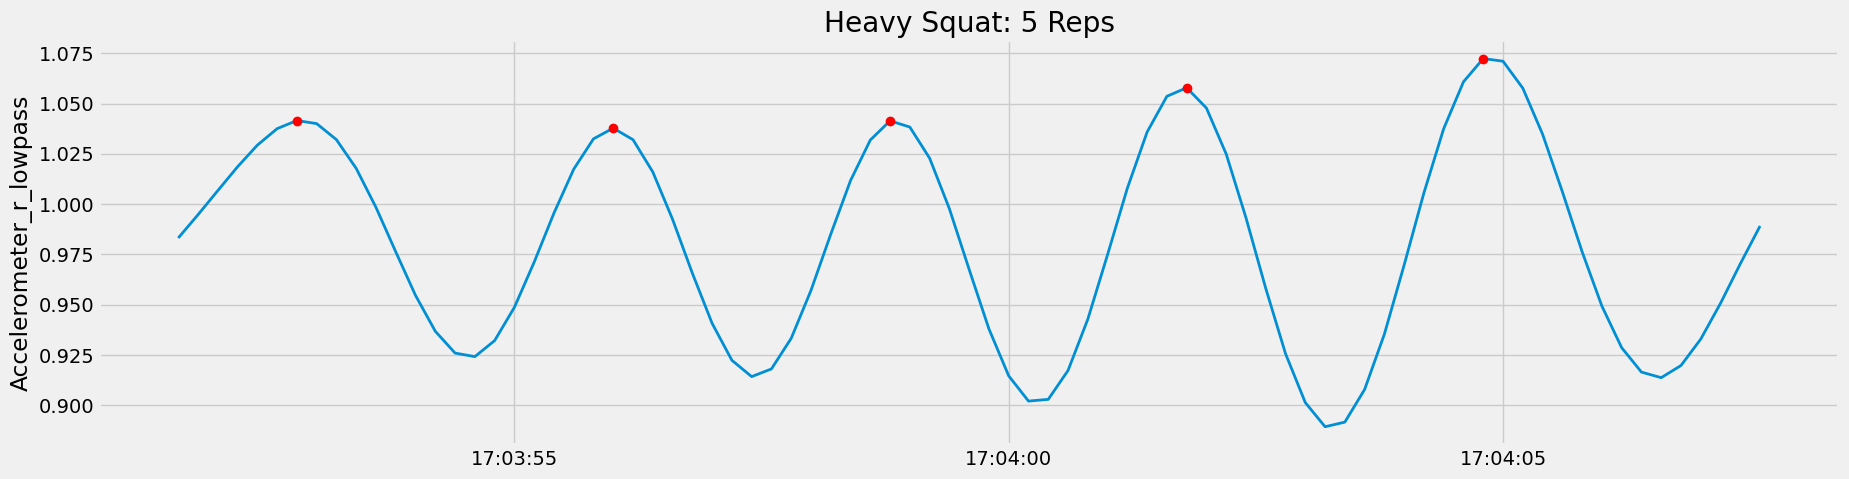

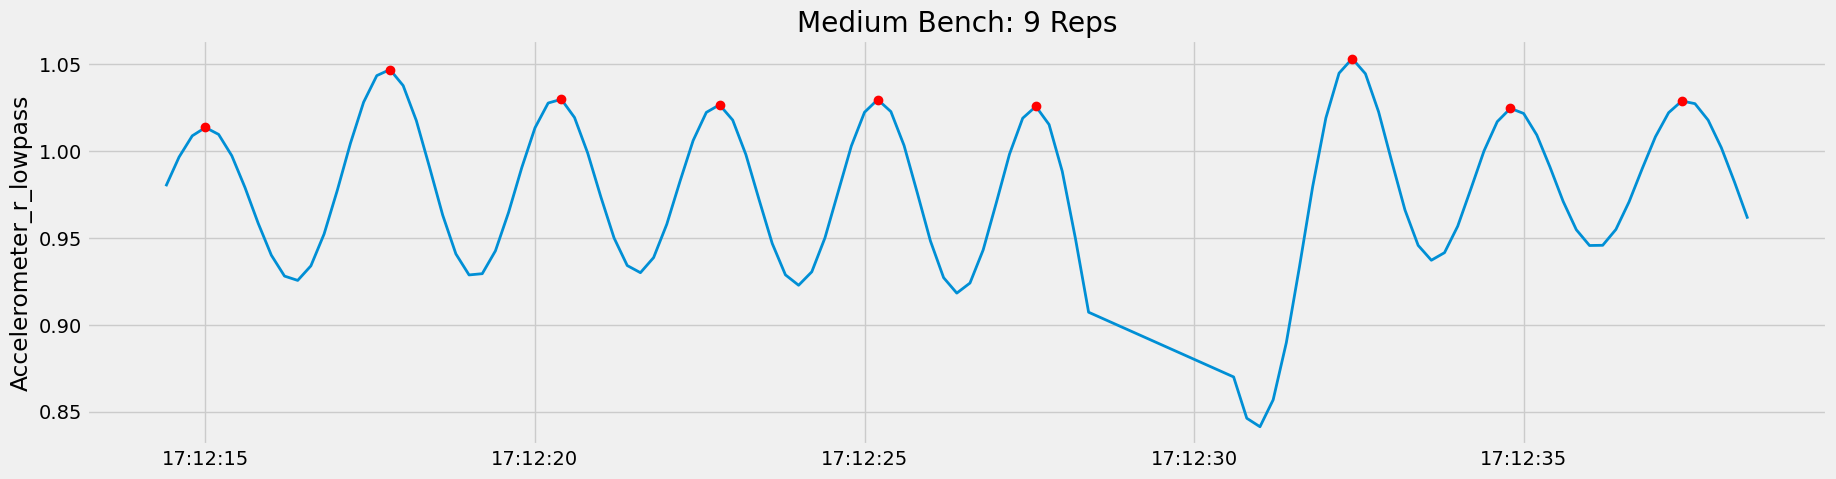

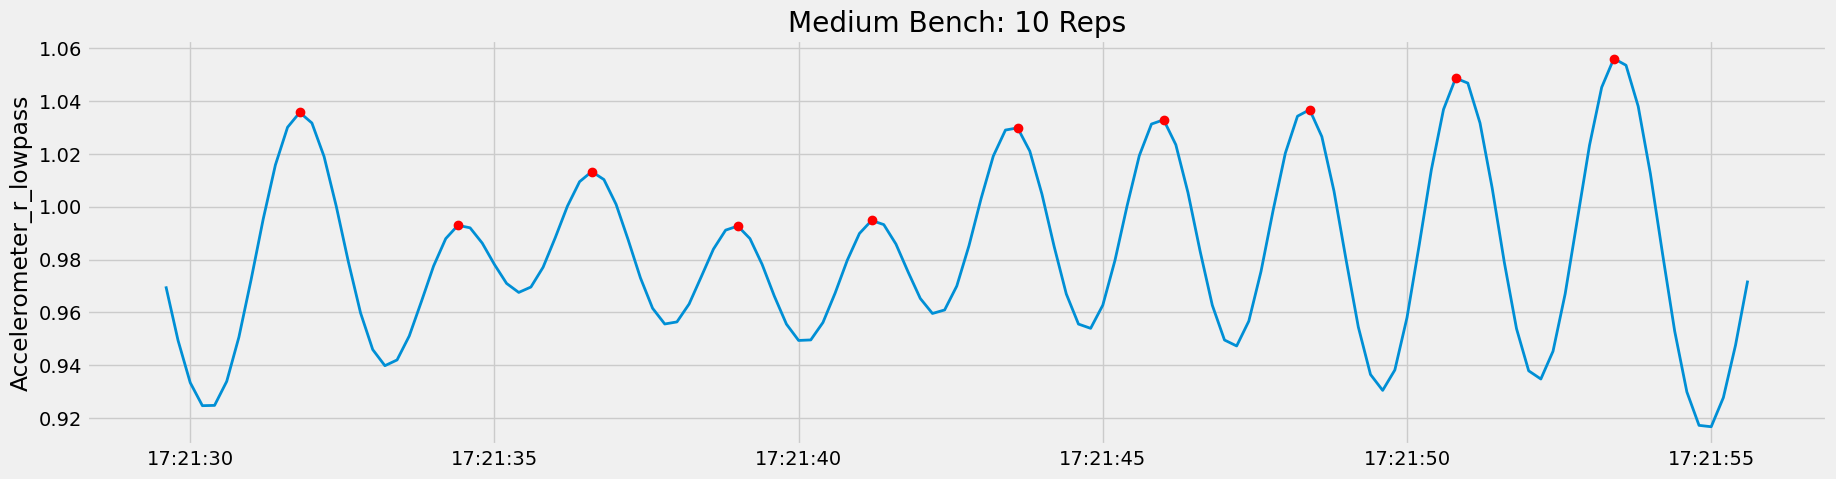

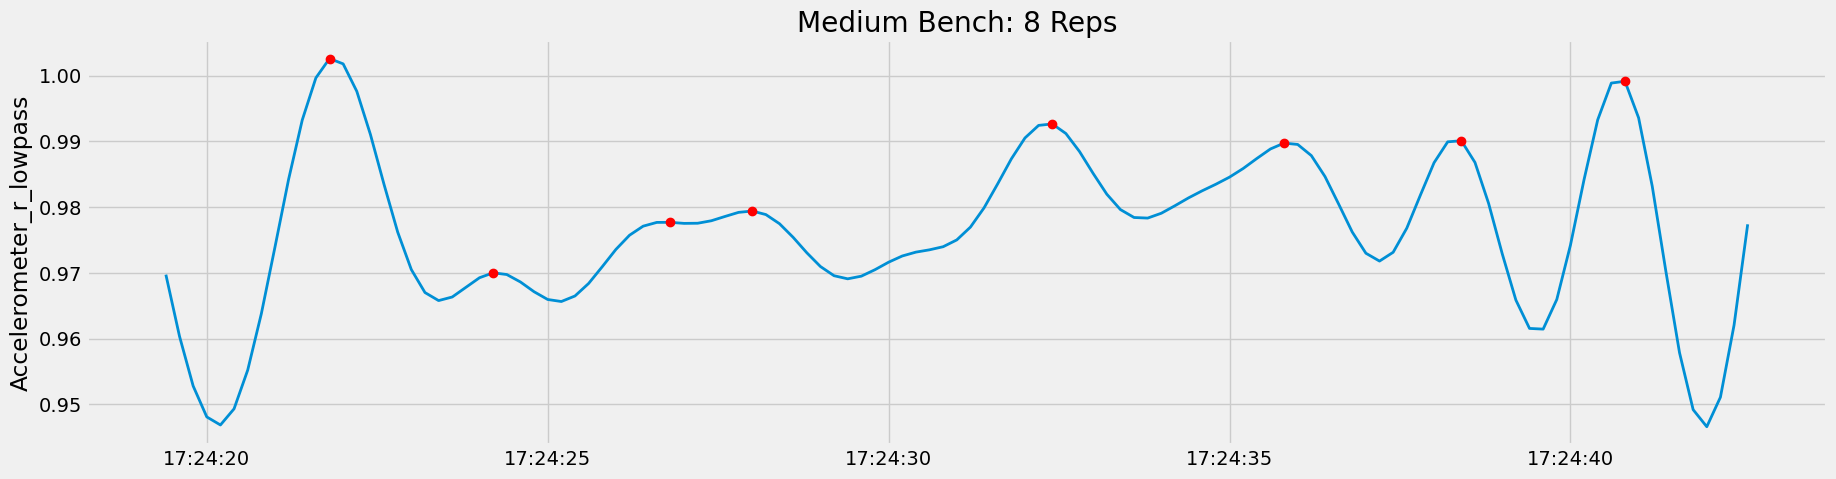

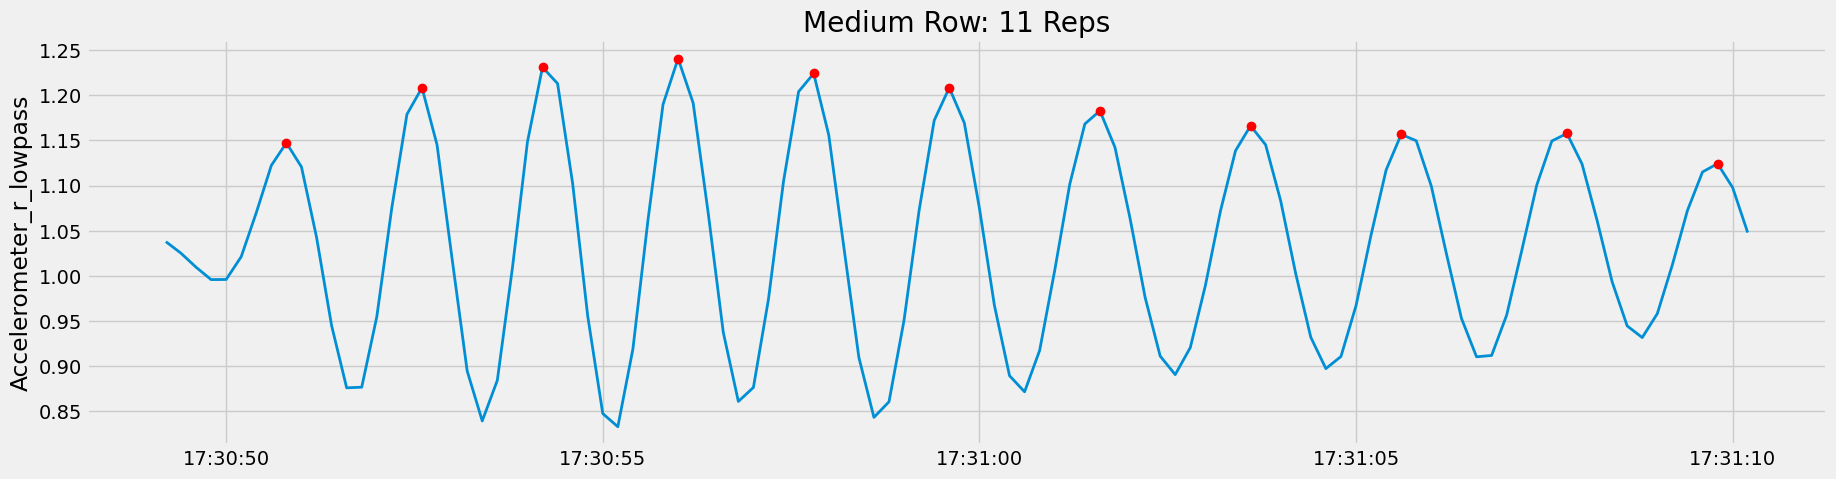

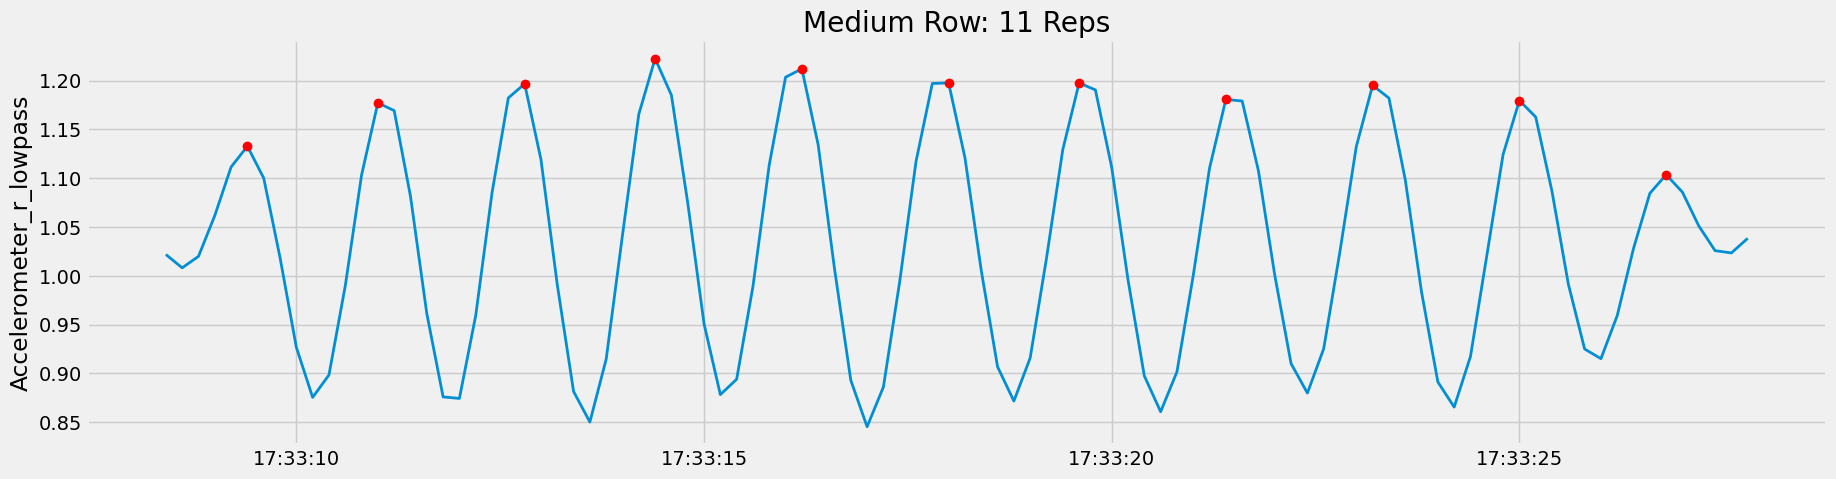

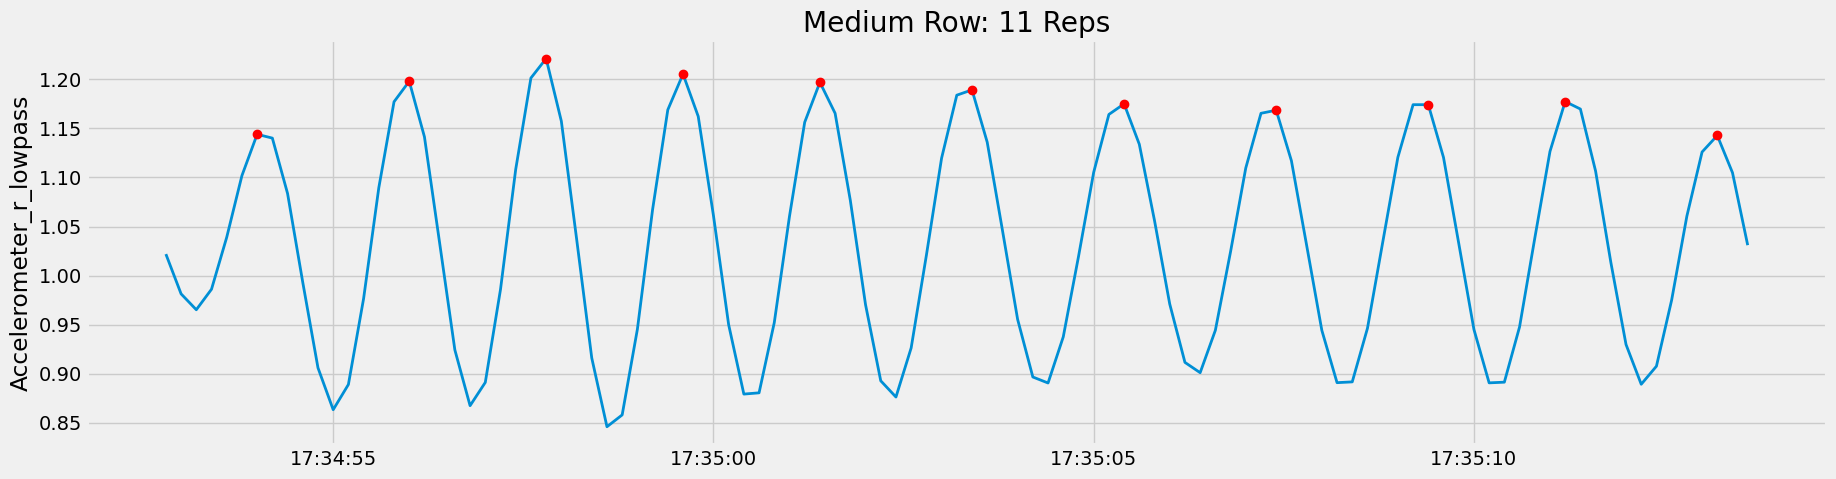

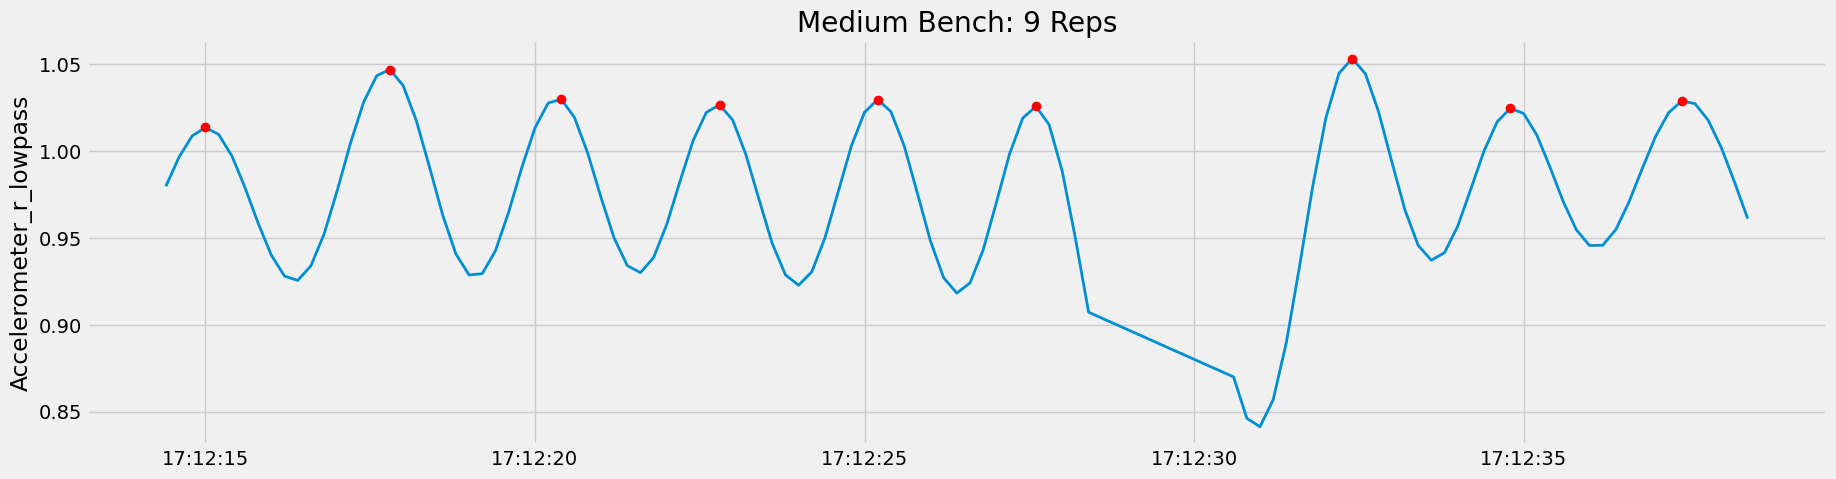

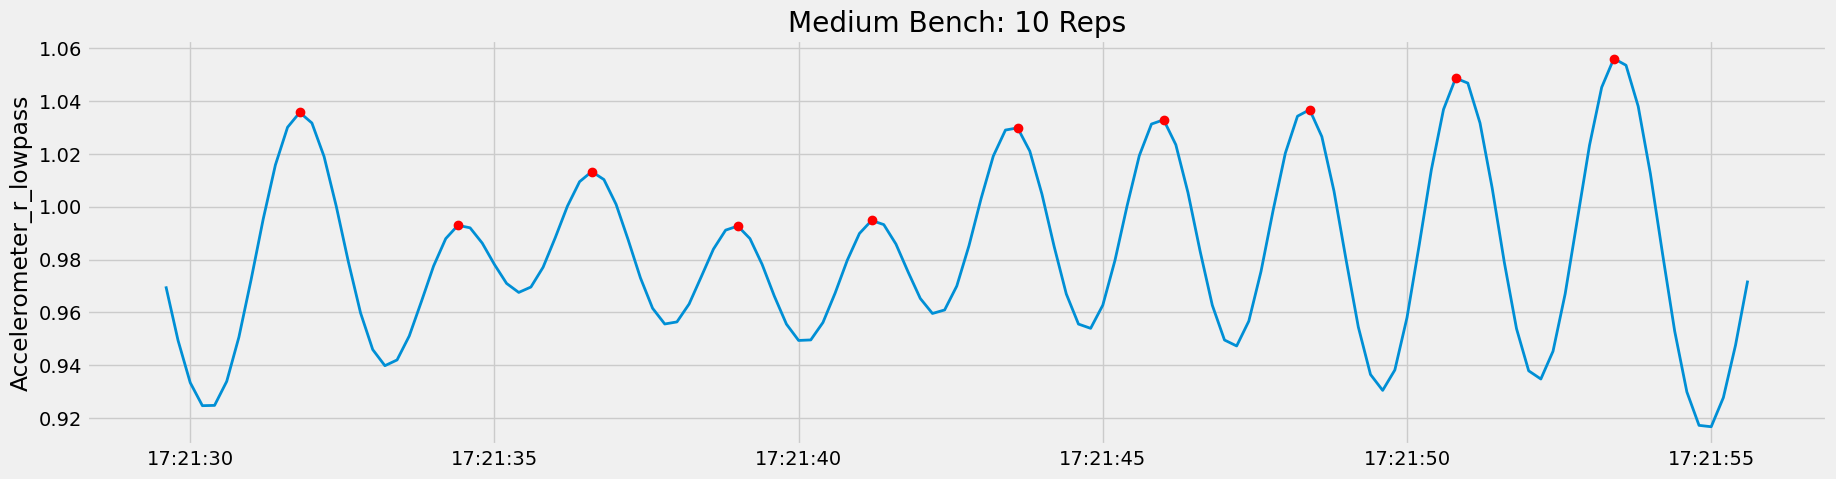

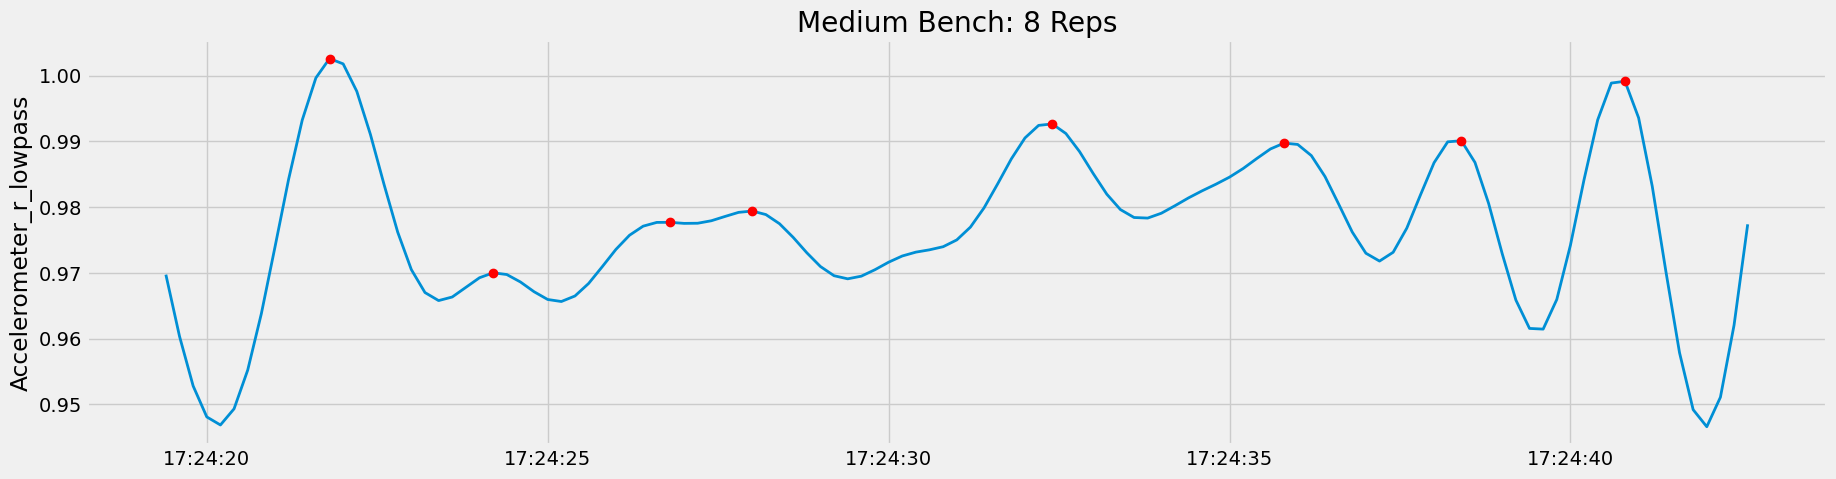

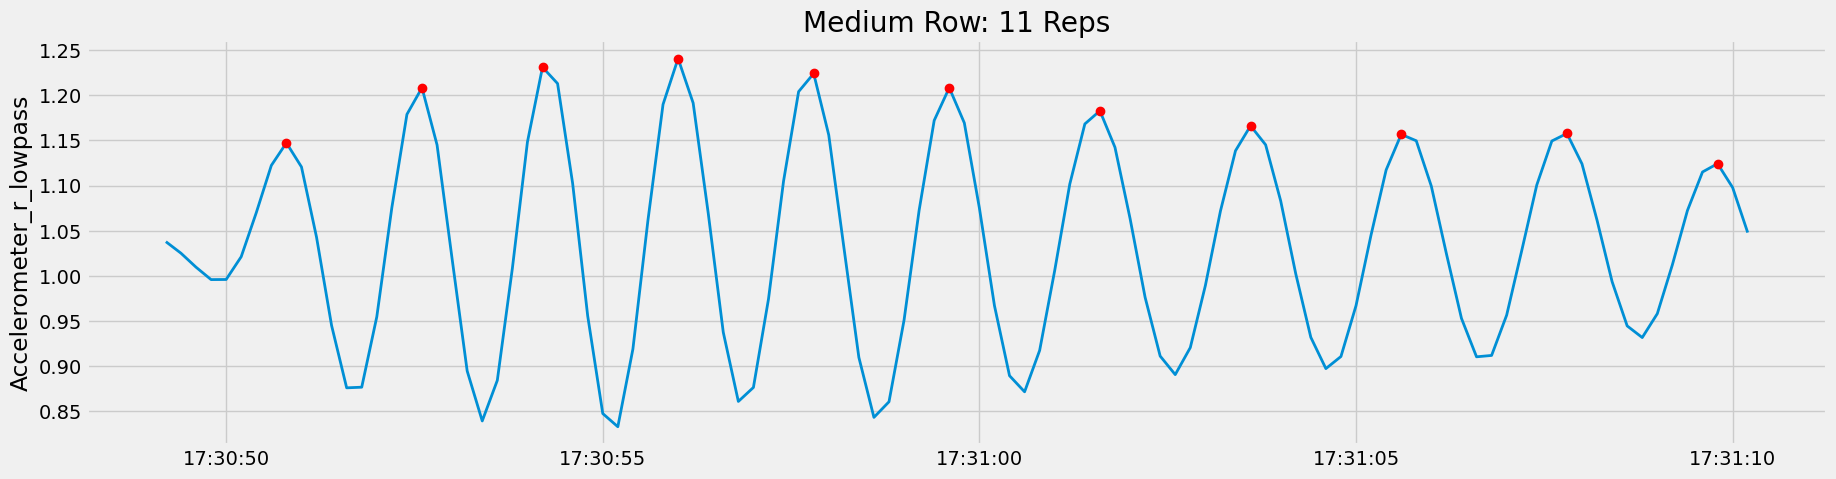

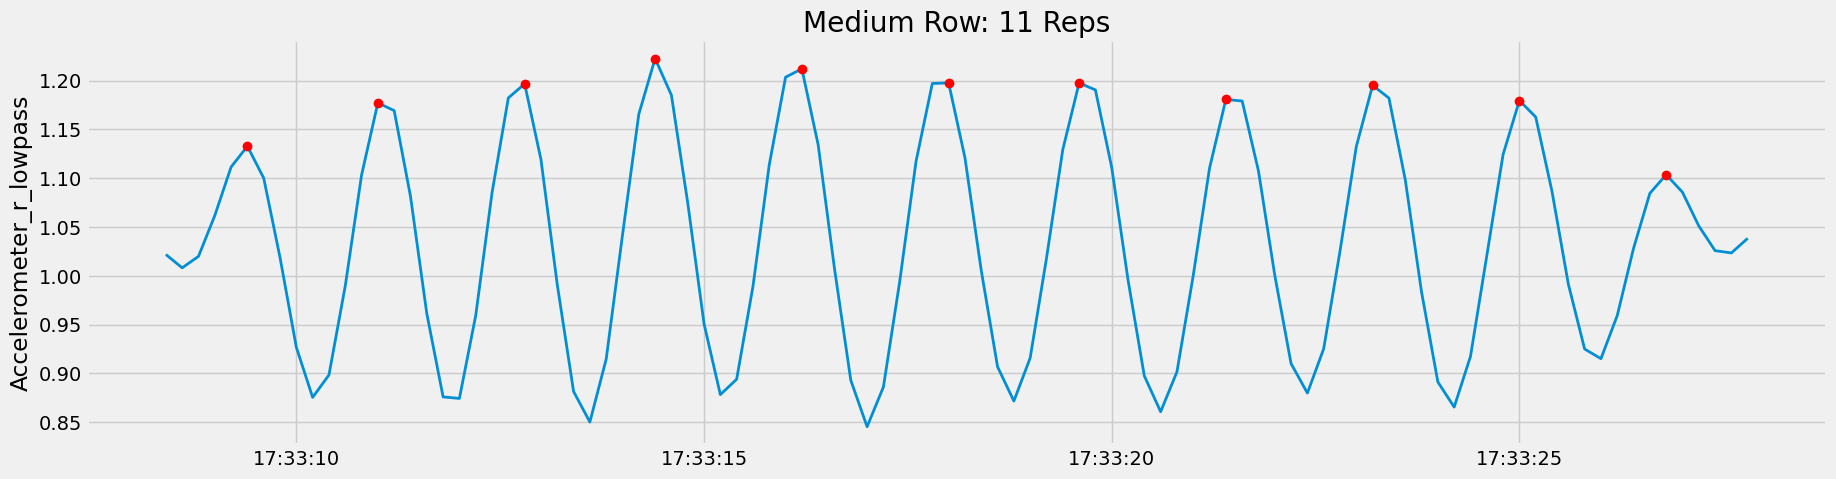

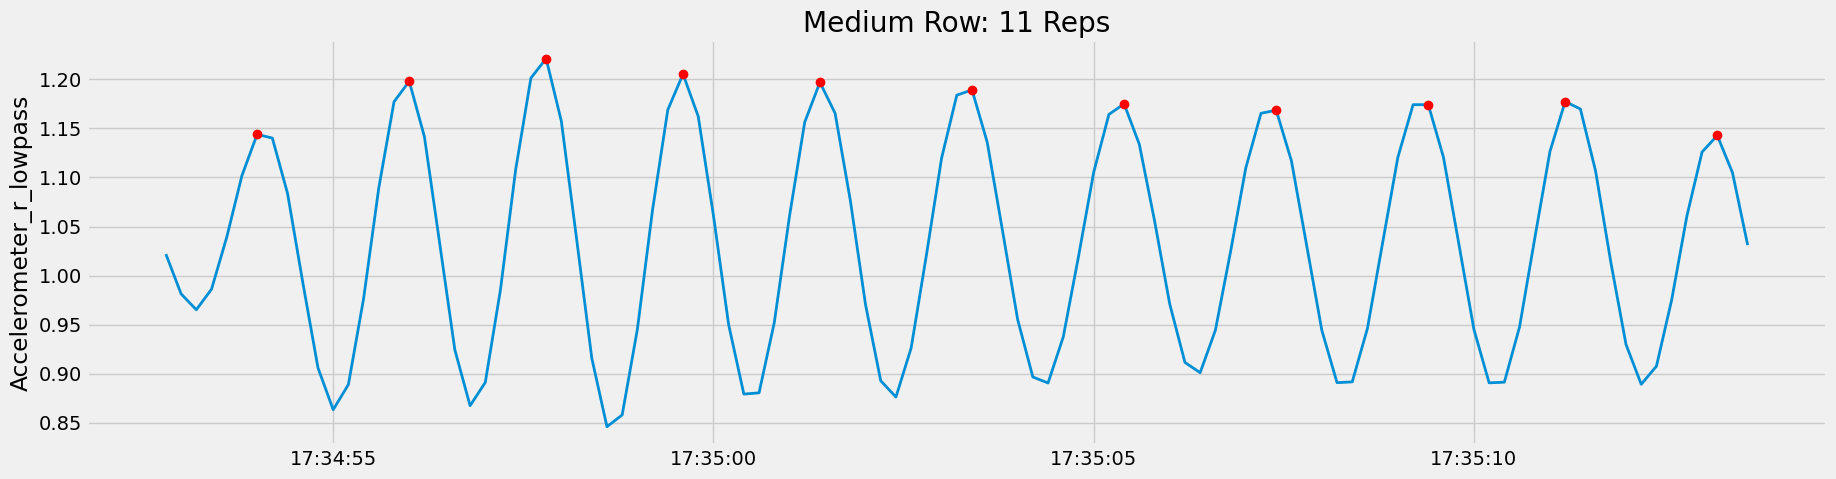

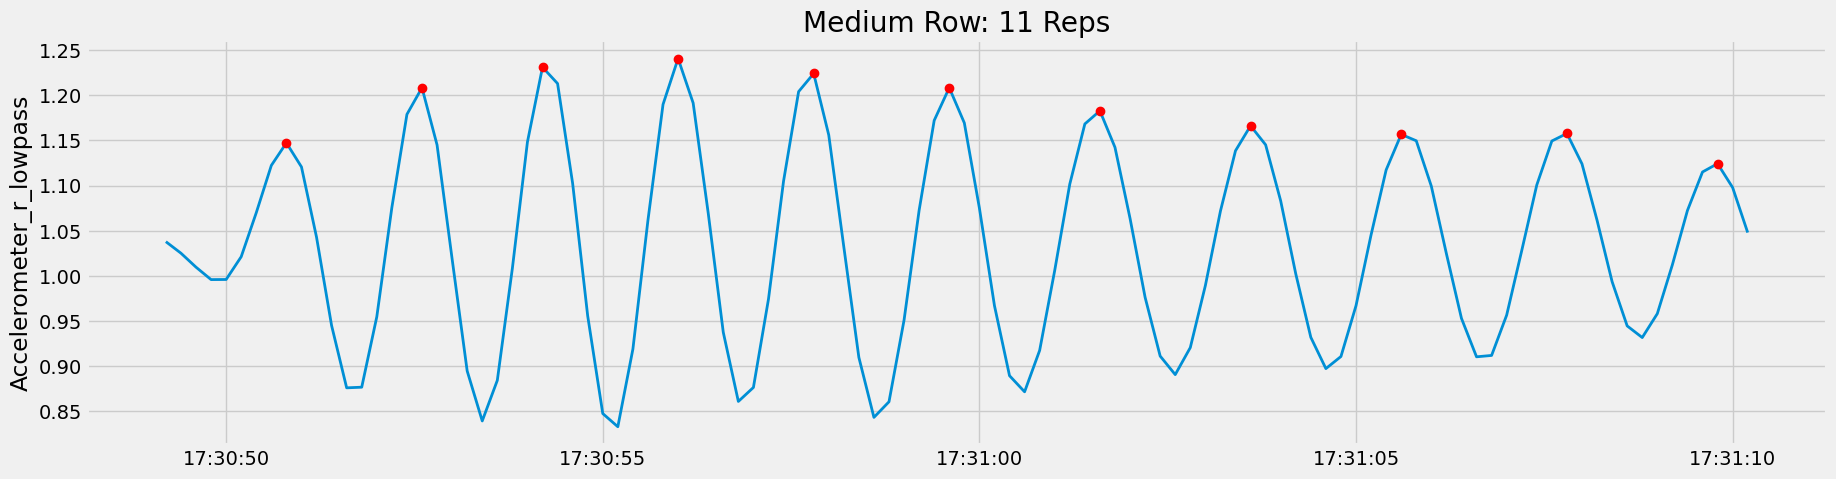

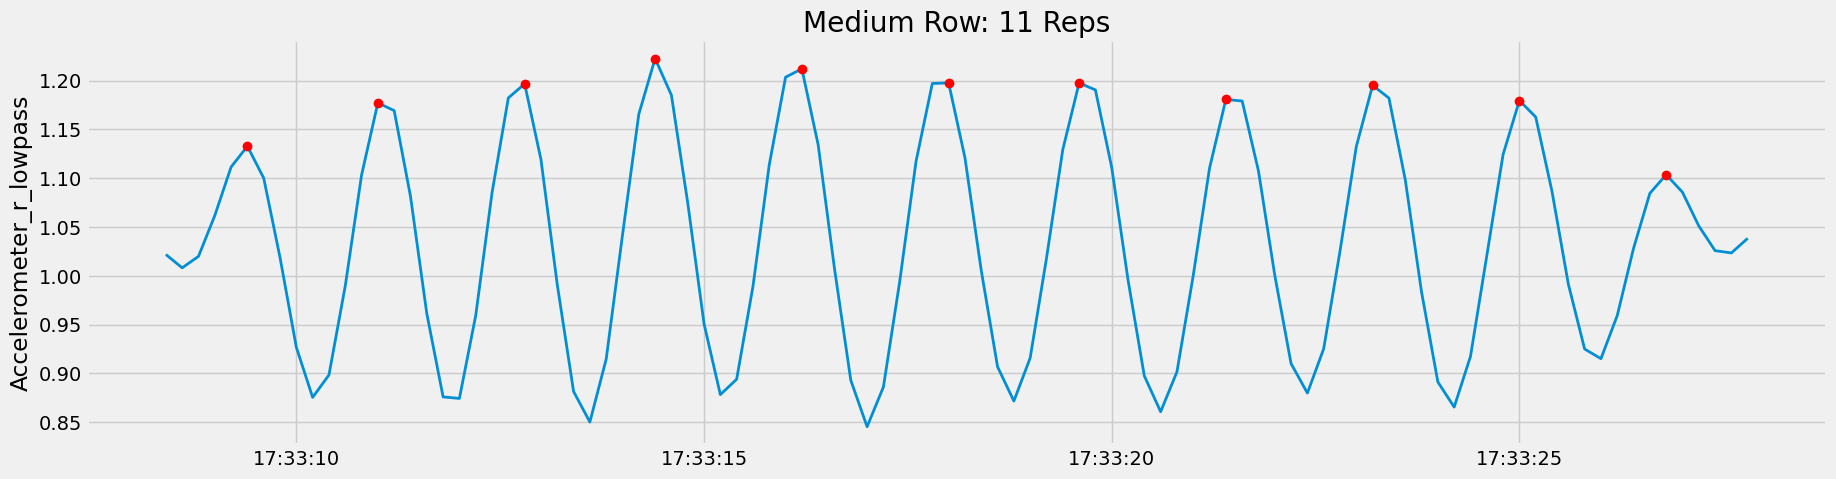

In [24]:
df["Reps"]=df["Category"].apply(lambda x:5 if x == "heavy" else 10)
rep_df=df.groupby(["Label","Category","Set"])["Reps"].max().reset_index()
rep_df["Reps_pred"]=0

for s in df["Set"].unique():
    subset=df[df["Set"]==s]
    column="Accelerometer_r"
    cutoff=0.4
    if subset["Label"].iloc[0] =="squat":
        cutoff=0.35
    if subset["Label"].iloc[0] =="row":
        cutoff=0.65
    if subset["Label"].iloc[0] =="ohp":
        cutoff=0.35

    reps=count(subset,cutoff,10,column)
    rep_df.loc[rep_df["Set"]==s,"Reps_pred"]=reps

In [25]:
rep_df

Label Category  Set  Reps  Reps_pred
0   bench    heavy    5     5          5
1   bench    heavy    7     5          5
2   bench    heavy   30     5          5
3   bench    heavy   33     5          5
4   bench    heavy   62     5          4
..    ...      ...  ...   ...        ...
80  squat   medium    9    10          8
81  squat   medium   16    10          5
82  squat   medium   26    10          7
83  squat   medium   41    10          8
84  squat   medium   70    10          9

[85 rows x 5 columns]

1.02


<Axes: xlabel='Label,Category'>

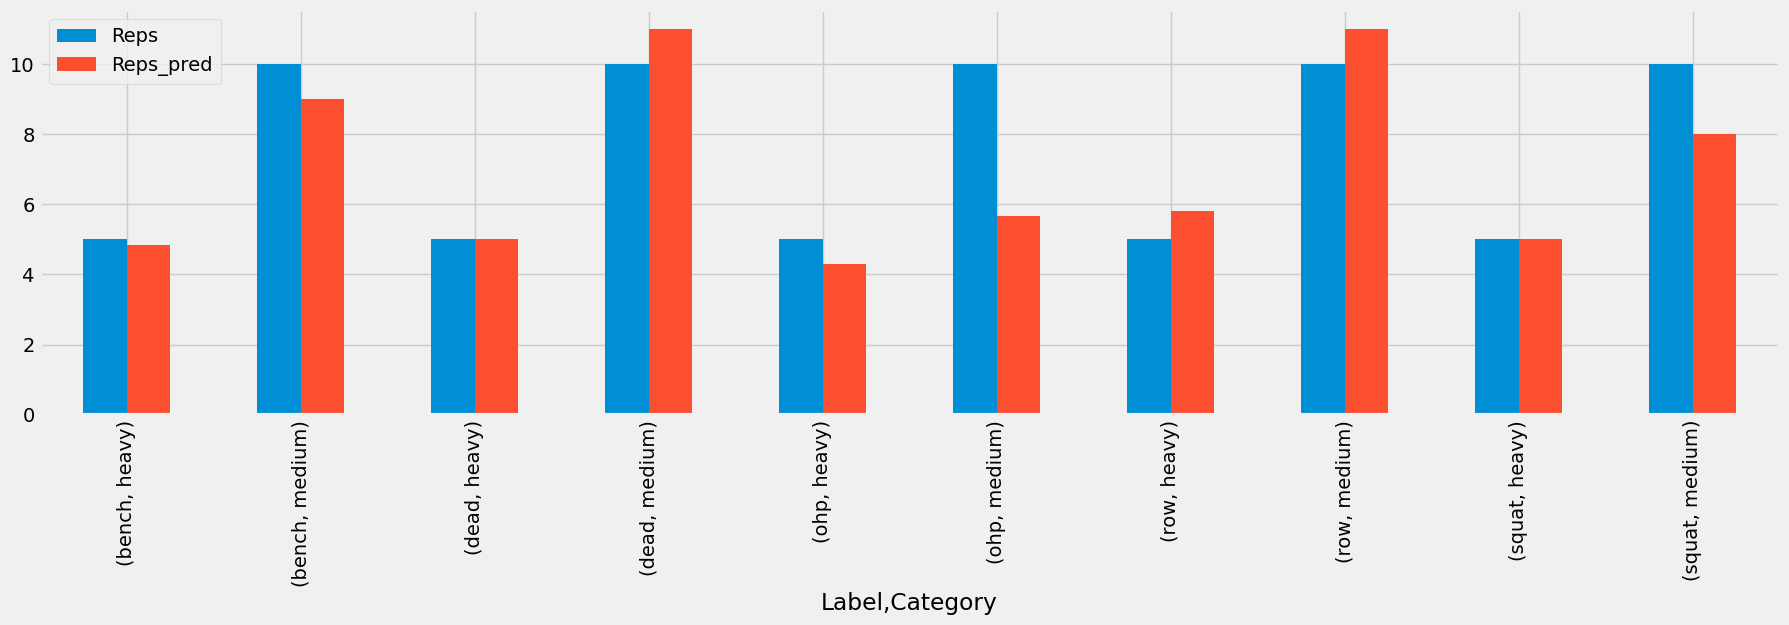

In [33]:
error=mean_absolute_error(rep_df["Reps"],rep_df["Reps_pred"]).round(2)
print(error)
rep_df.groupby(["Label","Category"])[["Reps","Reps_pred"]].mean().plot.bar()